# Agent, RL and MultiEnvironment

***Disclaimer***: This file referenced some files in other directories. In order to have working cross referencing it's recommended to start the notebook server from the root directory (`Grid2Op`) of the package and __not__ in the `getting_started` sub directory:
```bash
cd Grid2Op
jupyter notebook
```

***NB*** For more information about how to use the package, a general help can be built locally (provided that sphinx is installed on the machine) with:
```bash
cd Grid2Op
make html
```
from the top directory of the package (usually `Grid2Op`).

Once build, the help can be access from [here](../documentation/html/index.html)

It is recommended to have a look at the [0_basic_functionalities](0_basic_functionalities.ipynb), [1_Observation_Agents](1_Observation_Agents.ipynb) and [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) and especially [3_TrainingAnAgent](3_TrainingAnAgent.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will expose :
* what is a "MultiEnv"
* how can it be used with an agent
* how can it be used to train a agent that uses different environments

In [1]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

In [2]:
import grid2op
from grid2op.Reward import ConstantReward, FlatReward
import sys
import os
import numpy as np
TRAINING_STEP = 10

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/donnotben/.local/lib/python3.6/site-packages/pandapower/io_utils.py:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_series_equal, assert_frame_equal


## I) Download more data for the default environment.

A lot of data have been made available for the default "case14_redisp" environment. Including this data in the package is not convenient. We chose instead to release them and make them easily available with a utility. To download them in the default directory ("~/data_grid2op/case14_redisp") on linux based system you can do the following (uncomment the following command)

In [3]:
# !$sys.executable -m grid2op.download --name "case14_realistic"

## II) Make a regular environment and agent

Now that we downloaded the dataset, it is time to make an environment that will use all the data avaiable. You can execute the following command line. If you see any error or warning consider re downloading the data, or adapting the key-word argument "chronics_path" to match the path where the data have been downloaded.

In [4]:
try:
    env = grid2op.make(name_env="case14_realistic",
                       chronics_path=os.path.expanduser("~/data_grid2op/case14_realistic"))
except Exception as exc :
    print("Please read the above cell, it appears you don't have downloaded the dataset, "\
          "or save it into an unknown repository. " \
          "I will continue with only 2 sets.")
    env = grid2op.make(name_env="case14_realistic")

/home/donnotben/.local/lib/python3.6/site-packages/grid2op/MakeEnv.py:366: UserWarning: Your are using only 2 chronics for this environment. More can be download by running, from a command line:
python -m grid2op.download --name "case14_realistic" --path_save PATH\WHERE\YOU\WANT\TO\DOWNLOAD\DATA
  warnings.warn("Your are using only 2 chronics for this environment. More can be download by running, "


Cannot create and instance of chronics_class with parameters "<class 'grid2op.ChronicsHandler.ChronicsHandler'>"
Please read the above cell, it appears you don't have downloaded the dataset, or save it into an unknown repository. I will continue with only 2 sets.


## III) Train a standard RL Agent

Make sure you are using a computer with at least 4 cores if you want to notice some speed-ups.

In [5]:
from grid2op.MultiEnv import MultiEnvironment
from grid2op.Agent import DoNothingAgent
NUM_CORE = 8

### IIIa) Using the standard open AI gym loop

Here we demonstrate how to use the multi environment class. First let's create a multi environment.

In [6]:
# create a simple agent
agent = DoNothingAgent(env.action_space)

# create the multi environment class
multi_envs = MultiEnvironment(env=env, nb_env=NUM_CORE)

A multienvironment is just like a regular environment but instead of dealing with one action, and one observation, is requires to be sent multiple actions, and returns a list of observations as well. 

It requires a grid2op environment to be initialized and creates some specific "workers", each a replication of the initial environment. None of the "worker" can be accessed directly. Supported methods are:
- multi_env.reset
- multi_env.step
- multi_env.close

That have similar behaviour to "env.step", "env.close" or "env.reset".


It can be used the following manner.

In [7]:
# initiliaze some variable with the proper dimension
obss = multi_envs.reset()
rews = [env.reward_range[0] for i in range(NUM_CORE)]
dones = [False for i in range(NUM_CORE)]
obss

array([<grid2op.Observation.CompleteObservation object at 0x7f1900741320>,
      dtype=object)

In [8]:
dones

[False, False, False, False, False, False, False, False]

As you can see, obs is not a single obervation, but a list (numpy nd array to be precise) of 4 observations, each one being an observation of a given "worker" environment.

Worker environments are always called in the same order. It means the first observation of this vector will always correspond to the first worker environment. 


Similarly to Observation, the "step" function of a multi_environment takes as input a list of multiple actions, each action will be implemented in its own environment. It returns a list of observations, a list of rewards, and boolean list of whether or not the worker environment suffer from a game over (in that case this worker environment is automatically restarted using the "reset" method.)

Because orker environments are always called in the same order, the first action sent to the "multi_env.step" function will also be applied on this first environment.

It is possible to use it as follow:

In [9]:
# initialize the vector of actions that will be processed by each worker environment.
acts = [None for _ in range(NUM_CORE)]
for env_act_id in range(NUM_CORE):
    acts[env_act_id] = agent.act(obss[env_act_id], rews[env_act_id], dones[env_act_id])
    
# feed them to the multi_env
obss, rews, dones, infos = multi_envs.step(acts)

# as explained, this is a vector of Observation (as many as NUM_CORE in this example)
obss

array([<grid2op.Observation.CompleteObservation object at 0x7f190074fe10>,
      dtype=object)

The multi environment loop is really close to the "gym" loop:

In [10]:
# performs the appropriated steps
for i in range(TRAINING_STEP):
    acts = [None for _ in range(NUM_CORE)]
    for env_act_id in range(NUM_CORE):
        acts[env_act_id] = agent.act(obss[env_act_id], rews[env_act_id], dones[env_act_id])
    obss, rews, dones, infos = multi_envs.step(acts)

    # DO SOMETHING WITH THE AGENT IF YOU WANT
    ## agent.train(obss, rews, dones)
    

# close the environments created by the multi_env
multi_envs.close()

On the above example, `TRAINING_STEP` steps are performed on `NUM_CORE` environments in parrallel. The agent has then acted `TRAINING_STEP * NUM_CORE` (=`10 * 4 = 40` by default) times on `NUM_CORE` different environments.

### III.b) Practical example

We reuse the code of the Notebook [3_TrainingAnAgent](3_TrainingAnAgent.ipynb) to train a new agent, but this time using more than one process of the machine. To further emphasize the working of multi environments, we put on a different module all the code of the agents and focus here on the training.

In [11]:
from ml_agent import TrainingParam, ReplayBuffer, DeepQAgent
from grid2op.Agent import AgentWithConverter
from grid2op.Reward import RedispReward
from grid2op.Converters import IdToAct
import numpy as np
import random
import warnings
import pdb
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow.keras
    import tensorflow.keras.backend as K
    from tensorflow.keras.models import load_model, Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, subtract, add
    from tensorflow.keras.layers import Input, Lambda, Concatenate

In [12]:
class TrainAgentMultiEnv(object):
    def __init__(self, agent, nb_process, reward_fun=RedispReward, env=None, name=None):
        # TrainAgent.__init__(self, agent, reward_fun=RedispReward, env=env)
        self.nb_process = nb_process
        self.multi_envs = None
        self.process_buffer = [[] for _ in range(self.nb_process)]
        self.name = name
        self.agent = agent
        self.env = env
        self.training_param = None
        
    def convert_obs(self, observation):
        return observation.rho
    
    def convert_process_buffer(self):
        """Converts the list of NUM_FRAMES images in the process buffer
        into one training sample"""
        # here i simply concatenate the action in case of multiple action in the "buffer"
        # this function existed in the original implementation, bus has been adapted.
        if self.training_param.NUM_FRAMES != 1:
            raise RuntimeError("can only use self.training_param.NUM_FRAMES = 1 for now")
        return np.array([np.concatenate(el) for el in self.process_buffer])
        
    def _build_valid_env(self, training_param):
        create_new = False
        if self.multi_envs is None:
            self.multi_envs = MultiEnvironment(env=env, nb_env=self.nb_process)
            
            # make sure the environment is reset
            obss = self.multi_envs.reset()
            for worker_id in range(self.nb_process):
                self.process_buffer[worker_id].append(self.agent.convert_obs(obss[worker_id]))
            do_nothing = [self.env.action_space() for _ in range(self.nb_process)]
            for _ in range(training_param.NUM_FRAMES-1):
                # Initialize buffer with the first frames
                s1, r1, _, _ = self.multi_envs.step(do_nothing)
                for worker_id in range(self.nb_process):
                    self.process_buffer[worker_id].append(self.agent.convert_obs(s1[worker_id])) 
        return create_new
    
    def train(self, num_frames, training_param=TrainingParam()):
        self.training_param = training_param
        
        # first we create an environment or make sure the given environment is valid
        close_env = self._build_valid_env(training_param)
        
        # bellow that, only slight modification has been made. They are highlighted
        observation_num = 0
        curr_state = self.convert_process_buffer()
        
        # it's a bit less convenient that using the SpaceInvader environment.
        # first we need to initiliaze the neural network
        self.agent.init_deep_q(curr_state)
        # TODO it's weird to use the process buffer for this purpose...
            
        epsilon = training_param.INITIAL_EPSILON
        alive_frame = np.zeros(self.nb_process, dtype=np.int)
        total_reward = np.zeros(self.nb_process, dtype=np.float)

        while observation_num < num_frames:
            if observation_num % 1000 == 999:
                print(("Executing loop %d" %observation_num))
                # for efficient reading of data: at early stage of training, it is advised to load
                # data by chunk: the model will do game over pretty easily (no need to load all the dataset)
                tmp = min(10000 * (num_frames // observation_num), 10000)
                self.multi_envs.set_chunk_size(int(max(100, tmp)))

            # Slowly decay the learning rate
            if epsilon > training_param.FINAL_EPSILON:
                epsilon -= (training_param.INITIAL_EPSILON-training_param.FINAL_EPSILON)/training_param.EPSILON_DECAY

            initial_state = self.convert_process_buffer()
            self.process_buffer = [[] for _ in range(self.nb_process)]
            
            # TODO vectorize that in the Agent directly
            # ADDED
            predict_movement_int = []
            predict_q_value = []
            acts = []
            # then we need to predict the next moves
            #pdb.set_trace()
            pm_i, pq_v = self.agent.deep_q.predict_movement(curr_state, epsilon)
            for p_id in range(self.nb_process):
                predict_movement_int.append(pm_i[p_id])
                predict_q_value.append(pq_v[p_id])
                # and then we convert it to a valid action
                acts.append(self.agent.convert_act(pm_i[p_id]))
            
            reward, done = np.zeros(self.nb_process), np.full(self.nb_process, fill_value=False, dtype=np.bool)
            for i in range(training_param.NUM_FRAMES):
                temp_observation_obj, temp_reward, temp_done, _ = self.multi_envs.step(acts)
                # here it has been adapted too. The observation get from the environment is
                # first converted to vector
                
                # below this line no changed have been made to the original implementation.
                reward[~temp_done] += temp_reward[~temp_done]
                
                
                for worker_id, obs in enumerate(temp_observation_obj):
                    # ADDED
                    self.process_buffer[worker_id].append(self.agent.convert_obs(temp_observation_obj[worker_id])) 
                    
                done = done | temp_done

                # TODO fix that too
                alive_frame[~temp_done] += 1
            
                for env_done_idx in np.where(temp_done)[0]:
                    print("For env with id {}".format(env_done_idx))
                    print("\tLived with maximum time ", alive_frame[env_done_idx])
                    print("\tEarned a total of reward equal to ", total_reward[env_done_idx])
                
                reward[temp_done] = 0.
                total_reward[temp_done] = 0.
                total_reward += reward
                alive_frame[temp_done] = 0
            
            new_state = self.convert_process_buffer()
            for sub_env_id in range(self.nb_process):
                # ADDED
                self.agent.replay_buffer.add(initial_state[sub_env_id],
                                             predict_movement_int[sub_env_id],
                                             reward[sub_env_id],
                                             done[sub_env_id],
                                             new_state[sub_env_id])
                
            if self.agent.replay_buffer.size() > training_param.MIN_OBSERVATION:
                s_batch, a_batch, r_batch, d_batch, s2_batch = self.agent.replay_buffer.sample(training_param.MINIBATCH_SIZE)
                isfinite = self.agent.deep_q.train(s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num)
                self.agent.deep_q.target_train()
            
                if not isfinite:
                    # if the loss is not finite i stop the learning
                    print("ERROR INFINITE LOSS")
                    break
                

            # Save the network every 10000 iterations
            if observation_num % 10000 == 9999 or observation_num == num_frames-1:
                print("Saving Network")
                if self.name is None:
                    self.agent.deep_q.save_network("saved_notebook6.h5")
                else:
                    self.agent.deep_q.save_network("saved_notebook6_{}.h5".format(self.name))
                
            observation_num += 1
            
        if close_env:
            print("closing env")
            self.env.close()
        

We redifine the class used to train the agent.

In [13]:
TRAINING_STEP = 1000000
agent_name = "ddqn_1e6"
env = grid2op.make("case14_realistic",
                   chronics_path = os.path.expanduser("~/data_grid2op/case14_realistic"))
my_agent = DeepQAgent(env.action_space, mode="DDQN", training_param=TrainingParam())
trainer = TrainAgentMultiEnv(agent=my_agent, env=env, nb_process=NUM_CORE, name=agent_name)
# trainer = TrainAgent(agent=my_agent, env=env)
trainer.train(TRAINING_STEP)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Successfully constructed networks.
Instructions for updating:
Use tf.cast instead.
For env with id 4
	Lived with maximum time  7
	Earned a total of reward equal to  195.28437934928414
For env with id 1
	Lived with maximum time  11
	Earned a total of reward equal to  428.5818173970204
For env with id 1
	Lived with maximum time  1
	Earned a total of reward equal to  227.83816425120773
For env with id 2
	Lived with maximum time  15
	Earned a total of reward equal to  922.209090646065
For env with id 5
	Lived with maximum time  16
	Earned a total of reward equal to  1173.2120392886686
For env with id 7
	Lived with maximum time  23
	Earned a total of reward equal to  3532.1273618539503
For env with id 4
	Lived with maximum time  16
	Earned a total of reward equal to  2326.902568578638
For env with id 5
	Lived with maximum time  8
	Earned a total of reward equal to  1843.36

For env with id 1
	Lived with maximum time  19
	Earned a total of reward equal to  3962.4867298989484
For env with id 5
	Lived with maximum time  133
	Earned a total of reward equal to  31483.848202524532
We had a loss equal to  139.63017
For env with id 6
	Lived with maximum time  21
	Earned a total of reward equal to  4619.974730807432
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  446.7801159622801
For env with id 1
	Lived with maximum time  8
	Earned a total of reward equal to  1879.779439093143
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  458.94341570359984
For env with id 5
	Lived with maximum time  10
	Earned a total of reward equal to  2070.71916609782
For env with id 6
	Lived with maximum time  31
	Earned a total of reward equal to  7065.780423167713
For env with id 1
	Lived with maximum time  46
	Earned a total of reward equal to  11145.139254106376
For env with id 6
	Lived with maximum time  55
	Earned a

For env with id 0
	Lived with maximum time  23
	Earned a total of reward equal to  5290.9373585718495
For env with id 0
	Lived with maximum time  15
	Earned a total of reward equal to  3537.979154011433
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  445.2637918306573
For env with id 2
	Lived with maximum time  31
	Earned a total of reward equal to  7022.048373153032
For env with id 4
	Lived with maximum time  81
	Earned a total of reward equal to  19609.10530967112
For env with id 0
	Lived with maximum time  29
	Earned a total of reward equal to  6776.975355128265
For env with id 0
	Lived with maximum time  4
	Earned a total of reward equal to  884.1554472615882
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  451.976649423362
We had a loss equal to  95.52171
For env with id 0
	Lived with maximum time  42
	Earned a total of reward equal to  9942.401320237039
For env with id 2
	Lived with maximum time  87
	Earned a tota

For env with id 2
	Lived with maximum time  150
	Earned a total of reward equal to  35446.76789888331
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  452.5270312999269
For env with id 7
	Lived with maximum time  42
	Earned a total of reward equal to  9716.766395787157
For env with id 2
	Lived with maximum time  16
	Earned a total of reward equal to  3465.94362081356
For env with id 6
	Lived with maximum time  810
	Earned a total of reward equal to  6113.530697416323
For env with id 5
	Lived with maximum time  42
	Earned a total of reward equal to  8943.37536000041
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  453.3966457716625
For env with id 5
	Lived with maximum time  1
	Earned a total of reward equal to  243.37882547559968
For env with id 2
	Lived with maximum time  18
	Earned a total of reward equal to  4318.34740100845
For env with id 5
	Lived with maximum time  8
	Earned a total of reward equal to  1844.6527885

For env with id 4
	Lived with maximum time  9
	Earned a total of reward equal to  1176.539790774156
We had a loss equal to  118.74519
For env with id 5
	Lived with maximum time  508
	Earned a total of reward equal to  4077.593888722663
For env with id 5
	Lived with maximum time  5
	Earned a total of reward equal to  895.5643775396809
For env with id 7
	Lived with maximum time  131
	Earned a total of reward equal to  11965.161763039878
For env with id 3
	Lived with maximum time  512
	Earned a total of reward equal to  -1572.83333288975
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1201.708606245082
For env with id 7
	Lived with maximum time  6
	Earned a total of reward equal to  1146.4654109419664
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  462.62489171350967
For env with id 3
	Lived with maximum time  1
	Earned a total of reward equal to  224.43481483064272
For env with id 3
	Lived with maximum time  8
	Earned a 

For env with id 7
	Lived with maximum time  380
	Earned a total of reward equal to  -953.200916268074
For env with id 4
	Lived with maximum time  45
	Earned a total of reward equal to  11157.39247706467
For env with id 3
	Lived with maximum time  46
	Earned a total of reward equal to  11113.132686288525
For env with id 3
	Lived with maximum time  3
	Earned a total of reward equal to  694.653494957535
For env with id 7
	Lived with maximum time  15
	Earned a total of reward equal to  3307.565066003948
We had a loss equal to  140.57376
For env with id 3
	Lived with maximum time  7
	Earned a total of reward equal to  1596.805815526348
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  443.78697796141705
For env with id 5
	Lived with maximum time  124
	Earned a total of reward equal to  31764.354039504473
For env with id 3
	Lived with maximum time  39
	Earned a total of reward equal to  9097.152436755057
For env with id 7
	Lived with maximum time  62
	Earned a

For env with id 3
	Lived with maximum time  23
	Earned a total of reward equal to  5611.278194601121
For env with id 4
	Lived with maximum time  10
	Earned a total of reward equal to  2331.1643878145555
For env with id 3
	Lived with maximum time  4
	Earned a total of reward equal to  915.2119740673545
For env with id 4
	Lived with maximum time  8
	Earned a total of reward equal to  1147.1229084744803
For env with id 4
	Lived with maximum time  7
	Earned a total of reward equal to  1629.3026906199357
For env with id 6
	Lived with maximum time  40
	Earned a total of reward equal to  8859.375687852944
For env with id 4
	Lived with maximum time  14
	Earned a total of reward equal to  3249.917594231351
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1149.0287769765182
For env with id 6
	Lived with maximum time  17
	Earned a total of reward equal to  3506.729152347011
We had a loss equal to  218.07048
For env with id 3
	Lived with maximum time  81
	Earned a 

We had a loss equal to  76.27312
For env with id 6
	Lived with maximum time  114
	Earned a total of reward equal to  27300.97736770733
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1141.9783640392607
For env with id 3
	Lived with maximum time  73
	Earned a total of reward equal to  18480.26282320191
For env with id 0
	Lived with maximum time  127
	Earned a total of reward equal to  30970.38287188775
For env with id 3
	Lived with maximum time  24
	Earned a total of reward equal to  4918.832427047303
For env with id 3
	Lived with maximum time  24
	Earned a total of reward equal to  5357.2816147067115
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1154.51621232051
We had a loss equal to  108.80232
For env with id 5
	Lived with maximum time  217
	Earned a total of reward equal to  5586.642717091351
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  471.4800888635496
For env with id 5
	Live

For env with id 4
	Lived with maximum time  38
	Earned a total of reward equal to  7079.274589539904
For env with id 3
	Lived with maximum time  34
	Earned a total of reward equal to  7454.088532301639
For env with id 2
	Lived with maximum time  58
	Earned a total of reward equal to  14538.124485066499
For env with id 6
	Lived with maximum time  806
	Earned a total of reward equal to  158.17519583663397
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1135.3136627559168
For env with id 3
	Lived with maximum time  6
	Earned a total of reward equal to  1353.125259606845
For env with id 4
	Lived with maximum time  30
	Earned a total of reward equal to  6623.263837940577
For env with id 1
	Lived with maximum time  375
	Earned a total of reward equal to  7545.903472585718
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  454.4939670686363
For env with id 3
	Lived with maximum time  6
	Earned a total of reward equal to  1373.92

For env with id 5
	Lived with maximum time  1096
	Earned a total of reward equal to  -4971.08736326198
We had a loss equal to  105.19443
For env with id 2
	Lived with maximum time  55
	Earned a total of reward equal to  13486.293293882325
For env with id 0
	Lived with maximum time  83
	Earned a total of reward equal to  21290.126570767654
For env with id 1
	Lived with maximum time  32
	Earned a total of reward equal to  7559.710195419654
For env with id 7
	Lived with maximum time  134
	Earned a total of reward equal to  33478.335075627096
For env with id 4
	Lived with maximum time  74
	Earned a total of reward equal to  18045.29725792778
For env with id 2
	Lived with maximum time  59
	Earned a total of reward equal to  14254.655405897605
For env with id 7
	Lived with maximum time  29
	Earned a total of reward equal to  6343.438812051742
For env with id 5
	Lived with maximum time  67
	Earned a total of reward equal to  16823.15701381758
For env with id 0
	Lived with maximum time  71
	Ea

For env with id 5
	Lived with maximum time  21
	Earned a total of reward equal to  4705.730149760689
For env with id 6
	Lived with maximum time  367
	Earned a total of reward equal to  29191.124870211734
For env with id 5
	Lived with maximum time  53
	Earned a total of reward equal to  12672.46294048355
For env with id 2
	Lived with maximum time  119
	Earned a total of reward equal to  30477.407842720862
For env with id 2
	Lived with maximum time  4
	Earned a total of reward equal to  907.8940908531594
For env with id 6
	Lived with maximum time  46
	Earned a total of reward equal to  10708.247078889177
For env with id 4
	Lived with maximum time  74
	Earned a total of reward equal to  18769.98170067033
Executing loop 6999
We had a loss equal to  136.76746
For env with id 5
	Lived with maximum time  49
	Earned a total of reward equal to  11582.436468322043
For env with id 4
	Lived with maximum time  59
	Earned a total of reward equal to  14352.578500883996
For env with id 4
	Lived with m

For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  452.5611832676129
For env with id 5
	Lived with maximum time  59
	Earned a total of reward equal to  14156.18102117472
Executing loop 7999
For env with id 0
	Lived with maximum time  52
	Earned a total of reward equal to  12244.842051519585
We had a loss equal to  226.24571
For env with id 5
	Lived with maximum time  46
	Earned a total of reward equal to  11104.75909649744
For env with id 4
	Lived with maximum time  74
	Earned a total of reward equal to  18963.242544715613
For env with id 3
	Lived with maximum time  378
	Earned a total of reward equal to  28787.778411182204
For env with id 2
	Lived with maximum time  92
	Earned a total of reward equal to  23991.03046465605
For env with id 1
	Lived with maximum time  165
	Earned a total of reward equal to  41181.901480609245
For env with id 6
	Lived with maximum time  518
	Earned a total of reward equal to  3642.934285384018
We had a loss equal to  51.8982

We had a loss equal to  31.315601
For env with id 2
	Lived with maximum time  212
	Earned a total of reward equal to  52877.557653654425
For env with id 0
	Lived with maximum time  210
	Earned a total of reward equal to  50446.50498167541
For env with id 5
	Lived with maximum time  200
	Earned a total of reward equal to  49498.30083411728
We had a loss equal to  24.254646
For env with id 0
	Lived with maximum time  80
	Earned a total of reward equal to  21020.540924470017
We had a loss equal to  127.16428
For env with id 1
	Lived with maximum time  368
	Earned a total of reward equal to  82678.17019081439
For env with id 0
	Lived with maximum time  89
	Earned a total of reward equal to  22597.258960276773
For env with id 0
	Lived with maximum time  56
	Earned a total of reward equal to  14172.09430293006
We had a loss equal to  267.92242
For env with id 2
	Lived with maximum time  310
	Earned a total of reward equal to  75077.06259228622
For env with id 2
	Lived with maximum time  2
	E

For env with id 3
	Lived with maximum time  370
	Earned a total of reward equal to  72517.32396460007
For env with id 6
	Lived with maximum time  521
	Earned a total of reward equal to  125925.67800290625
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1178.900227653874
We had a loss equal to  286.15698
For env with id 4
	Lived with maximum time  388
	Earned a total of reward equal to  92539.39480696146
For env with id 7
	Lived with maximum time  93
	Earned a total of reward equal to  23239.767806014366
For env with id 3
	Lived with maximum time  121
	Earned a total of reward equal to  30370.1715683544
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1126.7801753426322
We had a loss equal to  79.287125
For env with id 1
	Lived with maximum time  225
	Earned a total of reward equal to  55517.2716347593
For env with id 2
	Lived with maximum time  369
	Earned a total of reward equal to  91165.91747091214
For env with id 7


For env with id 0
	Lived with maximum time  376
	Earned a total of reward equal to  92168.2223485106
We had a loss equal to  3.9041371
For env with id 2
	Lived with maximum time  224
	Earned a total of reward equal to  56236.851519572665
Executing loop 14999
We had a loss equal to  34.2412
For env with id 6
	Lived with maximum time  375
	Earned a total of reward equal to  92091.27407864151
For env with id 5
	Lived with maximum time  466
	Earned a total of reward equal to  117154.78143339115
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1146.856752402591
For env with id 1
	Lived with maximum time  808
	Earned a total of reward equal to  185162.11776509832
For env with id 3
	Lived with maximum time  396
	Earned a total of reward equal to  96123.45649470494
We had a loss equal to  23.334831
For env with id 7
	Lived with maximum time  263
	Earned a total of reward equal to  66372.60373739903
For env with id 7
	Lived with maximum time  5
	Earned a total o

For env with id 5
	Lived with maximum time  378
	Earned a total of reward equal to  93422.92647493228
For env with id 5
	Lived with maximum time  25
	Earned a total of reward equal to  6012.068190386931
We had a loss equal to  5.431017
For env with id 2
	Lived with maximum time  235
	Earned a total of reward equal to  58502.02451153459
For env with id 3
	Lived with maximum time  519
	Earned a total of reward equal to  125169.10243468422
For env with id 1
	Lived with maximum time  374
	Earned a total of reward equal to  90300.28915813517
We had a loss equal to  5.573868
For env with id 7
	Lived with maximum time  383
	Earned a total of reward equal to  92676.78539524728
For env with id 4
	Lived with maximum time  228
	Earned a total of reward equal to  58186.74829276195
We had a loss equal to  6.5576944
For env with id 2
	Lived with maximum time  149
	Earned a total of reward equal to  17144.533799953533
For env with id 4
	Lived with maximum time  76
	Earned a total of reward equal to  

We had a loss equal to  5.457317
For env with id 5
	Lived with maximum time  430
	Earned a total of reward equal to  103470.96416968574
For env with id 4
	Lived with maximum time  361
	Earned a total of reward equal to  90332.43740662516
We had a loss equal to  5.451534
For env with id 0
	Lived with maximum time  375
	Earned a total of reward equal to  92895.00072228984
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  119928.63752490043
For env with id 5
	Lived with maximum time  126
	Earned a total of reward equal to  31573.75118692863
We had a loss equal to  6.473751
For env with id 1
	Lived with maximum time  130
	Earned a total of reward equal to  33345.616778992386
We had a loss equal to  4.258265
For env with id 1
	Lived with maximum time  54
	Earned a total of reward equal to  13614.113468992526
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  95730.74856844601
We had a loss equal to  2.9822526
For env with id

We had a loss equal to  227.912
For env with id 2
	Lived with maximum time  387
	Earned a total of reward equal to  94901.7442002258
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  463.93676898501326
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  123576.25696799111
We had a loss equal to  6.6177177
For env with id 5
	Lived with maximum time  228
	Earned a total of reward equal to  56243.2560823863
For env with id 5
	Lived with maximum time  5
	Earned a total of reward equal to  1118.5834952820048
For env with id 6
	Lived with maximum time  520
	Earned a total of reward equal to  122073.34881325834
We had a loss equal to  26.771444
For env with id 5
	Lived with maximum time  91
	Earned a total of reward equal to  23550.752291010875
For env with id 1
	Lived with maximum time  512
	Earned a total of reward equal to  122051.17909632967
For env with id 1
	Lived with maximum time  5
	Earned a total of reward equal to  113

We had a loss equal to  2.0338511
We had a loss equal to  2.2990139
For env with id 4
	Lived with maximum time  521
	Earned a total of reward equal to  124048.28279558048
For env with id 3
	Lived with maximum time  229
	Earned a total of reward equal to  57510.17137064486
For env with id 6
	Lived with maximum time  520
	Earned a total of reward equal to  122236.73157371502
We had a loss equal to  3.0533142
For env with id 7
	Lived with maximum time  434
	Earned a total of reward equal to  105393.86023955335
For env with id 1
	Lived with maximum time  273
	Earned a total of reward equal to  66906.78993046063
Executing loop 25999
We had a loss equal to  2.483801
For env with id 0
	Lived with maximum time  509
	Earned a total of reward equal to  124268.6925602991
For env with id 0
	Lived with maximum time  13
	Earned a total of reward equal to  3021.471930023941
We had a loss equal to  1.8074445
For env with id 7
	Lived with maximum time  223
	Earned a total of reward equal to  55130.9949

For env with id 1
	Lived with maximum time  123
	Earned a total of reward equal to  30665.983686743908
For env with id 0
	Lived with maximum time  77
	Earned a total of reward equal to  19733.078129321213
For env with id 7
	Lived with maximum time  341
	Earned a total of reward equal to  81693.63739611866
We had a loss equal to  2.391928
For env with id 4
	Lived with maximum time  496
	Earned a total of reward equal to  116948.59259710048
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  93563.90003607843
For env with id 5
	Lived with maximum time  1100
	Earned a total of reward equal to  104907.20645619473
We had a loss equal to  2.8791342
For env with id 1
	Lived with maximum time  184
	Earned a total of reward equal to  44156.56342643093
We had a loss equal to  1.8571222
For env with id 2
	Lived with maximum time  135
	Earned a total of reward equal to  33696.73102304034
For env with id 7
	Lived with maximum time  229
	Earned a total of reward equal

We had a loss equal to  2.7993627
For env with id 4
	Lived with maximum time  230
	Earned a total of reward equal to  11262.34883883891
For env with id 5
	Lived with maximum time  519
	Earned a total of reward equal to  124156.58358737301
We had a loss equal to  2.7930017
For env with id 7
	Lived with maximum time  503
	Earned a total of reward equal to  123611.18410440972
Executing loop 30999
We had a loss equal to  225.84363
For env with id 2
	Lived with maximum time  520
	Earned a total of reward equal to  123709.65929967229
For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1148.2380753316736
For env with id 4
	Lived with maximum time  233
	Earned a total of reward equal to  58931.152054149745
For env with id 0
	Lived with maximum time  380
	Earned a total of reward equal to  93402.27226434548
We had a loss equal to  2.3039007
For env with id 6
	Lived with maximum time  423
	Earned a total of reward equal to  100951.99945353554
For env with id 4
	Live

We had a loss equal to  2.6724095
For env with id 4
	Lived with maximum time  357
	Earned a total of reward equal to  89873.72508907157
For env with id 3
	Lived with maximum time  198
	Earned a total of reward equal to  50626.36572211301
We had a loss equal to  3.2163916
For env with id 7
	Lived with maximum time  515
	Earned a total of reward equal to  121378.0386569459
For env with id 2
	Lived with maximum time  505
	Earned a total of reward equal to  117160.60969670647
We had a loss equal to  5.061696
For env with id 7
	Lived with maximum time  49
	Earned a total of reward equal to  12412.4599209397
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  451.90973992127397
For env with id 5
	Lived with maximum time  516
	Earned a total of reward equal to  120273.82076121948
Executing loop 33999
We had a loss equal to  7.264292
For env with id 4
	Lived with maximum time  387
	Earned a total of reward equal to  95822.02119828977
We had a loss equal to  2.4948

We had a loss equal to  6.554462
For env with id 1
	Lived with maximum time  131
	Earned a total of reward equal to  32838.26625734748
For env with id 5
	Lived with maximum time  228
	Earned a total of reward equal to  58147.39552076293
For env with id 4
	Lived with maximum time  1390
	Earned a total of reward equal to  25603.847858948648
For env with id 4
	Lived with maximum time  53
	Earned a total of reward equal to  13347.555724431899
We had a loss equal to  17.9214
We had a loss equal to  5.534481
For env with id 6
	Lived with maximum time  515
	Earned a total of reward equal to  122696.28311462016
For env with id 4
	Lived with maximum time  205
	Earned a total of reward equal to  52372.687043394166
We had a loss equal to  4.1388483
For env with id 3
	Lived with maximum time  506
	Earned a total of reward equal to  121214.05201747228
For env with id 2
	Lived with maximum time  370
	Earned a total of reward equal to  23984.332944088528
For env with id 2
	Lived with maximum time  2


For env with id 1
	Lived with maximum time  371
	Earned a total of reward equal to  90723.24756009018
We had a loss equal to  23.86591
For env with id 4
	Lived with maximum time  209
	Earned a total of reward equal to  52624.969359435105
For env with id 5
	Lived with maximum time  470
	Earned a total of reward equal to  111682.614447714
For env with id 2
	Lived with maximum time  380
	Earned a total of reward equal to  92726.38491099511
We had a loss equal to  236.34888
For env with id 5
	Lived with maximum time  73
	Earned a total of reward equal to  18285.00894493853
For env with id 3
	Lived with maximum time  228
	Earned a total of reward equal to  58186.74829276195
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1127.8714487657708
We had a loss equal to  8.547332
For env with id 1
	Lived with maximum time  234
	Earned a total of reward equal to  58820.98291818078
For env with id 6
	Lived with maximum time  306
	Earned a total of reward equal to  74

For env with id 0
	Lived with maximum time  96
	Earned a total of reward equal to  24798.015516298135
For env with id 5
	Lived with maximum time  403
	Earned a total of reward equal to  97419.76014244734
For env with id 5
	Lived with maximum time  5
	Earned a total of reward equal to  1157.2082956895738
We had a loss equal to  229.56755
For env with id 4
	Lived with maximum time  227
	Earned a total of reward equal to  57177.96967054458
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  451.50938425964665
For env with id 0
	Lived with maximum time  126
	Earned a total of reward equal to  32058.58707066403
For env with id 6
	Lived with maximum time  500
	Earned a total of reward equal to  120904.2505074697
We had a loss equal to  6.283554
For env with id 7
	Lived with maximum time  379
	Earned a total of reward equal to  94120.29984104927
We had a loss equal to  33.95754
For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  11

For env with id 2
	Lived with maximum time  226
	Earned a total of reward equal to  23072.406525126484
For env with id 0
	Lived with maximum time  224
	Earned a total of reward equal to  55930.076909630625
For env with id 3
	Lived with maximum time  490
	Earned a total of reward equal to  116830.14282780171
We had a loss equal to  6.831546
For env with id 4
	Lived with maximum time  227
	Earned a total of reward equal to  56426.87416731851
For env with id 7
	Lived with maximum time  518
	Earned a total of reward equal to  120517.1087050151
For env with id 0
	Lived with maximum time  107
	Earned a total of reward equal to  27386.55698255342
We had a loss equal to  4.353961
For env with id 5
	Lived with maximum time  445
	Earned a total of reward equal to  107461.59369029375
For env with id 6
	Lived with maximum time  522
	Earned a total of reward equal to  125068.96445175583
We had a loss equal to  5.482157
For env with id 2
	Lived with maximum time  285
	Earned a total of reward equal 

For env with id 6
	Lived with maximum time  300
	Earned a total of reward equal to  72906.66138267973
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  462.62489171350967
For env with id 5
	Lived with maximum time  515
	Earned a total of reward equal to  122042.49680102475
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  460.1882274116076
We had a loss equal to  72.76469
For env with id 1
	Lived with maximum time  177
	Earned a total of reward equal to  44755.68017018806
We had a loss equal to  6.0565586
For env with id 0
	Lived with maximum time  505
	Earned a total of reward equal to  117160.60969670647
For env with id 1
	Lived with maximum time  52
	Earned a total of reward equal to  12732.377410550056
For env with id 5
	Lived with maximum time  227
	Earned a total of reward equal to  57177.96967054458
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  450.26774775704547
We had a loss equ

We had a loss equal to  3.5665607
For env with id 5
	Lived with maximum time  211
	Earned a total of reward equal to  51553.57258422139
For env with id 0
	Lived with maximum time  370
	Earned a total of reward equal to  91020.28007846515
We had a loss equal to  3.086883
For env with id 7
	Lived with maximum time  514
	Earned a total of reward equal to  119760.3760983361
For env with id 2
	Lived with maximum time  385
	Earned a total of reward equal to  94618.20336380205
For env with id 5
	Lived with maximum time  140
	Earned a total of reward equal to  35977.08989826759
For env with id 2
	Lived with maximum time  40
	Earned a total of reward equal to  9288.999020220275
For env with id 6
	Lived with maximum time  214
	Earned a total of reward equal to  53364.24503475999
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  122260.62490183784
We had a loss equal to  9.78355
We had a loss equal to  318.6253
For env with id 4
	Lived with maximum time  372
	Ear

For env with id 2
	Lived with maximum time  515
	Earned a total of reward equal to  124066.43548383033
We had a loss equal to  252.93228
For env with id 2
	Lived with maximum time  90
	Earned a total of reward equal to  23444.510760576362
For env with id 2
	Lived with maximum time  3
	Earned a total of reward equal to  674.1177651263406
We had a loss equal to  34.191353
We had a loss equal to  1.8860376
For env with id 2
	Lived with maximum time  142
	Earned a total of reward equal to  36620.747520556564
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  446.9005055426487
We had a loss equal to  364.10358
For env with id 7
	Lived with maximum time  518
	Earned a total of reward equal to  119792.5584969652
For env with id 3
	Lived with maximum time  362
	Earned a total of reward equal to  91632.10845676767
For env with id 1
	Lived with maximum time  523
	Earned a total of reward equal to  124461.80310059061
For env with id 1
	Lived with maximum time  2
	Ea

For env with id 3
	Lived with maximum time  379
	Earned a total of reward equal to  92932.39776739477
Executing loop 53999
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  125364.3854095094
We had a loss equal to  29.41934
For env with id 5
	Lived with maximum time  384
	Earned a total of reward equal to  96545.02879252298
We had a loss equal to  2.2520242
For env with id 5
	Lived with maximum time  119
	Earned a total of reward equal to  30056.220795255573
For env with id 4
	Lived with maximum time  373
	Earned a total of reward equal to  93205.29551830412
For env with id 2
	Lived with maximum time  519
	Earned a total of reward equal to  122874.96175027461
We had a loss equal to  4.040063
For env with id 0
	Lived with maximum time  368
	Earned a total of reward equal to  92447.30127028802
For env with id 5
	Lived with maximum time  156
	Earned a total of reward equal to  39311.23413236036
We had a loss equal to  2.8422346
For env with id 1
	Lived wi

We had a loss equal to  3.02178
We had a loss equal to  18.662384
For env with id 5
	Lived with maximum time  132
	Earned a total of reward equal to  32437.90188567312
For env with id 2
	Lived with maximum time  234
	Earned a total of reward equal to  57910.982120207875
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  448.90112680882015
For env with id 3
	Lived with maximum time  347
	Earned a total of reward equal to  85321.42336515016
For env with id 1
	Lived with maximum time  517
	Earned a total of reward equal to  125300.82063472824
We had a loss equal to  3.1030574
For env with id 1
	Lived with maximum time  58
	Earned a total of reward equal to  14816.943448012273
We had a loss equal to  2.7826946
For env with id 1
	Lived with maximum time  94
	Earned a total of reward equal to  23213.838114890026
For env with id 7
	Lived with maximum time  674
	Earned a total of reward equal to  158344.6982172853
For env with id 6
	Lived with maximum time  372
	

Executing loop 58999
We had a loss equal to  4.915246
For env with id 1
	Lived with maximum time  124
	Earned a total of reward equal to  31634.843534099055
We had a loss equal to  13.2685375
For env with id 6
	Lived with maximum time  809
	Earned a total of reward equal to  184801.5951631179
For env with id 0
	Lived with maximum time  379
	Earned a total of reward equal to  92692.19916612042
For env with id 3
	Lived with maximum time  236
	Earned a total of reward equal to  60065.64785289981
For env with id 2
	Lived with maximum time  513
	Earned a total of reward equal to  120175.02987406285
We had a loss equal to  3.375067
For env with id 1
	Lived with maximum time  195
	Earned a total of reward equal to  46914.06496377341
We had a loss equal to  3.0931807
For env with id 6
	Lived with maximum time  231
	Earned a total of reward equal to  56802.048986756396
We had a loss equal to  2.4180458
For env with id 4
	Lived with maximum time  519
	Earned a total of reward equal to  88992.050

For env with id 7
	Lived with maximum time  370
	Earned a total of reward equal to  89960.14529511919
Executing loop 61999
We had a loss equal to  6.210846
For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  53800.07714408135
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  123048.02587001811
We had a loss equal to  321.6562
For env with id 1
	Lived with maximum time  378
	Earned a total of reward equal to  93997.90155422091
We had a loss equal to  4.507426
For env with id 7
	Lived with maximum time  226
	Earned a total of reward equal to  55791.25104298205
For env with id 2
	Lived with maximum time  153
	Earned a total of reward equal to  38789.87743497818
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  459.7099445620819
For env with id 2
	Lived with maximum time  7
	Earned a total of reward equal to  1360.6107089341951
For env with id 4
	Lived with maximum time  239
	Earned a total of

For env with id 7
	Lived with maximum time  110
	Earned a total of reward equal to  28740.477103716665
We had a loss equal to  271.44205
For env with id 6
	Lived with maximum time  55
	Earned a total of reward equal to  13522.566895581951
Executing loop 64999
We had a loss equal to  249.63176
For env with id 7
	Lived with maximum time  186
	Earned a total of reward equal to  45781.773538865185
For env with id 4
	Lived with maximum time  502
	Earned a total of reward equal to  118229.0603969715
For env with id 2
	Lived with maximum time  667
	Earned a total of reward equal to  159749.53083488494
For env with id 2
	Lived with maximum time  9
	Earned a total of reward equal to  2067.0476890998325
For env with id 0
	Lived with maximum time  807
	Earned a total of reward equal to  189320.79804238206
We had a loss equal to  5.126714
We had a loss equal to  3.8255253
For env with id 6
	Lived with maximum time  370
	Earned a total of reward equal to  89223.63919355877
For env with id 1
	Lived 

For env with id 6
	Lived with maximum time  220
	Earned a total of reward equal to  55766.40838906597
For env with id 3
	Lived with maximum time  522
	Earned a total of reward equal to  123371.80080713173
For env with id 0
	Lived with maximum time  377
	Earned a total of reward equal to  94078.7733675491
For env with id 4
	Lived with maximum time  810
	Earned a total of reward equal to  94136.90685762776
We had a loss equal to  5.0846996
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  469.633395463562
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  466.03591675468033
We had a loss equal to  2.8142326
For env with id 5
	Lived with maximum time  371
	Earned a total of reward equal to  89126.56459012922
For env with id 2
	Lived with maximum time  376
	Earned a total of reward equal to  93528.96152890116
We had a loss equal to  108.51035
For env with id 6
	Lived with maximum time  313
	Earned a total of reward equal to  78

For env with id 2
	Lived with maximum time  445
	Earned a total of reward equal to  106267.76853703847
We had a loss equal to  4.9316297
For env with id 5
	Lived with maximum time  218
	Earned a total of reward equal to  55371.977663220816
We had a loss equal to  315.08014
For env with id 3
	Lived with maximum time  228
	Earned a total of reward equal to  58170.27027216265
For env with id 4
	Lived with maximum time  374
	Earned a total of reward equal to  94731.32104474916
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1146.856752402591
For env with id 4
	Lived with maximum time  10
	Earned a total of reward equal to  2309.436978243061
We had a loss equal to  9.860165
For env with id 2
	Lived with maximum time  258
	Earned a total of reward equal to  65711.17860701916
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  458.94341570359984
For env with id 6
	Lived with maximum time  509
	Earned a total of reward equal to  1

For env with id 5
	Lived with maximum time  379
	Earned a total of reward equal to  94298.48063935412
We had a loss equal to  2.8210201
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  123382.65937824061
For env with id 2
	Lived with maximum time  17
	Earned a total of reward equal to  3880.6099608589675
For env with id 1
	Lived with maximum time  370
	Earned a total of reward equal to  92516.50924647068
For env with id 5
	Lived with maximum time  92
	Earned a total of reward equal to  23656.68650219877
For env with id 6
	Lived with maximum time  230
	Earned a total of reward equal to  55576.81081276693
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  90915.57696615641
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  456.87035283408443
For env with id 6
	Lived with maximum time  26
	Earned a total of reward equal to  6210.569047438092
We had a loss equal to  2.9429767
For env with id 

For env with id 7
	Lived with maximum time  230
	Earned a total of reward equal to  55320.81694177716
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  92540.89829294915
We had a loss equal to  4.0283275
For env with id 3
	Lived with maximum time  76
	Earned a total of reward equal to  19372.807079571212
For env with id 4
	Lived with maximum time  383
	Earned a total of reward equal to  95128.46415023791
For env with id 1
	Lived with maximum time  503
	Earned a total of reward equal to  123611.18410440972
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  438.21893103607107
We had a loss equal to  3.7579384
We had a loss equal to  161.45404
For env with id 0
	Lived with maximum time  520
	Earned a total of reward equal to  122037.26982231173
For env with id 2
	Lived with maximum time  519
	Earned a total of reward equal to  121022.43362079748
For env with id 6
	Lived with maximum time  511
	Earned a total of reward equal 

We had a loss equal to  1.9088533
For env with id 0
	Lived with maximum time  145
	Earned a total of reward equal to  36840.849633972226
For env with id 3
	Lived with maximum time  228
	Earned a total of reward equal to  55745.76616109526
For env with id 0
	Lived with maximum time  17
	Earned a total of reward equal to  4094.467512320284
We had a loss equal to  6.6780615
For env with id 1
	Lived with maximum time  510
	Earned a total of reward equal to  31750.86770977835
For env with id 6
	Lived with maximum time  455
	Earned a total of reward equal to  111200.30374243218
Executing loop 77999
We had a loss equal to  3.1103024
For env with id 1
	Lived with maximum time  155
	Earned a total of reward equal to  37840.68886974436
For env with id 0
	Lived with maximum time  227
	Earned a total of reward equal to  58197.19295947519
For env with id 6
	Lived with maximum time  161
	Earned a total of reward equal to  39074.320878506405
We had a loss equal to  297.3518
For env with id 4
	Lived w

We had a loss equal to  10.577284
For env with id 0
	Lived with maximum time  505
	Earned a total of reward equal to  116885.91957410183
For env with id 0
	Lived with maximum time  12
	Earned a total of reward equal to  2895.327411682496
For env with id 3
	Lived with maximum time  233
	Earned a total of reward equal to  58694.753522137216
For env with id 7
	Lived with maximum time  157
	Earned a total of reward equal to  38935.119000209284
For env with id 4
	Lived with maximum time  386
	Earned a total of reward equal to  93964.9042012901
We had a loss equal to  3.4349036
For env with id 7
	Lived with maximum time  88
	Earned a total of reward equal to  22251.453072474418
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  453.9109344193938
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  456.87503167074766
For env with id 7
	Lived with maximum time  12
	Earned a total of reward equal to  2822.462027867304
We had a loss equ

For env with id 7
	Lived with maximum time  521
	Earned a total of reward equal to  122602.0465769001
For env with id 5
	Lived with maximum time  31
	Earned a total of reward equal to  5924.105398420514
For env with id 6
	Lived with maximum time  241
	Earned a total of reward equal to  60652.90437944205
We had a loss equal to  10.735519
For env with id 2
	Lived with maximum time  2538
	Earned a total of reward equal to  38040.354932786715
We had a loss equal to  3.106951
For env with id 4
	Lived with maximum time  515
	Earned a total of reward equal to  121505.05426749955
We had a loss equal to  21.274738
For env with id 6
	Lived with maximum time  236
	Earned a total of reward equal to  58824.31746678483
For env with id 1
	Lived with maximum time  382
	Earned a total of reward equal to  94042.60128816785
We had a loss equal to  27.05545
For env with id 0
	Lived with maximum time  524
	Earned a total of reward equal to  125032.05385539377
We had a loss equal to  5.244362
For env with i

For env with id 1
	Lived with maximum time  374
	Earned a total of reward equal to  94731.23498200356
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  453.4061695563177
For env with id 4
	Lived with maximum time  403
	Earned a total of reward equal to  100379.34821041343
We had a loss equal to  544.8062
For env with id 3
	Lived with maximum time  190
	Earned a total of reward equal to  47773.18567913302
For env with id 1
	Lived with maximum time  132
	Earned a total of reward equal to  33857.50993353173
We had a loss equal to  329.26248
For env with id 3
	Lived with maximum time  148
	Earned a total of reward equal to  37140.536610748066
For env with id 5
	Lived with maximum time  425
	Earned a total of reward equal to  102562.89179738547
We had a loss equal to  6.2456846
For env with id 3
	Lived with maximum time  51
	Earned a total of reward equal to  12482.025715527465
For env with id 0
	Lived with maximum time  946
	Earned a total of reward equal to

For env with id 2
	Lived with maximum time  79
	Earned a total of reward equal to  19813.121355234704
We had a loss equal to  39.10852
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  121666.8172397277
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  124072.5397724332
We had a loss equal to  7.6462355
For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  33799.16800546446
For env with id 7
	Lived with maximum time  283
	Earned a total of reward equal to  70226.57220430614
For env with id 5
	Lived with maximum time  1093
	Earned a total of reward equal to  252173.09377598428
For env with id 7
	Lived with maximum time  5
	Earned a total of reward equal to  925.6116073034616
Executing loop 88999
We had a loss equal to  4.0830593
For env with id 1
	Lived with maximum time  172
	Earned a total of reward equal to  43559.387673453544
For env with id 1
	Lived with maximum time  52
	Earned a tota

For env with id 2
	Lived with maximum time  228
	Earned a total of reward equal to  57431.039011628556
We had a loss equal to  2.5716333
For env with id 7
	Lived with maximum time  233
	Earned a total of reward equal to  58819.55868756923
For env with id 6
	Lived with maximum time  226
	Earned a total of reward equal to  57955.15889909783
For env with id 5
	Lived with maximum time  223
	Earned a total of reward equal to  19483.017692312867
We had a loss equal to  9.825805
For env with id 4
	Lived with maximum time  228
	Earned a total of reward equal to  57072.88595051372
We had a loss equal to  7.3318734
For env with id 6
	Lived with maximum time  184
	Earned a total of reward equal to  46053.263327018816
We had a loss equal to  8.492846
For env with id 1
	Lived with maximum time  367
	Earned a total of reward equal to  93186.65147987065
For env with id 6
	Lived with maximum time  126
	Earned a total of reward equal to  31308.63741409944
For env with id 2
	Lived with maximum time  379

We had a loss equal to  3.6041427
For env with id 2
	Lived with maximum time  512
	Earned a total of reward equal to  121684.75772456579
For env with id 0
	Lived with maximum time  149
	Earned a total of reward equal to  37737.46575983254
For env with id 0
	Lived with maximum time  5
	Earned a total of reward equal to  1154.51621232051
We had a loss equal to  2.9800568
For env with id 1
	Lived with maximum time  312
	Earned a total of reward equal to  75357.75722863752
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  95101.2414213266
For env with id 7
	Lived with maximum time  203
	Earned a total of reward equal to  51876.23891102159
For env with id 5
	Lived with maximum time  806
	Earned a total of reward equal to  187279.04792770083
We had a loss equal to  7.1115146
For env with id 6
	Lived with maximum time  379
	Earned a total of reward equal to  93784.60303060042
For env with id 2
	Lived with maximum time  219
	Earned a total of reward equal to  

We had a loss equal to  46.930157
For env with id 3
	Lived with maximum time  18
	Earned a total of reward equal to  4303.767587453224
For env with id 6
	Lived with maximum time  370
	Earned a total of reward equal to  91942.071348758
For env with id 3
	Lived with maximum time  49
	Earned a total of reward equal to  12028.34607830847
We had a loss equal to  19.199541
For env with id 0
	Lived with maximum time  381
	Earned a total of reward equal to  97261.8709690675
For env with id 7
	Lived with maximum time  226
	Earned a total of reward equal to  57214.68089754248
For env with id 4
	Lived with maximum time  514
	Earned a total of reward equal to  120452.44058668145
For env with id 1
	Lived with maximum time  278
	Earned a total of reward equal to  68696.58608661815
We had a loss equal to  21.008108
For env with id 1
	Lived with maximum time  56
	Earned a total of reward equal to  14127.78022185964
For env with id 2
	Lived with maximum time  373
	Earned a total of reward equal to  948

For env with id 0
	Lived with maximum time  520
	Earned a total of reward equal to  121628.46794169178
For env with id 3
	Lived with maximum time  65
	Earned a total of reward equal to  16187.955693556005
We had a loss equal to  4.191824
For env with id 4
	Lived with maximum time  138
	Earned a total of reward equal to  35167.73269522708
For env with id 5
	Lived with maximum time  234
	Earned a total of reward equal to  57665.13045266814
We had a loss equal to  8.278461
We had a loss equal to  327.0245
For env with id 3
	Lived with maximum time  212
	Earned a total of reward equal to  53274.10431963622
We had a loss equal to  2.7846007
For env with id 0
	Lived with maximum time  365
	Earned a total of reward equal to  83533.32292383187
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  461.33173913173573
For env with id 1
	Lived with maximum time  512
	Earned a total of reward equal to  121873.83614266703
For env with id 6
	Lived with maximum time  522
	E

We had a loss equal to  5.728833
For env with id 4
	Lived with maximum time  114
	Earned a total of reward equal to  29315.893862085122
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1162.028246789684
Executing loop 101999
We had a loss equal to  202.94933
For env with id 6
	Lived with maximum time  393
	Earned a total of reward equal to  97446.81389566556
We had a loss equal to  49.759647
For env with id 7
	Lived with maximum time  476
	Earned a total of reward equal to  60124.940578133304
For env with id 5
	Lived with maximum time  1097
	Earned a total of reward equal to  5548.030529675238
For env with id 1
	Lived with maximum time  316
	Earned a total of reward equal to  77643.56868215665
We had a loss equal to  3.8281636
For env with id 6
	Lived with maximum time  216
	Earned a total of reward equal to  53696.093493834174
For env with id 2
	Lived with maximum time  374
	Earned a total of reward equal to  93021.26045292255
For env with id 5
	Lived 

We had a loss equal to  2.0628223
For env with id 2
	Lived with maximum time  234
	Earned a total of reward equal to  58944.82275778806
For env with id 2
	Lived with maximum time  22
	Earned a total of reward equal to  5315.4308715432335
We had a loss equal to  2.367567
We had a loss equal to  2.9866626
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  122296.45889487297
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  122041.02956527552
For env with id 6
	Lived with maximum time  812
	Earned a total of reward equal to  188975.3680546044
We had a loss equal to  2.0715036
For env with id 2
	Lived with maximum time  222
	Earned a total of reward equal to  55185.84833339075
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  461.99000508860655
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  122554.93858783631
For env with id 1
	Lived with maximum time  382

For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  455.1689039991099
For env with id 6
	Lived with maximum time  36
	Earned a total of reward equal to  8561.57437200957
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  123739.21029444598
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  458.17036703112535
We had a loss equal to  2.57763
For env with id 5
	Lived with maximum time  140
	Earned a total of reward equal to  35621.073863637976
We had a loss equal to  28.469498
For env with id 1
	Lived with maximum time  381
	Earned a total of reward equal to  95043.26998519288
For env with id 6
	Lived with maximum time  227
	Earned a total of reward equal to  55977.77662068206
We had a loss equal to  2.7545109
For env with id 0
	Lived with maximum time  382
	Earned a total of reward equal to  92881.59173339907
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  437.1

We had a loss equal to  5.7078633
For env with id 2
	Lived with maximum time  13
	Earned a total of reward equal to  3062.769686509401
We had a loss equal to  18.658207
For env with id 0
	Lived with maximum time  349
	Earned a total of reward equal to  87066.52831160436
For env with id 1
	Lived with maximum time  233
	Earned a total of reward equal to  58599.21208031845
For env with id 6
	Lived with maximum time  523
	Earned a total of reward equal to  124091.41842424063
Executing loop 109999
Saving Network
Successfully saved network.
We had a loss equal to  3.6635456
For env with id 5
	Lived with maximum time  308
	Earned a total of reward equal to  75484.72754516623
For env with id 1
	Lived with maximum time  168
	Earned a total of reward equal to  41331.737179643926
We had a loss equal to  2.6947236
For env with id 1
	Lived with maximum time  49
	Earned a total of reward equal to  11868.758855682885
For env with id 2
	Lived with maximum time  336
	Earned a total of reward equal to  

We had a loss equal to  3.3583977
For env with id 6
	Lived with maximum time  398
	Earned a total of reward equal to  95743.8902707616
For env with id 7
	Lived with maximum time  234
	Earned a total of reward equal to  57820.80430447074
We had a loss equal to  2.5534139
For env with id 4
	Lived with maximum time  392
	Earned a total of reward equal to  97588.21551311307
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  444.9614417584768
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  123848.85303838461
For env with id 5
	Lived with maximum time  204
	Earned a total of reward equal to  52264.36619734405
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  71890.3947022372
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  455.5994279038442
We had a loss equal to  12.1362295
For env with id 7
	Lived with maximum time  167
	Earned a total of reward equal to  40

For env with id 5
	Lived with maximum time  168
	Earned a total of reward equal to  43212.241214904134
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  454.82373740158107
For env with id 6
	Lived with maximum time  29
	Earned a total of reward equal to  6884.294049365348
Executing loop 115999
We had a loss equal to  1.9261357
For env with id 1
	Lived with maximum time  377
	Earned a total of reward equal to  92617.91295315752
For env with id 2
	Lived with maximum time  513
	Earned a total of reward equal to  7016.26370425296
We had a loss equal to  2.6059504
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  118747.4437270123
We had a loss equal to  2.8845134
For env with id 1
	Lived with maximum time  187
	Earned a total of reward equal to  46670.72794172568
For env with id 6
	Lived with maximum time  233
	Earned a total of reward equal to  57892.110540441536
For env with id 6
	Lived with maximum time  2
	Earned a total

For env with id 4
	Lived with maximum time  163
	Earned a total of reward equal to  40042.59754145114
For env with id 5
	Lived with maximum time  376
	Earned a total of reward equal to  91524.66353754589
For env with id 0
	Lived with maximum time  227
	Earned a total of reward equal to  58481.6058070381
We had a loss equal to  9.438379
We had a loss equal to  11.446365
For env with id 6
	Lived with maximum time  239
	Earned a total of reward equal to  47979.07256344103
We had a loss equal to  7.811587
For env with id 0
	Lived with maximum time  224
	Earned a total of reward equal to  55930.382587673674
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  458.94341570359984
For env with id 4
	Lived with maximum time  278
	Earned a total of reward equal to  66624.93426269323
We had a loss equal to  6.2207603
For env with id 2
	Lived with maximum time  376
	Earned a total of reward equal to  91050.02348803935
For env with id 1
	Lived with maximum time  520
	Ea

For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  459.58901527010335
We had a loss equal to  3.6066585
For env with id 2
	Lived with maximum time  271
	Earned a total of reward equal to  67125.89046366158
For env with id 7
	Lived with maximum time  40
	Earned a total of reward equal to  9681.200822190262
We had a loss equal to  8.190914
For env with id 6
	Lived with maximum time  516
	Earned a total of reward equal to  124616.09242919166
We had a loss equal to  4.9157505
For env with id 3
	Lived with maximum time  517
	Earned a total of reward equal to  124001.86399747216
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  455.92135293697044
For env with id 7
	Lived with maximum time  224
	Earned a total of reward equal to  56109.045770874836
We had a loss equal to  3.1461005
For env with id 1
	Lived with maximum time  441
	Earned a total of reward equal to  108183.79352100391
For env with id 7
	Lived with maximum time  90
	

We had a loss equal to  2.7402158
For env with id 3
	Lived with maximum time  375
	Earned a total of reward equal to  92460.94455031087
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  122768.96031379675
We had a loss equal to  3.6105509
For env with id 1
	Lived with maximum time  375
	Earned a total of reward equal to  95547.26817065026
For env with id 0
	Lived with maximum time  521
	Earned a total of reward equal to  121152.18636497766
For env with id 6
	Lived with maximum time  400
	Earned a total of reward equal to  95039.21222430503
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  438.21893103607107
We had a loss equal to  5.543758
For env with id 3
	Lived with maximum time  230
	Earned a total of reward equal to  56248.965428990006
For env with id 5
	Lived with maximum time  518
	Earned a total of reward equal to  122430.42624359851
We had a loss equal to  185.57362
For env with id 4
	Lived with maximum time  52

For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  122207.51400006095
We had a loss equal to  224.7977
For env with id 4
	Lived with maximum time  700
	Earned a total of reward equal to  164234.74210262517
For env with id 7
	Lived with maximum time  278
	Earned a total of reward equal to  68405.28652579791
For env with id 2
	Lived with maximum time  375
	Earned a total of reward equal to  82960.77085445815
For env with id 7
	Lived with maximum time  43
	Earned a total of reward equal to  10514.002791822812
We had a loss equal to  2.9940352
For env with id 5
	Lived with maximum time  194
	Earned a total of reward equal to  48577.453270785176
We had a loss equal to  6.0637226
For env with id 1
	Lived with maximum time  232
	Earned a total of reward equal to  57914.24053845481
For env with id 7
	Lived with maximum time  131
	Earned a total of reward equal to  33211.389240958175
For env with id 6
	Lived with maximum time  517
	Earned a total of reward equal

For env with id 5
	Lived with maximum time  368
	Earned a total of reward equal to  90614.62776322322
We had a loss equal to  1.3743665
For env with id 6
	Lived with maximum time  83
	Earned a total of reward equal to  21297.51324384054
For env with id 2
	Lived with maximum time  295
	Earned a total of reward equal to  72229.37751315336
Executing loop 128999
We had a loss equal to  9.8371
For env with id 4
	Lived with maximum time  439
	Earned a total of reward equal to  104674.79340886959
For env with id 0
	Lived with maximum time  231
	Earned a total of reward equal to  55768.059967204004
For env with id 6
	Lived with maximum time  105
	Earned a total of reward equal to  27684.562084494675
For env with id 3
	Lived with maximum time  232
	Earned a total of reward equal to  57140.98658991659
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1132.729514606277
For env with id 2
	Lived with maximum time  107
	Earned a total of reward equal to  26092.4499791

For env with id 2
	Lived with maximum time  523
	Earned a total of reward equal to  124333.62421788528
For env with id 5
	Lived with maximum time  366
	Earned a total of reward equal to  90121.83221704201
We had a loss equal to  36.064064
For env with id 6
	Lived with maximum time  229
	Earned a total of reward equal to  58328.81329188584
For env with id 3
	Lived with maximum time  392
	Earned a total of reward equal to  97588.21551311307
We had a loss equal to  4.2303042
For env with id 0
	Lived with maximum time  227
	Earned a total of reward equal to  23149.723975170677
For env with id 2
	Lived with maximum time  137
	Earned a total of reward equal to  34207.252859314336
We had a loss equal to  322.0831
For env with id 4
	Lived with maximum time  269
	Earned a total of reward equal to  65472.40751251597
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  456.96226051404324
For env with id 6
	Lived with maximum time  183
	Earned a total of reward equal t

For env with id 1
	Lived with maximum time  310
	Earned a total of reward equal to  76689.14842856584
For env with id 5
	Lived with maximum time  74
	Earned a total of reward equal to  19251.10655581997
For env with id 0
	Lived with maximum time  231
	Earned a total of reward equal to  57384.61733544076
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  91141.64357032784
For env with id 4
	Lived with maximum time  480
	Earned a total of reward equal to  112935.39753751994
We had a loss equal to  3.5118737
We had a loss equal to  3.0017502
For env with id 4
	Lived with maximum time  112
	Earned a total of reward equal to  28543.74983205453
For env with id 6
	Lived with maximum time  966
	Earned a total of reward equal to  222109.35740923847
For env with id 3
	Lived with maximum time  403
	Earned a total of reward equal to  97467.04287986283
For env with id 4
	Lived with maximum time  97
	Earned a total of reward equal to  24881.12700422266
We had a loss 

For env with id 1
	Lived with maximum time  77
	Earned a total of reward equal to  19652.683985416763
For env with id 2
	Lived with maximum time  73
	Earned a total of reward equal to  18471.60905003496
We had a loss equal to  11.023099
For env with id 4
	Lived with maximum time  512
	Earned a total of reward equal to  122720.29012324165
For env with id 7
	Lived with maximum time  182
	Earned a total of reward equal to  45851.42378927242
For env with id 0
	Lived with maximum time  224
	Earned a total of reward equal to  54455.85849608932
For env with id 7
	Lived with maximum time  17
	Earned a total of reward equal to  4184.411459876727
For env with id 2
	Lived with maximum time  95
	Earned a total of reward equal to  24672.79438840645
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  445.1534876380533
We had a loss equal to  289.56674
For env with id 6
	Lived with maximum time  367
	Earned a total of reward equal to  89546.37896674346
For env with id 7


For env with id 2
	Lived with maximum time  378
	Earned a total of reward equal to  93147.5774036833
We had a loss equal to  73.88675
For env with id 1
	Lived with maximum time  396
	Earned a total of reward equal to  95396.415133074
We had a loss equal to  5.7475586
For env with id 4
	Lived with maximum time  755
	Earned a total of reward equal to  174872.68809582447
For env with id 7
	Lived with maximum time  429
	Earned a total of reward equal to  101563.68153391879
For env with id 0
	Lived with maximum time  216
	Earned a total of reward equal to  55314.97855048243
Executing loop 138999
We had a loss equal to  466.08694
For env with id 1
	Lived with maximum time  235
	Earned a total of reward equal to  58502.02451153459
For env with id 6
	Lived with maximum time  508
	Earned a total of reward equal to  119485.31841487197
For env with id 4
	Lived with maximum time  164
	Earned a total of reward equal to  41404.9273614863
For env with id 4
	Lived with maximum time  2
	Earned a total 

For env with id 0
	Lived with maximum time  597
	Earned a total of reward equal to  142976.17903593267
We had a loss equal to  85.061775
For env with id 1
	Lived with maximum time  508
	Earned a total of reward equal to  117774.51126967932
For env with id 3
	Lived with maximum time  201
	Earned a total of reward equal to  51038.83597784249
We had a loss equal to  59.55196
For env with id 7
	Lived with maximum time  329
	Earned a total of reward equal to  81407.05373759389
For env with id 2
	Lived with maximum time  373
	Earned a total of reward equal to  95257.33758403968
We had a loss equal to  4.9684505
For env with id 4
	Lived with maximum time  405
	Earned a total of reward equal to  82787.20167832392
For env with id 6
	Lived with maximum time  341
	Earned a total of reward equal to  84652.82045964034
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  443.78697796141705
For env with id 5
	Lived with maximum time  376
	Earned a total of reward equal to

For env with id 5
	Lived with maximum time  519
	Earned a total of reward equal to  121942.5291332192
For env with id 5
	Lived with maximum time  34
	Earned a total of reward equal to  8319.34901400363
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  459.7099445620819
We had a loss equal to  3.5308352
For env with id 6
	Lived with maximum time  213
	Earned a total of reward equal to  53011.81334841526
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  3182.8248054712676
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  459.08962954984656
For env with id 3
	Lived with maximum time  226
	Earned a total of reward equal to  57004.29469886828
We had a loss equal to  2.6015038
For env with id 4
	Lived with maximum time  231
	Earned a total of reward equal to  57384.61733544076
We had a loss equal to  8.161138
Executing loop 143999
We had a loss equal to  14.58596
For env with id 5
	Lived with ma

For env with id 3
	Lived with maximum time  375
	Earned a total of reward equal to  12004.496510587987
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  448.84379046929416
For env with id 2
	Lived with maximum time  378
	Earned a total of reward equal to  94272.6882451225
We had a loss equal to  129.5712
We had a loss equal to  71.740364
For env with id 6
	Lived with maximum time  403
	Earned a total of reward equal to  102133.29076404651
For env with id 1
	Lived with maximum time  223
	Earned a total of reward equal to  54999.75932017167
For env with id 7
	Lived with maximum time  526
	Earned a total of reward equal to  125874.61436585982
For env with id 0
	Lived with maximum time  374
	Earned a total of reward equal to  90300.28915813517
We had a loss equal to  84.99765
For env with id 5
	Lived with maximum time  381
	Earned a total of reward equal to  91240.9494681499
We had a loss equal to  106.85956
For env with id 3
	Lived with maximum time  371
	E

For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  121910.63281953742
Executing loop 148999
We had a loss equal to  3.8621855
For env with id 3
	Lived with maximum time  105
	Earned a total of reward equal to  27531.76162431568
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  460.75860681433755
We had a loss equal to  13.9754305
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  121872.53786638063
For env with id 5
	Lived with maximum time  811
	Earned a total of reward equal to  62899.334857435984
We had a loss equal to  29.56581
We had a loss equal to  6.5086174
For env with id 6
	Lived with maximum time  518
	Earned a total of reward equal to  122239.68270915102
For env with id 7
	Lived with maximum time  512
	Earned a total of reward equal to  122975.09548188564
We had a loss equal to  2.7801313
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  122896

For env with id 5
	Lived with maximum time  461
	Earned a total of reward equal to  110165.1386207609
For env with id 1
	Lived with maximum time  398
	Earned a total of reward equal to  95980.58670861702
We had a loss equal to  4.705805
We had a loss equal to  23.748007
For env with id 3
	Lived with maximum time  282
	Earned a total of reward equal to  72206.66903229161
We had a loss equal to  144.39355
For env with id 0
	Lived with maximum time  507
	Earned a total of reward equal to  120959.71173979936
For env with id 4
	Lived with maximum time  806
	Earned a total of reward equal to  186440.1054091673
Executing loop 151999
We had a loss equal to  241.95023
For env with id 7
	Lived with maximum time  383
	Earned a total of reward equal to  95137.78912585507
For env with id 2
	Lived with maximum time  375
	Earned a total of reward equal to  90422.2324376853
For env with id 6
	Lived with maximum time  511
	Earned a total of reward equal to  122674.8333765209
We had a loss equal to  52.

For env with id 3
	Lived with maximum time  111
	Earned a total of reward equal to  28280.442893543994
We had a loss equal to  4.0476484
For env with id 4
	Lived with maximum time  380
	Earned a total of reward equal to  93402.27226434548
For env with id 3
	Lived with maximum time  22
	Earned a total of reward equal to  5134.350605964024
For env with id 6
	Lived with maximum time  266
	Earned a total of reward equal to  66011.57649527979
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  442.5824654157178
We had a loss equal to  2.812774
For env with id 5
	Lived with maximum time  191
	Earned a total of reward equal to  48113.41631569817
For env with id 0
	Lived with maximum time  129
	Earned a total of reward equal to  32789.572501659
For env with id 7
	Lived with maximum time  376
	Earned a total of reward equal to  92747.79340307417
For env with id 1
	Lived with maximum time  214
	Earned a total of reward equal to  53204.90443686421
For env with id 7
	

For env with id 6
	Lived with maximum time  383
	Earned a total of reward equal to  94746.79448613907
Executing loop 156999
We had a loss equal to  37.11443
For env with id 5
	Lived with maximum time  253
	Earned a total of reward equal to  63483.09667447462
For env with id 7
	Lived with maximum time  370
	Earned a total of reward equal to  90474.56455997041
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  454.9774866596904
We had a loss equal to  6.1604156
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  97769.6262920237
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  473.7219517298333
For env with id 0
	Lived with maximum time  483
	Earned a total of reward equal to  117680.51585498545
For env with id 6
	Lived with maximum time  242
	Earned a total of reward equal to  60973.46625280225
For env with id 1
	Lived with maximum time  522
	Earned a total of reward equal to  120817.67870352

For env with id 1
	Lived with maximum time  231
	Earned a total of reward equal to  57188.618314097854
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  466.69625732665753
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  455.3822616302575
We had a loss equal to  218.33902
For env with id 6
	Lived with maximum time  374
	Earned a total of reward equal to  91064.85477676302
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1145.8892030372474
For env with id 7
	Lived with maximum time  187
	Earned a total of reward equal to  45877.13371597384
For env with id 2
	Lived with maximum time  515
	Earned a total of reward equal to  120872.18220834294
For env with id 6
	Lived with maximum time  42
	Earned a total of reward equal to  9864.297853019141
We had a loss equal to  194.9239
For env with id 4
	Lived with maximum time  517
	Earned a total of reward equal to  121948.21279408842
We had a loss equ

For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  465.7906659957759
For env with id 5
	Lived with maximum time  482
	Earned a total of reward equal to  114725.42499627691
For env with id 3
	Lived with maximum time  80
	Earned a total of reward equal to  20589.568419000952
We had a loss equal to  3.5889142
For env with id 7
	Lived with maximum time  519
	Earned a total of reward equal to  123880.90979585472
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  445.1534876380533
For env with id 1
	Lived with maximum time  380
	Earned a total of reward equal to  96073.1103747127
For env with id 6
	Lived with maximum time  193
	Earned a total of reward equal to  48470.74211945712
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  122430.42624359851
For env with id 6
	Lived with maximum time  43
	Earned a total of reward equal to  10269.378692238264
We had a loss equal to  7.861614
For env with id 5

For env with id 0
	Lived with maximum time  24
	Earned a total of reward equal to  5591.171478947182
For env with id 3
	Lived with maximum time  364
	Earned a total of reward equal to  88518.66806640163
We had a loss equal to  3.1780496
We had a loss equal to  8.575901
For env with id 5
	Lived with maximum time  808
	Earned a total of reward equal to  184678.25724651723
For env with id 7
	Lived with maximum time  295
	Earned a total of reward equal to  73104.26386008358
We had a loss equal to  3.693615
For env with id 1
	Lived with maximum time  378
	Earned a total of reward equal to  91178.52652083032
For env with id 6
	Lived with maximum time  667
	Earned a total of reward equal to  159962.5151761769
We had a loss equal to  5.5456185
For env with id 6
	Lived with maximum time  88
	Earned a total of reward equal to  21560.021110984533
For env with id 4
	Lived with maximum time  521
	Earned a total of reward equal to  124391.38481044056
For env with id 4
	Lived with maximum time  2
	Ea

For env with id 3
	Lived with maximum time  377
	Earned a total of reward equal to  94440.90924650242
We had a loss equal to  366.90167
For env with id 1
	Lived with maximum time  278
	Earned a total of reward equal to  67980.43002828784
For env with id 4
	Lived with maximum time  379
	Earned a total of reward equal to  92932.39776739477
For env with id 2
	Lived with maximum time  157
	Earned a total of reward equal to  40548.952242456
We had a loss equal to  2.5184617
For env with id 3
	Lived with maximum time  114
	Earned a total of reward equal to  28678.124174943267
For env with id 7
	Lived with maximum time  230
	Earned a total of reward equal to  57780.224673464814
For env with id 6
	Lived with maximum time  516
	Earned a total of reward equal to  122252.5468742564
For env with id 6
	Lived with maximum time  5
	Earned a total of reward equal to  1127.1985577915966
We had a loss equal to  22.980053
For env with id 6
	Lived with maximum time  61
	Earned a total of reward equal to  

For env with id 7
	Lived with maximum time  225
	Earned a total of reward equal to  57271.06022577516
For env with id 0
	Lived with maximum time  371
	Earned a total of reward equal to  90662.34651790446
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  465.70985869600224
We had a loss equal to  186.98184
For env with id 1
	Lived with maximum time  502
	Earned a total of reward equal to  120196.5186571112
We had a loss equal to  3.1677828
For env with id 7
	Lived with maximum time  224
	Earned a total of reward equal to  56617.00188999882
For env with id 0
	Lived with maximum time  189
	Earned a total of reward equal to  47993.55040113081
We had a loss equal to  206.53415
For env with id 3
	Lived with maximum time  516
	Earned a total of reward equal to  123987.43883871914
For env with id 5
	Lived with maximum time  693
	Earned a total of reward equal to  161340.46964414816
For env with id 0
	Lived with maximum time  106
	Earned a total of reward equal t

We had a loss equal to  3.472907
For env with id 4
	Lived with maximum time  681
	Earned a total of reward equal to  161598.8758024558
We had a loss equal to  3.525882
For env with id 0
	Lived with maximum time  378
	Earned a total of reward equal to  93422.92647493228
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  30507.058402563056
For env with id 5
	Lived with maximum time  233
	Earned a total of reward equal to  58552.81379781022
We had a loss equal to  6.045453
Executing loop 171999
For env with id 3
	Lived with maximum time  313
	Earned a total of reward equal to  77313.50194062357
We had a loss equal to  23.640509
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  461.33173913173573
For env with id 6
	Lived with maximum time  380
	Earned a total of reward equal to  97552.26992524532
For env with id 6
	Lived with maximum time  90
	Earned a total of reward equal to  23476.960094559458
We had a loss equal to  3.249

For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  453.4061695563177
For env with id 3
	Lived with maximum time  5
	Earned a total of reward equal to  1148.2380753316736
For env with id 0
	Lived with maximum time  227
	Earned a total of reward equal to  50842.398563825926
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  457.2362994201234
We had a loss equal to  4.581215
For env with id 5
	Lived with maximum time  1094
	Earned a total of reward equal to  3214.4022425652693
For env with id 5
	Lived with maximum time  29
	Earned a total of reward equal to  6819.814617148983
For env with id 0
	Lived with maximum time  47
	Earned a total of reward equal to  11689.026794071844
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  455.3822616302575
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  452.6720190004073
We had a loss equal to  17.240646
For env with id 6
	Liv

For env with id 5
	Lived with maximum time  87
	Earned a total of reward equal to  21838.05923094292
We had a loss equal to  7.1299825
For env with id 1
	Lived with maximum time  373
	Earned a total of reward equal to  93536.41546398021
For env with id 2
	Lived with maximum time  378
	Earned a total of reward equal to  93673.87207475047
We had a loss equal to  3.067081
For env with id 0
	Lived with maximum time  2389
	Earned a total of reward equal to  505925.6369677802
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  449.36629181398615
We had a loss equal to  5.3882885
For env with id 1
	Lived with maximum time  146
	Earned a total of reward equal to  36678.310874639355
For env with id 0
	Lived with maximum time  23
	Earned a total of reward equal to  5451.248292447228
For env with id 4
	Lived with maximum time  451
	Earned a total of reward equal to  108824.07142487714
We had a loss equal to  33.33881
For env with id 6
	Lived with maximum time  666
	E

For env with id 2
	Lived with maximum time  403
	Earned a total of reward equal to  97419.76014244734
For env with id 3
	Lived with maximum time  126
	Earned a total of reward equal to  32542.884266576886
For env with id 2
	Lived with maximum time  11
	Earned a total of reward equal to  2524.786689083825
Executing loop 179999
Saving Network
Successfully saved network.
We had a loss equal to  2.645249
For env with id 4
	Lived with maximum time  388
	Earned a total of reward equal to  97042.05964415589
We had a loss equal to  37.306625
For env with id 5
	Lived with maximum time  231
	Earned a total of reward equal to  57384.61733544076
For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  123943.72241547378
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  465.4959276278968
For env with id 7
	Lived with maximum time  278
	Earned a total of reward equal to  68215.87361124653
We had a loss equal to  4.750852
For env with id 6
	L

We had a loss equal to  74.74772
For env with id 3
	Lived with maximum time  1039
	Earned a total of reward equal to  239956.1012498613
For env with id 3
	Lived with maximum time  18
	Earned a total of reward equal to  4240.942667990074
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  453.9984074753968
For env with id 0
	Lived with maximum time  215
	Earned a total of reward equal to  53736.06784491237
For env with id 5
	Lived with maximum time  170
	Earned a total of reward equal to  43610.40946093018
We had a loss equal to  116.81285
For env with id 4
	Lived with maximum time  385
	Earned a total of reward equal to  94950.79337010093
For env with id 1
	Lived with maximum time  229
	Earned a total of reward equal to  56698.21148464805
For env with id 2
	Lived with maximum time  769
	Earned a total of reward equal to  180549.00029696894
We had a loss equal to  6.8563056
For env with id 5
	Lived with maximum time  175
	Earned a total of reward equal to  

For env with id 1
	Lived with maximum time  236
	Earned a total of reward equal to  59483.21692184941
For env with id 2
	Lived with maximum time  297
	Earned a total of reward equal to  72367.60011108776
We had a loss equal to  27.064688
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  460.1882274116076
For env with id 2
	Lived with maximum time  12
	Earned a total of reward equal to  2778.940030127434
For env with id 0
	Lived with maximum time  226
	Earned a total of reward equal to  55349.84920740209
For env with id 1
	Lived with maximum time  89
	Earned a total of reward equal to  22494.530805598733
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  464.6445755764733
For env with id 3
	Lived with maximum time  233
	Earned a total of reward equal to  57863.73149554304
For env with id 5
	Lived with maximum time  372
	Earned a total of reward equal to  93278.84533985052
We had a loss equal to  30.850163
For env with id 3
	

For env with id 3
	Lived with maximum time  362
	Earned a total of reward equal to  89015.87327768495
For env with id 5
	Lived with maximum time  224
	Earned a total of reward equal to  56295.19904573427
For env with id 2
	Lived with maximum time  379
	Earned a total of reward equal to  94927.42855740077
We had a loss equal to  1.6692891
For env with id 0
	Lived with maximum time  317
	Earned a total of reward equal to  76016.91702308653
For env with id 2
	Lived with maximum time  57
	Earned a total of reward equal to  14096.782861596912
For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1133.3855034106357
We had a loss equal to  2.3516927
For env with id 5
	Lived with maximum time  129
	Earned a total of reward equal to  32822.16778649083
For env with id 3
	Lived with maximum time  136
	Earned a total of reward equal to  35261.527155275086
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  461.32233803065935
For env with id

For env with id 5
	Lived with maximum time  229
	Earned a total of reward equal to  56193.30765098819
We had a loss equal to  3.4844885
For env with id 4
	Lived with maximum time  479
	Earned a total of reward equal to  115342.84884041798
For env with id 2
	Lived with maximum time  382
	Earned a total of reward equal to  93754.30735279497
We had a loss equal to  3.5005174
For env with id 1
	Lived with maximum time  520
	Earned a total of reward equal to  110966.05006590868
We had a loss equal to  2.5772486
For env with id 3
	Lived with maximum time  311
	Earned a total of reward equal to  75108.17377431618
For env with id 5
	Lived with maximum time  234
	Earned a total of reward equal to  58738.501275131166
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  455.1689039991099
For env with id 7
	Lived with maximum time  513
	Earned a total of reward equal to  117074.03892265097
For env with id 2
	Lived with maximum time  191
	Earned a total of reward equal 

For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  458.3632753370183
We had a loss equal to  38.952778
For env with id 0
	Lived with maximum time  225
	Earned a total of reward equal to  56343.89548572564
For env with id 3
	Lived with maximum time  146
	Earned a total of reward equal to  35561.1900318801
For env with id 4
	Lived with maximum time  224
	Earned a total of reward equal to  57095.57869878891
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  438.21893103607107
For env with id 5
	Lived with maximum time  513
	Earned a total of reward equal to  124005.00815725737
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  444.0716311226031
For env with id 2
	Lived with maximum time  119
	Earned a total of reward equal to  30628.004673223757
For env with id 6
	Lived with maximum time  440
	Earned a total of reward equal to  107627.38633890366
For env with id 1
	Lived with maximum time  175
	Ea

We had a loss equal to  302.16385
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  123512.0199206325
For env with id 6
	Lived with maximum time  382
	Earned a total of reward equal to  70292.65727046492
For env with id 2
	Lived with maximum time  509
	Earned a total of reward equal to  123746.07069451336
Executing loop 194999
We had a loss equal to  5.050007
We had a loss equal to  245.22388
For env with id 4
	Lived with maximum time  230
	Earned a total of reward equal to  58064.07485258345
For env with id 6
	Lived with maximum time  212
	Earned a total of reward equal to  52555.55344592358
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  461.32233803065935
We had a loss equal to  173.49384
For env with id 0
	Lived with maximum time  444
	Earned a total of reward equal to  106073.06614344969
For env with id 1
	Lived with maximum time  385
	Earned a total of reward equal to  93031.84209610552
For env with id 5
	Lived w

We had a loss equal to  2.134704
We had a loss equal to  4.239355
For env with id 0
	Lived with maximum time  177
	Earned a total of reward equal to  43767.10519540212
For env with id 6
	Lived with maximum time  259
	Earned a total of reward equal to  65034.49983408443
We had a loss equal to  52.285694
For env with id 1
	Lived with maximum time  668
	Earned a total of reward equal to  155738.34782644536
Executing loop 197999
We had a loss equal to  2.5298953
For env with id 6
	Lived with maximum time  177
	Earned a total of reward equal to  44143.474330196186
For env with id 5
	Lived with maximum time  791
	Earned a total of reward equal to  68499.8570369508
We had a loss equal to  5.842509
For env with id 7
	Lived with maximum time  504
	Earned a total of reward equal to  122757.16479764588
For env with id 6
	Lived with maximum time  133
	Earned a total of reward equal to  33608.44994854043
For env with id 1
	Lived with maximum time  229
	Earned a total of reward equal to  59357.43117

We had a loss equal to  3.8245997
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  116448.9480681906
We had a loss equal to  3.9834812
For env with id 1
	Lived with maximum time  343
	Earned a total of reward equal to  84616.69740149524
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  459.58901527010335
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  454.4939670686363
We had a loss equal to  7.502139
For env with id 5
	Lived with maximum time  228
	Earned a total of reward equal to  57431.039011628556
We had a loss equal to  4.4451256
For env with id 3
	Lived with maximum time  518
	Earned a total of reward equal to  121030.47349893909
For env with id 2
	Lived with maximum time  513
	Earned a total of reward equal to  56295.59596632505
For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1134.597315716085
For env with id 6
	Lived with maximum time  519
	Ear

For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  465.4959276278968
For env with id 7
	Lived with maximum time  212
	Earned a total of reward equal to  54392.44502200022
We had a loss equal to  2.594501
For env with id 1
	Lived with maximum time  230
	Earned a total of reward equal to  57414.606169155355
For env with id 7
	Lived with maximum time  114
	Earned a total of reward equal to  29189.04821356243
For env with id 1
	Lived with maximum time  21
	Earned a total of reward equal to  5113.117668028396
We had a loss equal to  2.7604501
For env with id 6
	Lived with maximum time  513
	Earned a total of reward equal to  121607.37073607375
For env with id 0
	Lived with maximum time  512
	Earned a total of reward equal to  120398.46378809246
For env with id 0
	Lived with maximum time  6
	Earned a total of reward equal to  1404.1941732655257
We had a loss equal to  5.51898
For env with id 6
	Lived with maximum time  84
	Earned a total of reward equal to  219

For env with id 3
	Lived with maximum time  388
	Earned a total of reward equal to  96096.71925521636
For env with id 4
	Lived with maximum time  231
	Earned a total of reward equal to  56819.58932259867
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  453.4061695563177
For env with id 5
	Lived with maximum time  232
	Earned a total of reward equal to  58599.36472869464
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  449.36629181398615
We had a loss equal to  151.4446
For env with id 7
	Lived with maximum time  518
	Earned a total of reward equal to  123536.97286911139
For env with id 6
	Lived with maximum time  234
	Earned a total of reward equal to  58345.7418653141
For env with id 2
	Lived with maximum time  345
	Earned a total of reward equal to  86150.8147104498
For env with id 2
	Lived with maximum time  14
	Earned a total of reward equal to  3377.124131599858
We had a loss equal to  13.585183
For env with id 1
	L

For env with id 1
	Lived with maximum time  505
	Earned a total of reward equal to  118709.4622323555
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  446.51958123863085
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  125630.92771674256
Executing loop 207999
We had a loss equal to  6.346137
For env with id 4
	Lived with maximum time  366
	Earned a total of reward equal to  91324.84678410251
For env with id 0
	Lived with maximum time  236
	Earned a total of reward equal to  58227.43208009222
We had a loss equal to  4.637467
For env with id 6
	Lived with maximum time  489
	Earned a total of reward equal to  114897.78907913569
For env with id 3
	Lived with maximum time  518
	Earned a total of reward equal to  123551.12023632263
We had a loss equal to  4.515996
For env with id 0
	Lived with maximum time  156
	Earned a total of reward equal to  38303.91098640138
For env with id 5
	Lived with maximum time  516
	Earned a tot

For env with id 4
	Lived with maximum time  372
	Earned a total of reward equal to  89705.35206971705
We had a loss equal to  4.4633675
For env with id 7
	Lived with maximum time  379
	Earned a total of reward equal to  96361.37246671483
For env with id 0
	Lived with maximum time  780
	Earned a total of reward equal to  184114.48982338773
We had a loss equal to  4.741821
For env with id 7
	Lived with maximum time  107
	Earned a total of reward equal to  27399.663120721914
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  466.69625732665753
For env with id 6
	Lived with maximum time  230
	Earned a total of reward equal to  57827.3180958267
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  460.75860681433755
We had a loss equal to  24.95135
We had a loss equal to  6.1382656
For env with id 5
	Lived with maximum time  358
	Earned a total of reward equal to  89269.31097073143
For env with id 7
	Lived with maximum time  234
	Ea

For env with id 1
	Lived with maximum time  230
	Earned a total of reward equal to  58443.77924524612
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  454.9774866596904
We had a loss equal to  22.678986
For env with id 7
	Lived with maximum time  367
	Earned a total of reward equal to  60622.480750203365
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  460.75860681433755
For env with id 5
	Lived with maximum time  101
	Earned a total of reward equal to  25932.645098924844
We had a loss equal to  2.9345675
For env with id 1
	Lived with maximum time  199
	Earned a total of reward equal to  49238.713466994675
For env with id 3
	Lived with maximum time  423
	Earned a total of reward equal to  104167.14937249628
We had a loss equal to  18.493217
For env with id 3
	Lived with maximum time  103
	Earned a total of reward equal to  26004.517756348
For env with id 7
	Lived with maximum time  227
	Earned a total of reward equal to 

For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  459.72930842374933
For env with id 5
	Lived with maximum time  470
	Earned a total of reward equal to  109527.32450663226
We had a loss equal to  18.31017
For env with id 3
	Lived with maximum time  350
	Earned a total of reward equal to  87109.93207276754
For env with id 3
	Lived with maximum time  9
	Earned a total of reward equal to  2123.50078043365
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  449.36629181398615
For env with id 3
	Lived with maximum time  15
	Earned a total of reward equal to  3587.422441577964
We had a loss equal to  4.7170258
For env with id 0
	Lived with maximum time  275
	Earned a total of reward equal to  68598.1151140348
For env with id 1
	Lived with maximum time  512
	Earned a total of reward equal to  121684.75772456579
We had a loss equal to  3.626274
For env with id 6
	Lived with maximum time  381
	Earned a total of reward equal to  95791

For env with id 7
	Lived with maximum time  441
	Earned a total of reward equal to  106156.20323616422
For env with id 0
	Lived with maximum time  105
	Earned a total of reward equal to  26749.68393453882
For env with id 2
	Lived with maximum time  229
	Earned a total of reward equal to  57271.076742592064
We had a loss equal to  6.7048025
For env with id 3
	Lived with maximum time  361
	Earned a total of reward equal to  88400.78564936524
We had a loss equal to  71.50425
For env with id 1
	Lived with maximum time  521
	Earned a total of reward equal to  124407.10424981917
For env with id 5
	Lived with maximum time  226
	Earned a total of reward equal to  57494.43033455837
For env with id 3
	Lived with maximum time  80
	Earned a total of reward equal to  20600.52865381067
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  8445.044002173507
We had a loss equal to  26.14387
For env with id 3
	Lived with maximum time  62
	Earned a total of reward equal to 

We had a loss equal to  5.668864
For env with id 4
	Lived with maximum time  211
	Earned a total of reward equal to  53806.156025290235
For env with id 2
	Lived with maximum time  94
	Earned a total of reward equal to  22576.748063828923
Executing loop 221999
For env with id 2
	Lived with maximum time  23
	Earned a total of reward equal to  5470.016405971678
We had a loss equal to  18.68201
For env with id 1
	Lived with maximum time  246
	Earned a total of reward equal to  59351.903104133504
For env with id 1
	Lived with maximum time  24
	Earned a total of reward equal to  5626.114041892909
For env with id 7
	Lived with maximum time  370
	Earned a total of reward equal to  89265.11480783237
For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  122484.54306045131
For env with id 4
	Lived with maximum time  166
	Earned a total of reward equal to  41469.174451125284
We had a loss equal to  13.388325
For env with id 0
	Lived with maximum time  40
	Earned a tot

For env with id 3
	Lived with maximum time  25
	Earned a total of reward equal to  5981.921817597572
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  465.18032217074983
For env with id 1
	Lived with maximum time  515
	Earned a total of reward equal to  122102.45602159988
We had a loss equal to  3.9233854
For env with id 6
	Lived with maximum time  524
	Earned a total of reward equal to  125032.05385539377
For env with id 0
	Lived with maximum time  512
	Earned a total of reward equal to  120672.45427567702
For env with id 5
	Lived with maximum time  377
	Earned a total of reward equal to  94156.08721022075
We had a loss equal to  4.5302296
For env with id 4
	Lived with maximum time  189
	Earned a total of reward equal to  47318.18183157433
For env with id 3
	Lived with maximum time  157
	Earned a total of reward equal to  39425.56340392379
Executing loop 224999
We had a loss equal to  7.404149
For env with id 1
	Lived with maximum time  231
	Earned a to

For env with id 3
	Lived with maximum time  236
	Earned a total of reward equal to  58227.43208009222
For env with id 4
	Lived with maximum time  154
	Earned a total of reward equal to  39386.81166361347
We had a loss equal to  18.420181
For env with id 6
	Lived with maximum time  517
	Earned a total of reward equal to  122229.30859910713
For env with id 5
	Lived with maximum time  234
	Earned a total of reward equal to  58680.287890338484
We had a loss equal to  2.6115775
For env with id 1
	Lived with maximum time  370
	Earned a total of reward equal to  89823.08239489194
For env with id 0
	Lived with maximum time  373
	Earned a total of reward equal to  91834.92550489756
We had a loss equal to  5.4118795
We had a loss equal to  33.64985
For env with id 7
	Lived with maximum time  519
	Earned a total of reward equal to  123631.31600594852
For env with id 5
	Lived with maximum time  226
	Earned a total of reward equal to  56618.95023819705
For env with id 4
	Lived with maximum time  39

For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  463.18544327826044
For env with id 5
	Lived with maximum time  171
	Earned a total of reward equal to  43386.490581346436
We had a loss equal to  2.055954
For env with id 1
	Lived with maximum time  243
	Earned a total of reward equal to  59814.36840486917
For env with id 1
	Lived with maximum time  5
	Earned a total of reward equal to  1135.0766728369156
For env with id 0
	Lived with maximum time  519
	Earned a total of reward equal to  33256.31136293737
We had a loss equal to  4.8652544
For env with id 2
	Lived with maximum time  519
	Earned a total of reward equal to  123361.46383933419
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  459.08962954984656
For env with id 3
	Lived with maximum time  251
	Earned a total of reward equal to  62121.14985786294
We had a loss equal to  6.4278297
For env with id 7
	Lived with maximum time  662
	Earned a total of reward equal to  

For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1135.0766728369156
For env with id 0
	Lived with maximum time  373
	Earned a total of reward equal to  93251.317501189
For env with id 7
	Lived with maximum time  363
	Earned a total of reward equal to  90006.28493584722
We had a loss equal to  186.80515
For env with id 4
	Lived with maximum time  167
	Earned a total of reward equal to  41107.77274346685
We had a loss equal to  55.76733
We had a loss equal to  4.161961
For env with id 5
	Lived with maximum time  707
	Earned a total of reward equal to  165501.43590195148
For env with id 0
	Lived with maximum time  271
	Earned a total of reward equal to  67416.90467801494
We had a loss equal to  4.796902
We had a loss equal to  13.539284
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  124879.91026737547
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  457.2362994201234
For env with id 2
	L

For env with id 2
	Lived with maximum time  272
	Earned a total of reward equal to  66973.87828490701
For env with id 4
	Lived with maximum time  516
	Earned a total of reward equal to  123414.67518670735
Executing loop 235999
We had a loss equal to  4.7630844
For env with id 1
	Lived with maximum time  402
	Earned a total of reward equal to  98285.7661100326
For env with id 5
	Lived with maximum time  205
	Earned a total of reward equal to  50695.501911213396
For env with id 6
	Lived with maximum time  668
	Earned a total of reward equal to  158513.64393812505
We had a loss equal to  4.991144
For env with id 4
	Lived with maximum time  181
	Earned a total of reward equal to  45029.47596248862
We had a loss equal to  3.9486346
For env with id 1
	Lived with maximum time  226
	Earned a total of reward equal to  55918.792526129444
For env with id 1
	Lived with maximum time  13
	Earned a total of reward equal to  3083.8367180873456
We had a loss equal to  2.536933
For env with id 1
	Lived 

For env with id 0
	Lived with maximum time  223
	Earned a total of reward equal to  54555.866670362666
We had a loss equal to  2.579862
For env with id 4
	Lived with maximum time  225
	Earned a total of reward equal to  55848.87276275816
For env with id 7
	Lived with maximum time  7144
	Earned a total of reward equal to  18541.843446481573
For env with id 6
	Lived with maximum time  508
	Earned a total of reward equal to  120767.82695447294
We had a loss equal to  2.5370681
For env with id 2
	Lived with maximum time  520
	Earned a total of reward equal to  125946.5197192414
We had a loss equal to  3.656104
For env with id 1
	Lived with maximum time  521
	Earned a total of reward equal to  123945.62034722016
For env with id 3
	Lived with maximum time  517
	Earned a total of reward equal to  121852.14395766011
We had a loss equal to  3.6920052
For env with id 7
	Lived with maximum time  322
	Earned a total of reward equal to  80258.5735886217
We had a loss equal to  1.8864484
For env wit

For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  124404.1054828847
For env with id 2
	Lived with maximum time  234
	Earned a total of reward equal to  55925.01552036958
We had a loss equal to  36.463017
For env with id 3
	Lived with maximum time  506
	Earned a total of reward equal to  121348.83910368996
For env with id 6
	Lived with maximum time  483
	Earned a total of reward equal to  114548.02360908635
We had a loss equal to  61.667187
We had a loss equal to  168.83614
For env with id 2
	Lived with maximum time  229
	Earned a total of reward equal to  56863.68611370468
For env with id 4
	Lived with maximum time  512
	Earned a total of reward equal to  119647.92451137255
We had a loss equal to  110.28278
For env with id 1
	Lived with maximum time  385
	Earned a total of reward equal to  95214.8283347356
We had a loss equal to  19.490894
For env with id 7
	Lived with maximum time  520
	Earned a total of reward equal to  123253.31376516394
For env wit

Executing loop 244999
We had a loss equal to  150.21582
For env with id 0
	Lived with maximum time  225
	Earned a total of reward equal to  56441.609616352966
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  93140.58132171666
For env with id 6
	Lived with maximum time  520
	Earned a total of reward equal to  122883.10357601236
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  457.2362994201234
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  458.1921680996902
For env with id 6
	Lived with maximum time  22
	Earned a total of reward equal to  5277.506568738656
We had a loss equal to  7.391617
For env with id 7
	Lived with maximum time  520
	Earned a total of reward equal to  29515.430255885993
For env with id 1
	Lived with maximum time  208
	Earned a total of reward equal to  53211.4948115776
For env with id 3
	Lived with maximum time  521
	Earned a total of reward equal to  -1658.01638932

We had a loss equal to  75.87599
For env with id 6
	Lived with maximum time  127
	Earned a total of reward equal to  32320.16384937013
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  448.84379046929416
For env with id 3
	Lived with maximum time  378
	Earned a total of reward equal to  94084.73250184982
For env with id 6
	Lived with maximum time  65
	Earned a total of reward equal to  15925.741979978175
We had a loss equal to  20.21618
For env with id 2
	Lived with maximum time  168
	Earned a total of reward equal to  42425.71544429153
For env with id 0
	Lived with maximum time  522
	Earned a total of reward equal to  120580.99152943933
We had a loss equal to  7.0488625
For env with id 7
	Lived with maximum time  379
	Earned a total of reward equal to  91393.99279676045
We had a loss equal to  3.5640454
For env with id 6
	Lived with maximum time  231
	Earned a total of reward equal to  57127.99845049096
For env with id 5
	Lived with maximum time  515
	E

We had a loss equal to  23.067879
For env with id 4
	Lived with maximum time  380
	Earned a total of reward equal to  93998.02823014943
Executing loop 249999
Saving Network
Successfully saved network.
We had a loss equal to  207.47397
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  120440.4927076121
For env with id 0
	Lived with maximum time  159
	Earned a total of reward equal to  40086.70654317222
For env with id 3
	Lived with maximum time  234
	Earned a total of reward equal to  58944.82275778806
For env with id 7
	Lived with maximum time  379
	Earned a total of reward equal to  94298.48063935412
We had a loss equal to  3.1681986
For env with id 4
	Lived with maximum time  240
	Earned a total of reward equal to  60167.17780072647
We had a loss equal to  3.1650991
For env with id 6
	Lived with maximum time  377
	Earned a total of reward equal to  92392.72141434591
For env with id 2
	Lived with maximum time  230
	Earned a total of reward equal to  5

For env with id 3
	Lived with maximum time  357
	Earned a total of reward equal to  85679.04018184767
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  461.99000508860655
We had a loss equal to  4.75253
For env with id 3
	Lived with maximum time  55
	Earned a total of reward equal to  12899.191177479894
For env with id 0
	Lived with maximum time  229
	Earned a total of reward equal to  57757.46873621012
For env with id 7
	Lived with maximum time  517
	Earned a total of reward equal to  123568.01935367503
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  466.03591675468033
We had a loss equal to  32.303074
For env with id 6
	Lived with maximum time  233
	Earned a total of reward equal to  32090.784732718206
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  467.3890430950023
We had a loss equal to  4.8776665
For env with id 5
	Lived with maximum time  513
	Earned a total of reward equal to  12

For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  449.1600841767803
We had a loss equal to  4.1959157
For env with id 0
	Lived with maximum time  520
	Earned a total of reward equal to  32495.98330434411
For env with id 5
	Lived with maximum time  403
	Earned a total of reward equal to  102133.29076404651
We had a loss equal to  33.133953
For env with id 3
	Lived with maximum time  414
	Earned a total of reward equal to  101280.52622298169
For env with id 7
	Lived with maximum time  238
	Earned a total of reward equal to  57823.01141693671
We had a loss equal to  6.8876495
For env with id 7
	Lived with maximum time  96
	Earned a total of reward equal to  24144.6270735495
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  448.1544054582555
We had a loss equal to  3.716744
For env with id 5
	Lived with maximum time  233
	Earned a total of reward equal to  56672.15896732634
For env with id 5
	Lived with maximum time  37
	Earne

For env with id 3
	Lived with maximum time  379
	Earned a total of reward equal to  94927.42855740077
For env with id 0
	Lived with maximum time  18
	Earned a total of reward equal to  4412.679419033059
We had a loss equal to  3.280212
For env with id 3
	Lived with maximum time  78
	Earned a total of reward equal to  19691.55322395758
For env with id 3
	Lived with maximum time  22
	Earned a total of reward equal to  5244.527036126924
We had a loss equal to  40.011013
For env with id 5
	Lived with maximum time  518
	Earned a total of reward equal to  121877.53936413156
For env with id 4
	Lived with maximum time  278
	Earned a total of reward equal to  67813.44108139047
For env with id 1
	Lived with maximum time  229
	Earned a total of reward equal to  57510.17137064486
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  455.92135293697044
For env with id 6
	Lived with maximum time  372
	Earned a total of reward equal to  89705.35206971705
We had a loss equa

We had a loss equal to  17.509886
For env with id 0
	Lived with maximum time  515
	Earned a total of reward equal to  -175.6329226367361
For env with id 5
	Lived with maximum time  523
	Earned a total of reward equal to  121789.7869554465
For env with id 1
	Lived with maximum time  343
	Earned a total of reward equal to  84538.01513110352
For env with id 3
	Lived with maximum time  384
	Earned a total of reward equal to  95241.52229713947
For env with id 4
	Lived with maximum time  517
	Earned a total of reward equal to  122135.62840337165
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1168.0475944520692
We had a loss equal to  2.5403216
For env with id 2
	Lived with maximum time  199
	Earned a total of reward equal to  49511.715174506186
For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1120.351935865525
For env with id 0
	Lived with maximum time  154
	Earned a total of reward equal to  37986.672658357114
We had a loss

For env with id 6
	Lived with maximum time  524
	Earned a total of reward equal to  127626.52745612683
We had a loss equal to  6.222771
For env with id 7
	Lived with maximum time  480
	Earned a total of reward equal to  115890.10212970685
We had a loss equal to  3.901251
For env with id 0
	Lived with maximum time  353
	Earned a total of reward equal to  86585.2239298687
We had a loss equal to  31.27184
For env with id 3
	Lived with maximum time  404
	Earned a total of reward equal to  97719.76750123712
For env with id 4
	Lived with maximum time  509
	Earned a total of reward equal to  121831.90282216463
For env with id 2
	Lived with maximum time  346
	Earned a total of reward equal to  86302.84788273257
For env with id 5
	Lived with maximum time  307
	Earned a total of reward equal to  74110.99609055957
For env with id 5
	Lived with maximum time  19
	Earned a total of reward equal to  4540.608641638882
For env with id 4
	Lived with maximum time  30
	Earned a total of reward equal to  6

We had a loss equal to  10.306227
For env with id 2
	Lived with maximum time  230
	Earned a total of reward equal to  56745.80762818877
For env with id 6
	Lived with maximum time  241
	Earned a total of reward equal to  59424.45141121367
We had a loss equal to  3.0896697
For env with id 4
	Lived with maximum time  162
	Earned a total of reward equal to  40685.74509027324
Executing loop 265999
We had a loss equal to  197.40033
For env with id 0
	Lived with maximum time  247
	Earned a total of reward equal to  62298.396474328445
For env with id 5
	Lived with maximum time  515
	Earned a total of reward equal to  121327.84006608056
We had a loss equal to  173.08435
For env with id 7
	Lived with maximum time  333
	Earned a total of reward equal to  83505.7132922375
We had a loss equal to  4.6240435
For env with id 1
	Lived with maximum time  510
	Earned a total of reward equal to  123068.01137465138
For env with id 3
	Lived with maximum time  518
	Earned a total of reward equal to  121254.5

We had a loss equal to  4.437298
We had a loss equal to  3.1176927
For env with id 2
	Lived with maximum time  521
	Earned a total of reward equal to  126410.74006052547
For env with id 6
	Lived with maximum time  380
	Earned a total of reward equal to  95452.6306552187
For env with id 5
	Lived with maximum time  881
	Earned a total of reward equal to  200672.56314500474
Executing loop 268999
We had a loss equal to  7.794157
For env with id 1
	Lived with maximum time  380
	Earned a total of reward equal to  93172.84538527849
For env with id 7
	Lived with maximum time  368
	Earned a total of reward equal to  90476.65112333343
For env with id 2
	Lived with maximum time  136
	Earned a total of reward equal to  34001.79692061273
For env with id 5
	Lived with maximum time  101
	Earned a total of reward equal to  25352.15693602905
We had a loss equal to  9.207579
For env with id 2
	Lived with maximum time  87
	Earned a total of reward equal to  22540.233917563313
For env with id 5
	Lived wit

We had a loss equal to  2.2299786
For env with id 6
	Lived with maximum time  301
	Earned a total of reward equal to  71954.55965328116
We had a loss equal to  211.85156
For env with id 7
	Lived with maximum time  437
	Earned a total of reward equal to  104868.03869309602
For env with id 3
	Lived with maximum time  210
	Earned a total of reward equal to  53124.20045269068
We had a loss equal to  182.67735
For env with id 0
	Lived with maximum time  514
	Earned a total of reward equal to  121136.78287658181
For env with id 7
	Lived with maximum time  142
	Earned a total of reward equal to  35637.42569381091
We had a loss equal to  5.776527
For env with id 1
	Lived with maximum time  445
	Earned a total of reward equal to  105814.24395674372
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  45895.84777903605
For env with id 2
	Lived with maximum time  5
	Earned a total of reward equal to  1127.8714487657708
For env with id 2
	Lived with maximum time  2
	

For env with id 0
	Lived with maximum time  225
	Earned a total of reward equal to  56141.6777386252
For env with id 4
	Lived with maximum time  520
	Earned a total of reward equal to  7030.763490274654
We had a loss equal to  21.808323
We had a loss equal to  3.91927
For env with id 2
	Lived with maximum time  231
	Earned a total of reward equal to  56554.19115273529
For env with id 2
	Lived with maximum time  16
	Earned a total of reward equal to  3749.8198613293885
For env with id 6
	Lived with maximum time  372
	Earned a total of reward equal to  69699.13890273533
For env with id 4
	Lived with maximum time  227
	Earned a total of reward equal to  56988.927812234535
We had a loss equal to  5.985359
For env with id 5
	Lived with maximum time  380
	Earned a total of reward equal to  93264.9687168742
For env with id 7
	Lived with maximum time  508
	Earned a total of reward equal to  120717.05068749002
For env with id 6
	Lived with maximum time  101
	Earned a total of reward equal to  2

We had a loss equal to  197.61989
For env with id 1
	Lived with maximum time  198
	Earned a total of reward equal to  51359.90830213584
For env with id 3
	Lived with maximum time  374
	Earned a total of reward equal to  93197.41594044787
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  451.90973992127397
For env with id 1
	Lived with maximum time  58
	Earned a total of reward equal to  14605.646296413504
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  440.03197106643717
For env with id 4
	Lived with maximum time  515
	Earned a total of reward equal to  122696.28311462016
Executing loop 276999
We had a loss equal to  4.0671625
For env with id 5
	Lived with maximum time  138
	Earned a total of reward equal to  34445.76939671549
For env with id 2
	Lived with maximum time  522
	Earned a total of reward equal to  124845.28737546649
We had a loss equal to  4.2198186
For env with id 0
	Lived with maximum time  233
	Earned a to

For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  452.3905996438412
We had a loss equal to  3.836624
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  119567.07941719634
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  451.976649423362
For env with id 5
	Lived with maximum time  380
	Earned a total of reward equal to  93567.95919147506
For env with id 4
	Lived with maximum time  98
	Earned a total of reward equal to  25003.729437672777
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  460.75860681433755
We had a loss equal to  43.66012
For env with id 1
	Lived with maximum time  231
	Earned a total of reward equal to  57117.307599703396
For env with id 4
	Lived with maximum time  128
	Earned a total of reward equal to  32356.464694190796
We had a loss equal to  177.53043
For env with id 3
	Lived with maximum time  605
	Earned a total of reward equal to  144

We had a loss equal to  8.597145
For env with id 5
	Lived with maximum time  250
	Earned a total of reward equal to  63962.77976886873
For env with id 7
	Lived with maximum time  517
	Earned a total of reward equal to  121572.77678631435
We had a loss equal to  12.978812
For env with id 4
	Lived with maximum time  311
	Earned a total of reward equal to  76426.85228485033
For env with id 2
	Lived with maximum time  617
	Earned a total of reward equal to  144724.39250032417
For env with id 6
	Lived with maximum time  979
	Earned a total of reward equal to  218531.81063634058
We had a loss equal to  24.140106
For env with id 3
	Lived with maximum time  376
	Earned a total of reward equal to  93488.16191756305
For env with id 1
	Lived with maximum time  252
	Earned a total of reward equal to  61692.86375091179
For env with id 3
	Lived with maximum time  46
	Earned a total of reward equal to  11151.794328159633
For env with id 4
	Lived with maximum time  174
	Earned a total of reward equal 

For env with id 5
	Lived with maximum time  165
	Earned a total of reward equal to  41326.930221560164
We had a loss equal to  4.50455
For env with id 7
	Lived with maximum time  265
	Earned a total of reward equal to  65704.6283404357
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  449.6727227538396
For env with id 0
	Lived with maximum time  181
	Earned a total of reward equal to  45067.392329828406
For env with id 2
	Lived with maximum time  191
	Earned a total of reward equal to  47866.29978600775
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  437.13356530209313
For env with id 7
	Lived with maximum time  83
	Earned a total of reward equal to  21286.445470526633
For env with id 6
	Lived with maximum time  517
	Earned a total of reward equal to  125073.26912245883
We had a loss equal to  3.0214853
We had a loss equal to  18.698128
For env with id 5
	Lived with maximum time  288
	Earned a total of reward equal to  2

For env with id 3
	Lived with maximum time  497
	Earned a total of reward equal to  120868.07123162708
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  455.2001712129065
For env with id 0
	Lived with maximum time  14
	Earned a total of reward equal to  3291.2326515215805
We had a loss equal to  3.922594
For env with id 2
	Lived with maximum time  809
	Earned a total of reward equal to  185313.74153276708
For env with id 5
	Lived with maximum time  475
	Earned a total of reward equal to  113776.63479473173
For env with id 6
	Lived with maximum time  178
	Earned a total of reward equal to  44934.067482760176
Executing loop 286999
We had a loss equal to  6.8858995
For env with id 4
	Lived with maximum time  369
	Earned a total of reward equal to  90314.98591600881
For env with id 1
	Lived with maximum time  514
	Earned a total of reward equal to  119973.89602722491
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  462.624891

For env with id 1
	Lived with maximum time  233
	Earned a total of reward equal to  33479.28906259585
For env with id 0
	Lived with maximum time  520
	Earned a total of reward equal to  128215.66823934883
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  448.3160797468429
For env with id 6
	Lived with maximum time  515
	Earned a total of reward equal to  122573.81339734053
For env with id 3
	Lived with maximum time  76
	Earned a total of reward equal to  19604.156489070305
We had a loss equal to  6.21052
For env with id 7
	Lived with maximum time  400
	Earned a total of reward equal to  95246.38183055334
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  456.96226051404324
For env with id 0
	Lived with maximum time  113
	Earned a total of reward equal to  28757.6455982318
For env with id 4
	Lived with maximum time  370
	Earned a total of reward equal to  91923.2742594792
We had a loss equal to  4.0883636
We had a loss equal

For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  453.9984074753968
For env with id 0
	Lived with maximum time  384
	Earned a total of reward equal to  96141.24379400052
We had a loss equal to  6.6233697
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  121152.29089929847
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  451.0854371243702
For env with id 7
	Lived with maximum time  799
	Earned a total of reward equal to  183566.02134642977
For env with id 2
	Lived with maximum time  522
	Earned a total of reward equal to  124854.4096403736
We had a loss equal to  6.2556953
For env with id 3
	Lived with maximum time  378
	Earned a total of reward equal to  93487.96684266158
For env with id 3
	Lived with maximum time  25
	Earned a total of reward equal to  6013.4191655580835
For env with id 5
	Lived with maximum time  402
	Earned a total of reward equal to  98292.80513821026
For env with id 

For env with id 6
	Lived with maximum time  329
	Earned a total of reward equal to  81380.03552213835
For env with id 7
	Lived with maximum time  3107
	Earned a total of reward equal to  39493.03076748087
For env with id 0
	Lived with maximum time  123
	Earned a total of reward equal to  31936.34079516993
Executing loop 294999
For env with id 2
	Lived with maximum time  234
	Earned a total of reward equal to  57234.133514431414
We had a loss equal to  5.7289815
We had a loss equal to  321.9962
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  123193.1192923944
For env with id 3
	Lived with maximum time  371
	Earned a total of reward equal to  92113.47401664632
For env with id 6
	Lived with maximum time  197
	Earned a total of reward equal to  49517.264431573705
We had a loss equal to  4.6798267
For env with id 4
	Lived with maximum time  388
	Earned a total of reward equal to  96653.50829524345
For env with id 5
	Lived with maximum time  384
	Earned a 

We had a loss equal to  7.3899345
We had a loss equal to  16.63543
For env with id 2
	Lived with maximum time  679
	Earned a total of reward equal to  64131.74214536761
For env with id 0
	Lived with maximum time  374
	Earned a total of reward equal to  13762.215112825543
For env with id 2
	Lived with maximum time  32
	Earned a total of reward equal to  7800.716715364069
For env with id 5
	Lived with maximum time  183
	Earned a total of reward equal to  40175.35044770185
We had a loss equal to  8.610704
For env with id 3
	Lived with maximum time  369
	Earned a total of reward equal to  91604.65048652206
For env with id 6
	Lived with maximum time  373
	Earned a total of reward equal to  93985.12536865992
We had a loss equal to  6.41523
For env with id 1
	Lived with maximum time  520
	Earned a total of reward equal to  123253.31376516394
For env with id 4
	Lived with maximum time  385
	Earned a total of reward equal to  95405.06640664405
For env with id 2
	Lived with maximum time  227
	Ea

For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  120327.012014908
For env with id 2
	Lived with maximum time  513
	Earned a total of reward equal to  121931.88354772492
For env with id 6
	Lived with maximum time  454
	Earned a total of reward equal to  103768.51564672244
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  459.2040000755145
We had a loss equal to  4.8545823
For env with id 0
	Lived with maximum time  102
	Earned a total of reward equal to  25909.6188527383
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  128215.66823934883
For env with id 2
	Lived with maximum time  129
	Earned a total of reward equal to  32471.147167261483
For env with id 2
	Lived with maximum time  4
	Earned a total of reward equal to  902.0250067173257
For env with id 0
	Lived with maximum time  90
	Earned a total of reward equal to  23242.218123106755
We had a loss equal to  119.53484
For env with id 

For env with id 7
	Lived with maximum time  523
	Earned a total of reward equal to  123029.37525365107
For env with id 6
	Lived with maximum time  264
	Earned a total of reward equal to  62723.499317543625
Executing loop 302999
We had a loss equal to  3.754787
For env with id 5
	Lived with maximum time  375
	Earned a total of reward equal to  93819.46822129472
We had a loss equal to  7.288863
For env with id 4
	Lived with maximum time  417
	Earned a total of reward equal to  99936.97152504812
For env with id 1
	Lived with maximum time  273
	Earned a total of reward equal to  67213.88515646232
We had a loss equal to  17.168451
For env with id 2
	Lived with maximum time  468
	Earned a total of reward equal to  109998.00375000501
For env with id 1
	Lived with maximum time  45
	Earned a total of reward equal to  8882.460098208845
For env with id 5
	Lived with maximum time  211
	Earned a total of reward equal to  52492.82243680904
For env with id 0
	Lived with maximum time  500
	Earned a to

For env with id 6
	Lived with maximum time  425
	Earned a total of reward equal to  102643.3053984527
We had a loss equal to  3.3436728
For env with id 7
	Lived with maximum time  375
	Earned a total of reward equal to  89883.3749030157
For env with id 0
	Lived with maximum time  520
	Earned a total of reward equal to  122474.74352530079
For env with id 3
	Lived with maximum time  521
	Earned a total of reward equal to  41149.69466252276
We had a loss equal to  8.017755
For env with id 1
	Lived with maximum time  511
	Earned a total of reward equal to  121201.40891510555
For env with id 5
	Lived with maximum time  387
	Earned a total of reward equal to  94877.67213617216
We had a loss equal to  2.3311315
For env with id 1
	Lived with maximum time  99
	Earned a total of reward equal to  25674.02487570519
For env with id 1
	Lived with maximum time  5
	Earned a total of reward equal to  1132.729514606277
We had a loss equal to  305.2262
For env with id 3
	Lived with maximum time  226
	Ear

For env with id 4
	Lived with maximum time  36
	Earned a total of reward equal to  8700.65687893558
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  460.1882274116076
For env with id 3
	Lived with maximum time  383
	Earned a total of reward equal to  94511.57213985572
For env with id 5
	Lived with maximum time  231
	Earned a total of reward equal to  56819.58932259867
Executing loop 307999
We had a loss equal to  8.5658
For env with id 4
	Lived with maximum time  123
	Earned a total of reward equal to  29320.793579658253
For env with id 6
	Lived with maximum time  502
	Earned a total of reward equal to  120196.5186571112
For env with id 0
	Lived with maximum time  376
	Earned a total of reward equal to  92168.2223485106
We had a loss equal to  3.376089
For env with id 2
	Lived with maximum time  450
	Earned a total of reward equal to  106935.82787868805
For env with id 7
	Lived with maximum time  378
	Earned a total of reward equal to  94326.86935274718

For env with id 7
	Lived with maximum time  70
	Earned a total of reward equal to  17680.894925006305
We had a loss equal to  2.7115483
For env with id 1
	Lived with maximum time  392
	Earned a total of reward equal to  97588.21551311307
We had a loss equal to  5.3021603
For env with id 6
	Lived with maximum time  377
	Earned a total of reward equal to  94083.0966006546
We had a loss equal to  4.717942
For env with id 5
	Lived with maximum time  379
	Earned a total of reward equal to  94510.0493182619
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  452.53252690789515
For env with id 0
	Lived with maximum time  378
	Earned a total of reward equal to  91562.59141080978
We had a loss equal to  3.732187
For env with id 4
	Lived with maximum time  378
	Earned a total of reward equal to  93155.59613077402
For env with id 4
	Lived with maximum time  30
	Earned a total of reward equal to  7130.959160432623
For env with id 2
	Lived with maximum time  492
	Earne

We had a loss equal to  257.40884
For env with id 4
	Lived with maximum time  378
	Earned a total of reward equal to  93554.92171683648
For env with id 0
	Lived with maximum time  238
	Earned a total of reward equal to  58434.019228112564
For env with id 2
	Lived with maximum time  522
	Earned a total of reward equal to  123126.53081100086
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  459.2040000755145
Executing loop 312999
We had a loss equal to  5.63254
We had a loss equal to  5.15283
For env with id 7
	Lived with maximum time  1385
	Earned a total of reward equal to  39188.793429591016
For env with id 6
	Lived with maximum time  1395
	Earned a total of reward equal to  312049.24988841446
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  95791.70865889084
We had a loss equal to  2.6827016
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  123939.61644339479
For env with id 1
	Lived 

We had a loss equal to  294.51373
For env with id 0
	Lived with maximum time  195
	Earned a total of reward equal to  49535.01795872389
We had a loss equal to  13.650592
For env with id 7
	Lived with maximum time  238
	Earned a total of reward equal to  58426.159831937504
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  448.7014691921894
For env with id 1
	Lived with maximum time  352
	Earned a total of reward equal to  84833.392342113
For env with id 4
	Lived with maximum time  296
	Earned a total of reward equal to  69893.45144731527
For env with id 6
	Lived with maximum time  666
	Earned a total of reward equal to  158610.46332349174
For env with id 5
	Lived with maximum time  409
	Earned a total of reward equal to  98905.26198275568
For env with id 7
	Lived with maximum time  82
	Earned a total of reward equal to  20863.43685769975
We had a loss equal to  5.9762683
For env with id 2
	Lived with maximum time  510
	Earned a total of reward equal to  1

For env with id 4
	Lived with maximum time  370
	Earned a total of reward equal to  90718.09726786056
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  457.6687556452997
For env with id 5
	Lived with maximum time  226
	Earned a total of reward equal to  56972.20607976407
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  454.5461656054026
For env with id 7
	Lived with maximum time  230
	Earned a total of reward equal to  56767.368687840615
We had a loss equal to  5.1756763
For env with id 3
	Lived with maximum time  347
	Earned a total of reward equal to  87693.39677149868
For env with id 6
	Lived with maximum time  676
	Earned a total of reward equal to  160294.9715874847
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  454.4939670686363
For env with id 1
	Lived with maximum time  147
	Earned a total of reward equal to  37128.56244466901
For env with id 0
	Lived with maximum time  230
	Earn

For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  460.1882274116076
For env with id 4
	Lived with maximum time  215
	Earned a total of reward equal to  53550.66633730107
We had a loss equal to  4.281485
For env with id 4
	Lived with maximum time  23
	Earned a total of reward equal to  5586.728683355499
We had a loss equal to  49.18682
For env with id 5
	Lived with maximum time  193
	Earned a total of reward equal to  49176.41997209969
For env with id 4
	Lived with maximum time  155
	Earned a total of reward equal to  38337.3941682937
For env with id 4
	Lived with maximum time  26
	Earned a total of reward equal to  5959.817699100166
We had a loss equal to  5.1153226
For env with id 2
	Lived with maximum time  336
	Earned a total of reward equal to  82562.5393677714
For env with id 6
	Lived with maximum time  319
	Earned a total of reward equal to  78482.48181887706
For env with id 0
	Lived with maximum time  352
	Earned a total of reward equal to  88013.

We had a loss equal to  2.7867787
For env with id 2
	Lived with maximum time  250
	Earned a total of reward equal to  61177.05891103966
For env with id 3
	Lived with maximum time  662
	Earned a total of reward equal to  154498.5249299587
For env with id 7
	Lived with maximum time  515
	Earned a total of reward equal to  17012.761937643227
We had a loss equal to  6.9139643
For env with id 3
	Lived with maximum time  106
	Earned a total of reward equal to  26429.844712577586
We had a loss equal to  153.91612
For env with id 2
	Lived with maximum time  223
	Earned a total of reward equal to  54875.78197282727
We had a loss equal to  363.86346
For env with id 4
	Lived with maximum time  516
	Earned a total of reward equal to  124399.8470396788
For env with id 7
	Lived with maximum time  225
	Earned a total of reward equal to  56405.46834777187
For env with id 1
	Lived with maximum time  373
	Earned a total of reward equal to  92561.21974250859
For env with id 6
	Lived with maximum time  40

For env with id 6
	Lived with maximum time  521
	Earned a total of reward equal to  124424.22372259958
We had a loss equal to  7.342184
For env with id 2
	Lived with maximum time  228
	Earned a total of reward equal to  57233.367996223045
We had a loss equal to  26.292873
For env with id 4
	Lived with maximum time  496
	Earned a total of reward equal to  118978.78403579698
For env with id 5
	Lived with maximum time  804
	Earned a total of reward equal to  185509.5923165999
We had a loss equal to  271.4785
For env with id 0
	Lived with maximum time  376
	Earned a total of reward equal to  93326.29026516556
For env with id 6
	Lived with maximum time  384
	Earned a total of reward equal to  96488.06297577836
We had a loss equal to  8.756876
For env with id 2
	Lived with maximum time  241
	Earned a total of reward equal to  58756.64778907827
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  444.7096342584905
For env with id 7
	Lived with maximum time  506
	E

We had a loss equal to  5.6085243
For env with id 5
	Lived with maximum time  236
	Earned a total of reward equal to  59381.745208822584
For env with id 1
	Lived with maximum time  231
	Earned a total of reward equal to  56638.97852308647
We had a loss equal to  187.17433
For env with id 6
	Lived with maximum time  235
	Earned a total of reward equal to  56802.27123883198
For env with id 3
	Lived with maximum time  399
	Earned a total of reward equal to  97810.5767873583
Executing loop 328999
We had a loss equal to  6.4885573
For env with id 7
	Lived with maximum time  463
	Earned a total of reward equal to  110375.14729443532
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  449.1600841767803
For env with id 5
	Lived with maximum time  288
	Earned a total of reward equal to  55891.87349095926
We had a loss equal to  2.7306204
We had a loss equal to  216.41791
For env with id 1
	Lived with maximum time  381
	Earned a total of reward equal to  95969.90979

For env with id 3
	Lived with maximum time  791
	Earned a total of reward equal to  181978.74477335718
For env with id 4
	Lived with maximum time  512
	Earned a total of reward equal to  120501.37700661653
We had a loss equal to  14.100285
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  450.0487179871626
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1127.938277674926
For env with id 7
	Lived with maximum time  238
	Earned a total of reward equal to  58505.66705574985
Executing loop 331999
We had a loss equal to  4.7251825
We had a loss equal to  5.1228285
For env with id 6
	Lived with maximum time  669
	Earned a total of reward equal to  156136.4565705901
For env with id 0
	Lived with maximum time  808
	Earned a total of reward equal to  182211.8700409339
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  449.1600841767803
For env with id 5
	Lived with maximum time  520
	Earned a total 

We had a loss equal to  8.58234
For env with id 1
	Lived with maximum time  397
	Earned a total of reward equal to  96039.69706337896
For env with id 6
	Lived with maximum time  262
	Earned a total of reward equal to  65852.08286036113
We had a loss equal to  249.3393
For env with id 6
	Lived with maximum time  95
	Earned a total of reward equal to  24918.770466360722
For env with id 2
	Lived with maximum time  192
	Earned a total of reward equal to  48146.47778409139
For env with id 7
	Lived with maximum time  226
	Earned a total of reward equal to  56614.3544305802
We had a loss equal to  3.8605185
For env with id 1
	Lived with maximum time  282
	Earned a total of reward equal to  69032.09445336042
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  458.94341570359984
We had a loss equal to  2.8898017
For env with id 3
	Lived with maximum time  522
	Earned a total of reward equal to  123011.92607316448
For env with id 5
	Lived with maximum time  512
	Ear

We had a loss equal to  4.953614
For env with id 4
	Lived with maximum time  391
	Earned a total of reward equal to  93237.08605639757
We had a loss equal to  119.91532
For env with id 0
	Lived with maximum time  388
	Earned a total of reward equal to  92548.76727055981
For env with id 2
	Lived with maximum time  367
	Earned a total of reward equal to  93186.65147987065
We had a loss equal to  4.271366
For env with id 0
	Lived with maximum time  106
	Earned a total of reward equal to  27373.800892624
For env with id 5
	Lived with maximum time  387
	Earned a total of reward equal to  96517.58366752641
For env with id 6
	Lived with maximum time  447
	Earned a total of reward equal to  107174.56223155846
Executing loop 337999
We had a loss equal to  7.5116816
For env with id 3
	Lived with maximum time  805
	Earned a total of reward equal to  184839.70643844985
We had a loss equal to  3.4002547
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  121533.69955

We had a loss equal to  2.8077552
For env with id 1
	Lived with maximum time  402
	Earned a total of reward equal to  95458.60096315034
For env with id 0
	Lived with maximum time  365
	Earned a total of reward equal to  89193.4601152001
For env with id 6
	Lived with maximum time  107
	Earned a total of reward equal to  27126.25914851509
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  446.988113986608
For env with id 4
	Lived with maximum time  223
	Earned a total of reward equal to  54784.2716804018
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  448.7014691921894
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1148.15626024123
For env with id 6
	Lived with maximum time  52
	Earned a total of reward equal to  12667.697960605108
We had a loss equal to  196.01437
For env with id 2
	Lived with maximum time  674
	Earned a total of reward equal to  160361.01502285685
For env with id 5
	Live

We had a loss equal to  138.99716
For env with id 1
	Lived with maximum time  386
	Earned a total of reward equal to  94954.72652509433
For env with id 2
	Lived with maximum time  314
	Earned a total of reward equal to  77955.71760017714
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  449.6727227538396
For env with id 5
	Lived with maximum time  284
	Earned a total of reward equal to  70123.93950408007
We had a loss equal to  43.48796
For env with id 2
	Lived with maximum time  142
	Earned a total of reward equal to  11927.185656628868
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  446.9005055426487
We had a loss equal to  3.4360006
We had a loss equal to  204.03189
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  123625.17197500494
We had a loss equal to  4.4295254
For env with id 5
	Lived with maximum time  377
	Earned a total of reward equal to  93906.05603617575
For env with id 6

For env with id 4
	Lived with maximum time  374
	Earned a total of reward equal to  93201.57655861416
We had a loss equal to  3.5987601
For env with id 1
	Lived with maximum time  401
	Earned a total of reward equal to  93980.60124822886
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  444.0716311226031
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  452.6720190004073
For env with id 6
	Lived with maximum time  374
	Earned a total of reward equal to  94459.91030522698
We had a loss equal to  22.188898
For env with id 0
	Lived with maximum time  382
	Earned a total of reward equal to  91829.10123180738
We had a loss equal to  3.7798977
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  94534.91623224781
For env with id 3
	Lived with maximum time  10
	Earned a total of reward equal to  2257.628661551947
For env with id 7
	Lived with maximum time  370
	Earned a total of reward equal to  909

For env with id 1
	Lived with maximum time  512
	Earned a total of reward equal to  119591.7528907801
We had a loss equal to  3.5150402
We had a loss equal to  4.817158
For env with id 4
	Lived with maximum time  517
	Earned a total of reward equal to  123971.3098684252
For env with id 5
	Lived with maximum time  1094
	Earned a total of reward equal to  252634.679694437
For env with id 0
	Lived with maximum time  512
	Earned a total of reward equal to  4053.7485347294687
We had a loss equal to  3.0396326
For env with id 6
	Lived with maximum time  403
	Earned a total of reward equal to  100379.34821041343
For env with id 0
	Lived with maximum time  163
	Earned a total of reward equal to  41098.271831116996
We had a loss equal to  282.31696
For env with id 2
	Lived with maximum time  357
	Earned a total of reward equal to  87133.85750701935
For env with id 3
	Lived with maximum time  684
	Earned a total of reward equal to  161041.63429766637
For env with id 1
	Lived with maximum time  3

Executing loop 351999
We had a loss equal to  42.993668
For env with id 1
	Lived with maximum time  162
	Earned a total of reward equal to  41267.18655892123
For env with id 2
	Lived with maximum time  366
	Earned a total of reward equal to  69092.15223255541
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  450.9492493246508
For env with id 7
	Lived with maximum time  382
	Earned a total of reward equal to  94080.64291438811
We had a loss equal to  37.637737
We had a loss equal to  4.079998
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  121794.66812998713
For env with id 5
	Lived with maximum time  674
	Earned a total of reward equal to  157681.3048672729
We had a loss equal to  20.668026
For env with id 4
	Lived with maximum time  377
	Earned a total of reward equal to  94217.26686385726
For env with id 6
	Lived with maximum time  1100
	Earned a total of reward equal to  88421.10041975559
We had a loss equal to  2.6

For env with id 3
	Lived with maximum time  378
	Earned a total of reward equal to  92179.22735595281
For env with id 6
	Lived with maximum time  394
	Earned a total of reward equal to  98000.24382717465
For env with id 7
	Lived with maximum time  514
	Earned a total of reward equal to  120007.89977683756
For env with id 0
	Lived with maximum time  414
	Earned a total of reward equal to  100935.55538883015
Executing loop 354999
We had a loss equal to  5.939013
For env with id 2
	Lived with maximum time  295
	Earned a total of reward equal to  73535.79012244937
We had a loss equal to  4.283985
We had a loss equal to  4.791076
For env with id 6
	Lived with maximum time  230
	Earned a total of reward equal to  55576.81081276693
For env with id 7
	Lived with maximum time  284
	Earned a total of reward equal to  70339.63121331192
We had a loss equal to  4.2282147
For env with id 6
	Lived with maximum time  164
	Earned a total of reward equal to  41046.53984601235
For env with id 0
	Lived wi

For env with id 0
	Lived with maximum time  220
	Earned a total of reward equal to  55248.54657763117
For env with id 0
	Lived with maximum time  5
	Earned a total of reward equal to  1152.046340394604
For env with id 4
	Lived with maximum time  289
	Earned a total of reward equal to  70045.84726032156
For env with id 2
	Lived with maximum time  380
	Earned a total of reward equal to  93272.03277144083
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  452.53252690789515
We had a loss equal to  3.126642
For env with id 6
	Lived with maximum time  511
	Earned a total of reward equal to  120064.04675306931
We had a loss equal to  6.9359593
Executing loop 357999
We had a loss equal to  2.5066898
For env with id 1
	Lived with maximum time  303
	Earned a total of reward equal to  75211.43558453732
For env with id 7
	Lived with maximum time  519
	Earned a total of reward equal to  125642.13941404343
For env with id 7
	Lived with maximum time  5
	Earned a total 

For env with id 6
	Lived with maximum time  516
	Earned a total of reward equal to  124765.40188101314
For env with id 4
	Lived with maximum time  379
	Earned a total of reward equal to  96036.27297153877
For env with id 4
	Lived with maximum time  5
	Earned a total of reward equal to  1146.856752402591
We had a loss equal to  8.790522
For env with id 7
	Lived with maximum time  518
	Earned a total of reward equal to  125868.44755613554
For env with id 2
	Lived with maximum time  501
	Earned a total of reward equal to  119450.13913379356
For env with id 6
	Lived with maximum time  114
	Earned a total of reward equal to  29521.60516009723
For env with id 0
	Lived with maximum time  263
	Earned a total of reward equal to  63636.97813211243
For env with id 6
	Lived with maximum time  50
	Earned a total of reward equal to  12247.09903231623
For env with id 3
	Lived with maximum time  234
	Earned a total of reward equal to  57708.48259301127
We had a loss equal to  7.839221
For env with id 

For env with id 4
	Lived with maximum time  513
	Earned a total of reward equal to  123693.12768645001
We had a loss equal to  3.6129084
For env with id 0
	Lived with maximum time  178
	Earned a total of reward equal to  45191.43217929196
For env with id 4
	Lived with maximum time  92
	Earned a total of reward equal to  23675.498479637332
We had a loss equal to  53.894493
For env with id 6
	Lived with maximum time  517
	Earned a total of reward equal to  121481.2036943772
For env with id 1
	Lived with maximum time  161
	Earned a total of reward equal to  39783.576889127355
For env with id 2
	Lived with maximum time  514
	Earned a total of reward equal to  122375.19594174692
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  448.3160797468429
For env with id 4
	Lived with maximum time  127
	Earned a total of reward equal to  32757.190135477056
We had a loss equal to  3.5662985
For env with id 7
	Lived with maximum time  513
	Earned a total of reward equal 

We had a loss equal to  4.501133
For env with id 7
	Lived with maximum time  381
	Earned a total of reward equal to  95313.77845550397
For env with id 7
	Lived with maximum time  68
	Earned a total of reward equal to  17150.931474888883
For env with id 6
	Lived with maximum time  330
	Earned a total of reward equal to  81870.2059010944
For env with id 7
	Lived with maximum time  5
	Earned a total of reward equal to  1127.938277674926
We had a loss equal to  3.4865484
For env with id 0
	Lived with maximum time  177
	Earned a total of reward equal to  42778.33682468482
For env with id 5
	Lived with maximum time  805
	Earned a total of reward equal to  187023.90848933943
We had a loss equal to  3.1877027
For env with id 4
	Lived with maximum time  231
	Earned a total of reward equal to  58881.496125463396
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  471.4800888635496
We had a loss equal to  218.3052
For env with id 6
	Lived with maximum time  227
	Earn

We had a loss equal to  5.38256
For env with id 4
	Lived with maximum time  1092
	Earned a total of reward equal to  249424.22802982875
For env with id 6
	Lived with maximum time  231
	Earned a total of reward equal to  57430.14052924624
Executing loop 368999
We had a loss equal to  17.885506
For env with id 7
	Lived with maximum time  509
	Earned a total of reward equal to  119568.04754903774
For env with id 3
	Lived with maximum time  369
	Earned a total of reward equal to  92248.27738337174
For env with id 5
	Lived with maximum time  385
	Earned a total of reward equal to  94935.38865160613
For env with id 5
	Lived with maximum time  10
	Earned a total of reward equal to  2320.7227939365985
For env with id 2
	Lived with maximum time  747
	Earned a total of reward equal to  173786.15576534587
We had a loss equal to  7.0432444
For env with id 5
	Lived with maximum time  87
	Earned a total of reward equal to  22340.75878291903
We had a loss equal to  3.181101
For env with id 7
	Lived w

For env with id 7
	Lived with maximum time  45
	Earned a total of reward equal to  10908.914824177615
We had a loss equal to  11.394034
We had a loss equal to  2.6577055
For env with id 6
	Lived with maximum time  381
	Earned a total of reward equal to  94777.08921754944
For env with id 4
	Lived with maximum time  887
	Earned a total of reward equal to  201520.16603318887
For env with id 5
	Lived with maximum time  303
	Earned a total of reward equal to  73719.43968814047
For env with id 4
	Lived with maximum time  41
	Earned a total of reward equal to  10114.199288179423
For env with id 3
	Lived with maximum time  675
	Earned a total of reward equal to  157495.79473935757
For env with id 1
	Lived with maximum time  199
	Earned a total of reward equal to  50879.17753266833
We had a loss equal to  169.97401
For env with id 0
	Lived with maximum time  633
	Earned a total of reward equal to  154010.7820239979
We had a loss equal to  4.992238
For env with id 5
	Lived with maximum time  205

For env with id 2
	Lived with maximum time  500
	Earned a total of reward equal to  121410.26041487989
We had a loss equal to  3.687922
For env with id 2
	Lived with maximum time  19
	Earned a total of reward equal to  4593.581376693082
For env with id 7
	Lived with maximum time  519
	Earned a total of reward equal to  125937.99570166384
For env with id 1
	Lived with maximum time  297
	Earned a total of reward equal to  72222.42147107223
We had a loss equal to  47.981396
For env with id 7
	Lived with maximum time  140
	Earned a total of reward equal to  35096.167472514826
We had a loss equal to  82.20738
For env with id 4
	Lived with maximum time  507
	Earned a total of reward equal to  122667.16461934803
For env with id 6
	Lived with maximum time  1092
	Earned a total of reward equal to  247784.48672989997
Executing loop 375999
We had a loss equal to  3.1974444
For env with id 3
	Lived with maximum time  1332
	Earned a total of reward equal to  298305.09266962996
For env with id 5
	Li

For env with id 4
	Lived with maximum time  35
	Earned a total of reward equal to  8325.490413294427
We had a loss equal to  3.6901708
For env with id 3
	Lived with maximum time  117
	Earned a total of reward equal to  29271.572216262306
For env with id 1
	Lived with maximum time  514
	Earned a total of reward equal to  122921.92908379264
We had a loss equal to  3.3945565
Executing loop 378999
We had a loss equal to  42.21733
We had a loss equal to  3.1404686
For env with id 0
	Lived with maximum time  376
	Earned a total of reward equal to  92143.569271505
For env with id 2
	Lived with maximum time  517
	Earned a total of reward equal to  124315.43199420204
For env with id 2
	Lived with maximum time  22
	Earned a total of reward equal to  5154.969085241984
For env with id 5
	Lived with maximum time  515
	Earned a total of reward equal to  119039.6390740364
We had a loss equal to  3.420461
For env with id 6
	Lived with maximum time  513
	Earned a total of reward equal to  120441.242026

We had a loss equal to  2.322855
For env with id 2
	Lived with maximum time  218
	Earned a total of reward equal to  53819.22098765672
For env with id 3
	Lived with maximum time  386
	Earned a total of reward equal to  94865.62327562965
We had a loss equal to  3.3493254
For env with id 1
	Lived with maximum time  383
	Earned a total of reward equal to  95527.19321547153
We had a loss equal to  2.7270727
For env with id 3
	Lived with maximum time  129
	Earned a total of reward equal to  33001.04566010046
For env with id 2
	Lived with maximum time  234
	Earned a total of reward equal to  58730.22304556735
We had a loss equal to  30.216742
For env with id 5
	Lived with maximum time  320
	Earned a total of reward equal to  79726.03235181318
For env with id 7
	Lived with maximum time  518
	Earned a total of reward equal to  118670.05091252923
For env with id 0
	Lived with maximum time  383
	Earned a total of reward equal to  96550.3162405681
For env with id 2
	Lived with maximum time  140
	

We had a loss equal to  2.7792406
For env with id 5
	Lived with maximum time  1092
	Earned a total of reward equal to  250235.63045682423
For env with id 3
	Lived with maximum time  668
	Earned a total of reward equal to  156178.87391661236
We had a loss equal to  4.3422937
For env with id 6
	Lived with maximum time  411
	Earned a total of reward equal to  99406.74846349696
For env with id 2
	Lived with maximum time  238
	Earned a total of reward equal to  60635.6835475048
We had a loss equal to  3.1918828
For env with id 1
	Lived with maximum time  515
	Earned a total of reward equal to  123805.96830273375
Executing loop 385999
We had a loss equal to  3.90826
For env with id 7
	Lived with maximum time  514
	Earned a total of reward equal to  123188.45094348397
For env with id 2
	Lived with maximum time  230
	Earned a total of reward equal to  57113.14278788779
We had a loss equal to  1.8788264
For env with id 4
	Lived with maximum time  520
	Earned a total of reward equal to  122849.2

We had a loss equal to  3.530761
We had a loss equal to  2.4535396
For env with id 2
	Lived with maximum time  399
	Earned a total of reward equal to  97825.66396105102
For env with id 1
	Lived with maximum time  512
	Earned a total of reward equal to  122955.46016535563
For env with id 6
	Lived with maximum time  665
	Earned a total of reward equal to  158356.73923165284
We had a loss equal to  7.6306176
For env with id 7
	Lived with maximum time  516
	Earned a total of reward equal to  124351.36682627525
We had a loss equal to  2.933361
For env with id 6
	Lived with maximum time  120
	Earned a total of reward equal to  30652.80161516595
For env with id 5
	Lived with maximum time  518
	Earned a total of reward equal to  121180.519102775
For env with id 0
	Lived with maximum time  391
	Earned a total of reward equal to  93996.42342050742
For env with id 3
	Lived with maximum time  1876
	Earned a total of reward equal to  418384.15189773665
We had a loss equal to  7.574909
For env with 

We had a loss equal to  2.6411862
For env with id 5
	Lived with maximum time  128
	Earned a total of reward equal to  31041.796861282415
For env with id 5
	Lived with maximum time  27
	Earned a total of reward equal to  6238.957121462262
For env with id 1
	Lived with maximum time  415
	Earned a total of reward equal to  100192.17422043192
We had a loss equal to  2.610106
For env with id 6
	Lived with maximum time  251
	Earned a total of reward equal to  62013.75731748846
For env with id 5
	Lived with maximum time  102
	Earned a total of reward equal to  26459.635506423638
For env with id 0
	Lived with maximum time  807
	Earned a total of reward equal to  187807.85641696275
We had a loss equal to  2.8562555
For env with id 4
	Lived with maximum time  370
	Earned a total of reward equal to  91016.40491012284
We had a loss equal to  4.170182
For env with id 3
	Lived with maximum time  431
	Earned a total of reward equal to  104031.0400727164
For env with id 2
	Lived with maximum time  126

We had a loss equal to  2.6896768
For env with id 4
	Lived with maximum time  138
	Earned a total of reward equal to  34559.830632138975
For env with id 0
	Lived with maximum time  74
	Earned a total of reward equal to  19027.354283504486
For env with id 7
	Lived with maximum time  182
	Earned a total of reward equal to  44887.08586712983
For env with id 2
	Lived with maximum time  405
	Earned a total of reward equal to  98783.0064129815
We had a loss equal to  93.15807
For env with id 7
	Lived with maximum time  82
	Earned a total of reward equal to  20710.251119794124
For env with id 2
	Lived with maximum time  94
	Earned a total of reward equal to  23896.528802769426
We had a loss equal to  2.5644863
We had a loss equal to  17.340202
For env with id 1
	Lived with maximum time  397
	Earned a total of reward equal to  98380.14964286058
For env with id 7
	Lived with maximum time  228
	Earned a total of reward equal to  56897.325259670506
For env with id 4
	Lived with maximum time  328


For env with id 7
	Lived with maximum time  846
	Earned a total of reward equal to  193376.01206683466
For env with id 5
	Lived with maximum time  360
	Earned a total of reward equal to  90194.74735752092
For env with id 5
	Lived with maximum time  10
	Earned a total of reward equal to  2395.701427504792
We had a loss equal to  3.5512958
We had a loss equal to  3.9521856
For env with id 5
	Lived with maximum time  129
	Earned a total of reward equal to  32622.50843198234
For env with id 4
	Lived with maximum time  3107
	Earned a total of reward equal to  685301.1783962437
For env with id 0
	Lived with maximum time  235
	Earned a total of reward equal to  59016.80168002799
Executing loop 400999
We had a loss equal to  1.950348
For env with id 1
	Lived with maximum time  705
	Earned a total of reward equal to  163060.49126646912
For env with id 2
	Lived with maximum time  617
	Earned a total of reward equal to  144014.12787800046
We had a loss equal to  185.13786
For env with id 5
	Lived

We had a loss equal to  2.4085724
For env with id 3
	Lived with maximum time  724
	Earned a total of reward equal to  169479.5675318524
Executing loop 404999
We had a loss equal to  1.9721321
For env with id 6
	Lived with maximum time  416
	Earned a total of reward equal to  101802.03647782678
We had a loss equal to  1.6718704
For env with id 0
	Lived with maximum time  341
	Earned a total of reward equal to  83416.88666904872
For env with id 4
	Lived with maximum time  663
	Earned a total of reward equal to  160046.59658802146
We had a loss equal to  4.1755686
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  94035.89964423029
We had a loss equal to  2.5238168
We had a loss equal to  13.888301
We had a loss equal to  2.7318358
For env with id 4
	Lived with maximum time  398
	Earned a total of reward equal to  95631.50373683528
We had a loss equal to  2.7497306
For env with id 3
	Lived with maximum time  696
	Earned a total of reward equal to  162185.7

Executing loop 408999
We had a loss equal to  2.1950264
For env with id 5
	Lived with maximum time  670
	Earned a total of reward equal to  156961.74693688977
For env with id 0
	Lived with maximum time  233
	Earned a total of reward equal to  58457.00981420769
We had a loss equal to  2.5427542
For env with id 1
	Lived with maximum time  378
	Earned a total of reward equal to  92384.1313793201
We had a loss equal to  52.258495
For env with id 3
	Lived with maximum time  520
	Earned a total of reward equal to  120708.43835195054
We had a loss equal to  9.563529
For env with id 7
	Lived with maximum time  388
	Earned a total of reward equal to  94928.31837339529
We had a loss equal to  4.2900577
For env with id 6
	Lived with maximum time  685
	Earned a total of reward equal to  163371.3383402922
For env with id 0
	Lived with maximum time  394
	Earned a total of reward equal to  98010.3403221897
We had a loss equal to  2.2761245
For env with id 5
	Lived with maximum time  516
	Earned a tot

We had a loss equal to  4.0324707
We had a loss equal to  3.784
For env with id 5
	Lived with maximum time  388
	Earned a total of reward equal to  94229.47488504005
We had a loss equal to  13.108723
For env with id 2
	Lived with maximum time  1094
	Earned a total of reward equal to  250919.84386992795
We had a loss equal to  40.56948
For env with id 6
	Lived with maximum time  461
	Earned a total of reward equal to  110006.00022921753
For env with id 3
	Lived with maximum time  377
	Earned a total of reward equal to  93643.39722081444
For env with id 3
	Lived with maximum time  37
	Earned a total of reward equal to  8960.995183134197
We had a loss equal to  2.0301096
For env with id 4
	Lived with maximum time  805
	Earned a total of reward equal to  186405.03839826304
For env with id 3
	Lived with maximum time  105
	Earned a total of reward equal to  26781.455680176652
We had a loss equal to  5.2898126
For env with id 6
	Lived with maximum time  204
	Earned a total of reward equal to 

For env with id 1
	Lived with maximum time  202
	Earned a total of reward equal to  50092.145042572934
We had a loss equal to  7.203808
For env with id 3
	Lived with maximum time  510
	Earned a total of reward equal to  122633.63887750443
We had a loss equal to  196.73395
We had a loss equal to  2.3043227
We had a loss equal to  140.24315
For env with id 3
	Lived with maximum time  322
	Earned a total of reward equal to  79682.66521080185
We had a loss equal to  15.562168
For env with id 3
	Lived with maximum time  56
	Earned a total of reward equal to  13994.931436259441
For env with id 4
	Lived with maximum time  806
	Earned a total of reward equal to  185902.03484152525
For env with id 1
	Lived with maximum time  467
	Earned a total of reward equal to  114656.79168353767
For env with id 5
	Lived with maximum time  807
	Earned a total of reward equal to  187600.789894119
For env with id 0
	Lived with maximum time  710
	Earned a total of reward equal to  164105.9697707555
We had a los

For env with id 2
	Lived with maximum time  668
	Earned a total of reward equal to  160431.96399615987
For env with id 0
	Lived with maximum time  1100
	Earned a total of reward equal to  245114.1791889242
We had a loss equal to  68.482285
Executing loop 421999
We had a loss equal to  1.5739775
For env with id 5
	Lived with maximum time  280
	Earned a total of reward equal to  69193.67719852277
For env with id 4
	Lived with maximum time  456
	Earned a total of reward equal to  108879.07216876704
We had a loss equal to  18.721205
For env with id 2
	Lived with maximum time  380
	Earned a total of reward equal to  92953.1129777394
We had a loss equal to  1.8196151
We had a loss equal to  2.4447973
For env with id 2
	Lived with maximum time  131
	Earned a total of reward equal to  33127.20506942398
We had a loss equal to  2.9536629
For env with id 4
	Lived with maximum time  409
	Earned a total of reward equal to  98634.38456856298
We had a loss equal to  2.2705755
For env with id 6
	Lived

For env with id 3
	Lived with maximum time  257
	Earned a total of reward equal to  63304.727245576425
For env with id 1
	Lived with maximum time  131
	Earned a total of reward equal to  33010.66167681295
We had a loss equal to  1.8580025
For env with id 6
	Lived with maximum time  664
	Earned a total of reward equal to  151382.8943758909
For env with id 6
	Lived with maximum time  16
	Earned a total of reward equal to  3712.2583404311954
We had a loss equal to  2.569512
For env with id 3
	Lived with maximum time  231
	Earned a total of reward equal to  56566.310279366204
For env with id 0
	Lived with maximum time  1000
	Earned a total of reward equal to  232471.05804127635
We had a loss equal to  1.5069644
For env with id 6
	Lived with maximum time  228
	Earned a total of reward equal to  56065.196372204024
For env with id 3
	Lived with maximum time  125
	Earned a total of reward equal to  32721.954735909672
We had a loss equal to  1.8299679
For env with id 5
	Lived with maximum time 

For env with id 5
	Lived with maximum time  218
	Earned a total of reward equal to  56141.58794543616
For env with id 7
	Lived with maximum time  1382
	Earned a total of reward equal to  308644.29529929976
We had a loss equal to  161.85126
For env with id 6
	Lived with maximum time  563
	Earned a total of reward equal to  133404.8588796149
We had a loss equal to  6.694664
For env with id 2
	Lived with maximum time  494
	Earned a total of reward equal to  121824.24956362226
For env with id 6
	Lived with maximum time  121
	Earned a total of reward equal to  30393.346013907503
We had a loss equal to  3.3878996
For env with id 1
	Lived with maximum time  808
	Earned a total of reward equal to  188157.27545572477
Executing loop 429999
Saving Network
Successfully saved network.
We had a loss equal to  5.903586
For env with id 7
	Lived with maximum time  371
	Earned a total of reward equal to  92643.19678681938
For env with id 5
	Lived with maximum time  395
	Earned a total of reward equal to

For env with id 4
	Lived with maximum time  172
	Earned a total of reward equal to  42215.00484500433
We had a loss equal to  2.8468506
For env with id 7
	Lived with maximum time  951
	Earned a total of reward equal to  219629.58905912537
For env with id 0
	Lived with maximum time  663
	Earned a total of reward equal to  151242.81675811284
We had a loss equal to  3.1444302
For env with id 5
	Lived with maximum time  523
	Earned a total of reward equal to  122086.76628093907
For env with id 4
	Lived with maximum time  234
	Earned a total of reward equal to  58816.405240396794
We had a loss equal to  3.5585806
For env with id 0
	Lived with maximum time  187
	Earned a total of reward equal to  47631.727352955255
For env with id 6
	Lived with maximum time  429
	Earned a total of reward equal to  104777.48537267878
For env with id 5
	Lived with maximum time  98
	Earned a total of reward equal to  25599.02504079137
Executing loop 433999
We had a loss equal to  4.2699404
We had a loss equal t

For env with id 7
	Lived with maximum time  381
	Earned a total of reward equal to  95292.01679770013
We had a loss equal to  2.9035788
For env with id 1
	Lived with maximum time  519
	Earned a total of reward equal to  125541.59605330676
We had a loss equal to  22.038185
For env with id 6
	Lived with maximum time  853
	Earned a total of reward equal to  198973.61656191468
For env with id 6
	Lived with maximum time  8
	Earned a total of reward equal to  1861.6536954202081
For env with id 2
	Lived with maximum time  582
	Earned a total of reward equal to  134967.45588779083
We had a loss equal to  40.924244
For env with id 4
	Lived with maximum time  389
	Earned a total of reward equal to  95486.38697614083
For env with id 3
	Lived with maximum time  425
	Earned a total of reward equal to  102388.38863852837
We had a loss equal to  17.771032
For env with id 3
	Lived with maximum time  124
	Earned a total of reward equal to  31227.384973935124
We had a loss equal to  82.5186
For env with

For env with id 1
	Lived with maximum time  32
	Earned a total of reward equal to  7636.934301274562
For env with id 0
	Lived with maximum time  470
	Earned a total of reward equal to  114067.12071979711
We had a loss equal to  3.837098
For env with id 6
	Lived with maximum time  386
	Earned a total of reward equal to  92529.69600209237
For env with id 3
	Lived with maximum time  728
	Earned a total of reward equal to  168242.1599653368
For env with id 2
	Lived with maximum time  953
	Earned a total of reward equal to  218650.95694476968
Executing loop 440999
We had a loss equal to  2.314115
We had a loss equal to  3.5499759
We had a loss equal to  2.4064722
For env with id 4
	Lived with maximum time  411
	Earned a total of reward equal to  100106.46407062486
For env with id 3
	Lived with maximum time  367
	Earned a total of reward equal to  92903.79125186773
We had a loss equal to  95.20022
For env with id 5
	Lived with maximum time  724
	Earned a total of reward equal to  165332.4817

For env with id 5
	Lived with maximum time  978
	Earned a total of reward equal to  228188.48495540398
We had a loss equal to  4.3454695
For env with id 6
	Lived with maximum time  392
	Earned a total of reward equal to  95575.22674663138
For env with id 0
	Lived with maximum time  1850
	Earned a total of reward equal to  408773.1552624797
We had a loss equal to  1.7898041
For env with id 1
	Lived with maximum time  851
	Earned a total of reward equal to  195212.56567577575
We had a loss equal to  1.6849694
We had a loss equal to  89.25803
For env with id 3
	Lived with maximum time  947
	Earned a total of reward equal to  216594.5608609379
For env with id 7
	Lived with maximum time  498
	Earned a total of reward equal to  120575.8553771642
For env with id 6
	Lived with maximum time  390
	Earned a total of reward equal to  96699.43811236163
We had a loss equal to  170.2213
For env with id 2
	Lived with maximum time  2699
	Earned a total of reward equal to  614795.547821792
For env with 

For env with id 5
	Lived with maximum time  117
	Earned a total of reward equal to  30397.78875122969
For env with id 3
	Lived with maximum time  448
	Earned a total of reward equal to  108682.1088622108
We had a loss equal to  6.545497
For env with id 7
	Lived with maximum time  382
	Earned a total of reward equal to  94578.58307084108
For env with id 7
	Lived with maximum time  8
	Earned a total of reward equal to  1809.3963722701121
We had a loss equal to  22.553606
For env with id 6
	Lived with maximum time  650
	Earned a total of reward equal to  152028.58484494724
For env with id 4
	Lived with maximum time  810
	Earned a total of reward equal to  188414.934921452
For env with id 1
	Lived with maximum time  605
	Earned a total of reward equal to  138674.0287986082
We had a loss equal to  2.6005044
For env with id 3
	Lived with maximum time  268
	Earned a total of reward equal to  67976.60886512641
We had a loss equal to  9.69282
For env with id 0
	Lived with maximum time  514
	Ear

For env with id 1
	Lived with maximum time  513
	Earned a total of reward equal to  122830.04275208717
For env with id 0
	Lived with maximum time  219
	Earned a total of reward equal to  55552.480751224815
We had a loss equal to  112.09121
For env with id 7
	Lived with maximum time  970
	Earned a total of reward equal to  219867.03642878827
For env with id 5
	Lived with maximum time  1382
	Earned a total of reward equal to  307837.03171929537
For env with id 0
	Lived with maximum time  83
	Earned a total of reward equal to  21043.57770532593
We had a loss equal to  35.70155
We had a loss equal to  3.1118464
We had a loss equal to  6.3751917
For env with id 0
	Lived with maximum time  230
	Earned a total of reward equal to  59239.219892147405
For env with id 3
	Lived with maximum time  603
	Earned a total of reward equal to  140040.32536713238
For env with id 5
	Lived with maximum time  268
	Earned a total of reward equal to  64416.30018705788
We had a loss equal to  3.6820877
For env w

For env with id 6
	Lived with maximum time  423
	Earned a total of reward equal to  103574.99207804506
For env with id 3
	Lived with maximum time  336
	Earned a total of reward equal to  82714.9736694149
We had a loss equal to  2.0492449
For env with id 5
	Lived with maximum time  122
	Earned a total of reward equal to  32091.630880044188
Executing loop 456999
We had a loss equal to  23.15997
For env with id 7
	Lived with maximum time  394
	Earned a total of reward equal to  97209.6448504179
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  450.3644359467984
For env with id 5
	Lived with maximum time  122
	Earned a total of reward equal to  30894.493249129042
We had a loss equal to  1.2566828
For env with id 1
	Lived with maximum time  440
	Earned a total of reward equal to  107513.02165792258
For env with id 7
	Lived with maximum time  134
	Earned a total of reward equal to  34050.88389685544
We had a loss equal to  2.3591924
For env with id 6
	Lived wi

We had a loss equal to  127.73548
For env with id 7
	Lived with maximum time  142
	Earned a total of reward equal to  35260.557148297004
We had a loss equal to  12.022579
For env with id 4
	Lived with maximum time  1254
	Earned a total of reward equal to  286558.21965948376
For env with id 4
	Lived with maximum time  39
	Earned a total of reward equal to  9505.864291800603
We had a loss equal to  2.8676748
For env with id 5
	Lived with maximum time  294
	Earned a total of reward equal to  74360.13611198541
We had a loss equal to  3.086998
For env with id 2
	Lived with maximum time  435
	Earned a total of reward equal to  103290.81442101
We had a loss equal to  2.1326811
For env with id 1
	Lived with maximum time  2331
	Earned a total of reward equal to  521055.3276107062
For env with id 0
	Lived with maximum time  517
	Earned a total of reward equal to  124534.04061359826
For env with id 1
	Lived with maximum time  55
	Earned a total of reward equal to  13402.870247422452
For env with 

Executing loop 464999
We had a loss equal to  14.512566
For env with id 2
	Lived with maximum time  404
	Earned a total of reward equal to  100597.34761466694
For env with id 3
	Lived with maximum time  419
	Earned a total of reward equal to  102751.86907060594
We had a loss equal to  3.1382787
For env with id 0
	Lived with maximum time  410
	Earned a total of reward equal to  99325.06037746003
We had a loss equal to  2.8586187
For env with id 6
	Lived with maximum time  223
	Earned a total of reward equal to  55503.930711870475
For env with id 3
	Lived with maximum time  187
	Earned a total of reward equal to  47134.488136560925
We had a loss equal to  2.9485106
For env with id 2
	Lived with maximum time  259
	Earned a total of reward equal to  62627.38328013562
For env with id 4
	Lived with maximum time  690
	Earned a total of reward equal to  81939.87968328853
For env with id 6
	Lived with maximum time  145
	Earned a total of reward equal to  37389.80467784015
For env with id 1
	Liv

We had a loss equal to  9.01564
For env with id 0
	Lived with maximum time  17
	Earned a total of reward equal to  4015.690875671487
For env with id 5
	Lived with maximum time  319
	Earned a total of reward equal to  77053.63156942859
We had a loss equal to  36.09788
For env with id 5
	Lived with maximum time  66
	Earned a total of reward equal to  16979.096728119934
For env with id 4
	Lived with maximum time  839
	Earned a total of reward equal to  196116.85039152444
We had a loss equal to  2.9765143
For env with id 1
	Lived with maximum time  324
	Earned a total of reward equal to  78305.05186325558
We had a loss equal to  5.647622
For env with id 3
	Lived with maximum time  542
	Earned a total of reward equal to  128291.96629437029
We had a loss equal to  2.4301286
For env with id 7
	Lived with maximum time  499
	Earned a total of reward equal to  115956.4134996768
For env with id 5
	Lived with maximum time  377
	Earned a total of reward equal to  90987.32776684112
Executing loop 46

For env with id 4
	Lived with maximum time  985
	Earned a total of reward equal to  224939.18390399963
We had a loss equal to  3.548245
For env with id 1
	Lived with maximum time  233
	Earned a total of reward equal to  58701.12299592928
For env with id 0
	Lived with maximum time  148
	Earned a total of reward equal to  36561.75200205532
For env with id 5
	Lived with maximum time  708
	Earned a total of reward equal to  168336.563782392
We had a loss equal to  1.4807924
For env with id 0
	Lived with maximum time  129
	Earned a total of reward equal to  32568.810764372927
For env with id 4
	Lived with maximum time  192
	Earned a total of reward equal to  47691.94960930762
We had a loss equal to  1.9367732
For env with id 7
	Lived with maximum time  798
	Earned a total of reward equal to  186457.18747688681
For env with id 2
	Lived with maximum time  1710
	Earned a total of reward equal to  372528.4717595171
For env with id 7
	Lived with maximum time  49
	Earned a total of reward equal t

For env with id 6
	Lived with maximum time  1527
	Earned a total of reward equal to  340236.6789945527
For env with id 5
	Lived with maximum time  24
	Earned a total of reward equal to  5535.209498324788
For env with id 1
	Lived with maximum time  696
	Earned a total of reward equal to  165066.93068090334
We had a loss equal to  1.9505477
For env with id 2
	Lived with maximum time  134
	Earned a total of reward equal to  34110.80475250393
For env with id 0
	Lived with maximum time  1096
	Earned a total of reward equal to  249894.2138706312
We had a loss equal to  60.25293
For env with id 4
	Lived with maximum time  1011
	Earned a total of reward equal to  234459.71128755246
For env with id 7
	Lived with maximum time  1424
	Earned a total of reward equal to  309957.78650812764
We had a loss equal to  2.1760445
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  57443.59519867466
For env with id 7
	Lived with maximum time  131
	Earned a total of reward equ

For env with id 1
	Lived with maximum time  411
	Earned a total of reward equal to  101820.1258435726
We had a loss equal to  3.2337422
For env with id 0
	Lived with maximum time  403
	Earned a total of reward equal to  96899.51064715022
We had a loss equal to  4.7676396
For env with id 5
	Lived with maximum time  721
	Earned a total of reward equal to  171153.3340889125
We had a loss equal to  2.0350852
For env with id 7
	Lived with maximum time  708
	Earned a total of reward equal to  162092.1882193407
For env with id 4
	Lived with maximum time  552
	Earned a total of reward equal to  129118.55897100634
We had a loss equal to  7.51602
For env with id 0
	Lived with maximum time  373
	Earned a total of reward equal to  93328.69446234034
We had a loss equal to  1.9797031
For env with id 1
	Lived with maximum time  460
	Earned a total of reward equal to  111502.23765150004
For env with id 5
	Lived with maximum time  341
	Earned a total of reward equal to  83866.44728016068
We had a loss 

We had a loss equal to  2.447442
For env with id 6
	Lived with maximum time  535
	Earned a total of reward equal to  128130.18281595917
For env with id 4
	Lived with maximum time  177
	Earned a total of reward equal to  44412.04524874975
For env with id 7
	Lived with maximum time  225
	Earned a total of reward equal to  57514.34858077011
We had a loss equal to  18.52658
For env with id 7
	Lived with maximum time  50
	Earned a total of reward equal to  12158.166057760829
We had a loss equal to  2.2400475
For env with id 5
	Lived with maximum time  511
	Earned a total of reward equal to  120441.40296968557
Executing loop 487999
We had a loss equal to  1.657959
For env with id 2
	Lived with maximum time  1260
	Earned a total of reward equal to  288583.98154070985
For env with id 1
	Lived with maximum time  519
	Earned a total of reward equal to  123682.46650472977
For env with id 6
	Lived with maximum time  365
	Earned a total of reward equal to  90807.87639224477
We had a loss equal to  

Executing loop 491999
We had a loss equal to  57.97752
For env with id 1
	Lived with maximum time  407
	Earned a total of reward equal to  98213.66305450161
For env with id 2
	Lived with maximum time  135
	Earned a total of reward equal to  33890.768768857226
For env with id 5
	Lived with maximum time  114
	Earned a total of reward equal to  29323.05207033108
We had a loss equal to  1.6603227
For env with id 1
	Lived with maximum time  134
	Earned a total of reward equal to  34266.454667113605
We had a loss equal to  1.1905459
For env with id 7
	Lived with maximum time  928
	Earned a total of reward equal to  216047.76729204887
We had a loss equal to  3.0841827
We had a loss equal to  2.9536533
We had a loss equal to  2.5388882
For env with id 0
	Lived with maximum time  1071
	Earned a total of reward equal to  239409.4711804689
For env with id 5
	Lived with maximum time  506
	Earned a total of reward equal to  120002.17731036151
For env with id 2
	Lived with maximum time  516
	Earned 

We had a loss equal to  2.1527855
We had a loss equal to  2.7095976
For env with id 7
	Lived with maximum time  1081
	Earned a total of reward equal to  246181.14926828182
We had a loss equal to  2.1016715
For env with id 6
	Lived with maximum time  698
	Earned a total of reward equal to  163602.151402761
We had a loss equal to  112.916504
For env with id 2
	Lived with maximum time  654
	Earned a total of reward equal to  154879.22703824012
We had a loss equal to  15.615079
We had a loss equal to  2.24635
For env with id 4
	Lived with maximum time  976
	Earned a total of reward equal to  225944.66005557784
For env with id 7
	Lived with maximum time  378
	Earned a total of reward equal to  92984.4195250287
For env with id 1
	Lived with maximum time  955
	Earned a total of reward equal to  217198.40543235166
Executing loop 496999
We had a loss equal to  1.6347854
For env with id 6
	Lived with maximum time  379
	Earned a total of reward equal to  94845.50806987518
We had a loss equal to  

For env with id 3
	Lived with maximum time  379
	Earned a total of reward equal to  90522.80154870362
We had a loss equal to  1.3147256
For env with id 4
	Lived with maximum time  506
	Earned a total of reward equal to  122918.2149724954
We had a loss equal to  1.7569977
For env with id 5
	Lived with maximum time  417
	Earned a total of reward equal to  101394.52761763523
We had a loss equal to  1.6908976
For env with id 7
	Lived with maximum time  692
	Earned a total of reward equal to  158352.48775232426
We had a loss equal to  2.0354054
For env with id 6
	Lived with maximum time  801
	Earned a total of reward equal to  183080.10574737468
For env with id 7
	Lived with maximum time  112
	Earned a total of reward equal to  29166.799326615146
Executing loop 500999
We had a loss equal to  4.577897
We had a loss equal to  1.4748347
For env with id 3
	Lived with maximum time  523
	Earned a total of reward equal to  124839.96010848612
For env with id 1
	Lived with maximum time  650
	Earned 

For env with id 5
	Lived with maximum time  432
	Earned a total of reward equal to  104238.35965062011
We had a loss equal to  10.805555
For env with id 7
	Lived with maximum time  382
	Earned a total of reward equal to  91012.89492751546
We had a loss equal to  15.101977
We had a loss equal to  12.019466
For env with id 6
	Lived with maximum time  965
	Earned a total of reward equal to  218217.4141764007
We had a loss equal to  2.268838
For env with id 6
	Lived with maximum time  131
	Earned a total of reward equal to  33109.78874016853
For env with id 5
	Lived with maximum time  418
	Earned a total of reward equal to  101025.85379410756
For env with id 2
	Lived with maximum time  465
	Earned a total of reward equal to  113368.80217143145
We had a loss equal to  2.6611345
For env with id 7
	Lived with maximum time  392
	Earned a total of reward equal to  95609.47654747164
We had a loss equal to  2.1562662
For env with id 1
	Lived with maximum time  1009
	Earned a total of reward equal

For env with id 1
	Lived with maximum time  685
	Earned a total of reward equal to  160373.4881444187
For env with id 6
	Lived with maximum time  505
	Earned a total of reward equal to  122337.82687295163
For env with id 5
	Lived with maximum time  869
	Earned a total of reward equal to  201909.7534105442
We had a loss equal to  3.5246334
For env with id 3
	Lived with maximum time  134
	Earned a total of reward equal to  34906.74655224778
For env with id 2
	Lived with maximum time  759
	Earned a total of reward equal to  176984.09223279794
Executing loop 509999
Saving Network
Successfully saved network.
We had a loss equal to  3.8732476
For env with id 0
	Lived with maximum time  919
	Earned a total of reward equal to  207307.4037183941
We had a loss equal to  2.2657037
For env with id 7
	Lived with maximum time  800
	Earned a total of reward equal to  182782.7418581509
We had a loss equal to  299.29602
For env with id 4
	Lived with maximum time  1604
	Earned a total of reward equal to

We had a loss equal to  2.3387961
For env with id 3
	Lived with maximum time  2146
	Earned a total of reward equal to  490042.3283925871
For env with id 6
	Lived with maximum time  706
	Earned a total of reward equal to  161680.97638672328
We had a loss equal to  33.058857
For env with id 3
	Lived with maximum time  103
	Earned a total of reward equal to  26386.370086429535
We had a loss equal to  2.4502344
For env with id 2
	Lived with maximum time  744
	Earned a total of reward equal to  174148.3963427401
For env with id 1
	Lived with maximum time  2971
	Earned a total of reward equal to  684046.0174572588
We had a loss equal to  1.9226602
For env with id 6
	Lived with maximum time  308
	Earned a total of reward equal to  76543.64716229578
For env with id 4
	Lived with maximum time  1039
	Earned a total of reward equal to  236676.08069519151
We had a loss equal to  1.7846026
For env with id 7
	Lived with maximum time  710
	Earned a total of reward equal to  165588.55897597637
For env

For env with id 5
	Lived with maximum time  110
	Earned a total of reward equal to  27739.97038703856
Executing loop 518999
We had a loss equal to  1.5393102
We had a loss equal to  2.537364
For env with id 1
	Lived with maximum time  1623
	Earned a total of reward equal to  354644.931055492
For env with id 5
	Lived with maximum time  133
	Earned a total of reward equal to  34279.03203558097
We had a loss equal to  16.767698
For env with id 0
	Lived with maximum time  1599
	Earned a total of reward equal to  357808.96660587454
We had a loss equal to  2.08562
For env with id 4
	Lived with maximum time  1412
	Earned a total of reward equal to  315765.2684338246
For env with id 2
	Lived with maximum time  977
	Earned a total of reward equal to  225910.639527427
We had a loss equal to  2.369998
We had a loss equal to  1.7945274
For env with id 5
	Lived with maximum time  387
	Earned a total of reward equal to  94938.72730567593
For env with id 1
	Lived with maximum time  393
	Earned a tota

We had a loss equal to  16.309967
For env with id 4
	Lived with maximum time  336
	Earned a total of reward equal to  83635.33421779015
For env with id 5
	Lived with maximum time  688
	Earned a total of reward equal to  163119.33191248198
We had a loss equal to  2.9070292
For env with id 7
	Lived with maximum time  415
	Earned a total of reward equal to  100137.37031899254
For env with id 1
	Lived with maximum time  666
	Earned a total of reward equal to  160999.50521646926
We had a loss equal to  2.480247
For env with id 6
	Lived with maximum time  511
	Earned a total of reward equal to  124297.19908109691
For env with id 0
	Lived with maximum time  394
	Earned a total of reward equal to  96674.02606201512
For env with id 7
	Lived with maximum time  129
	Earned a total of reward equal to  33593.89572938598
For env with id 6
	Lived with maximum time  81
	Earned a total of reward equal to  20533.895766948703
We had a loss equal to  1.8658276
For env with id 6
	Lived with maximum time  6

For env with id 0
	Lived with maximum time  672
	Earned a total of reward equal to  159302.2392814585
We had a loss equal to  5.27187
For env with id 6
	Lived with maximum time  52
	Earned a total of reward equal to  12835.655836364353
For env with id 5
	Lived with maximum time  804
	Earned a total of reward equal to  185321.31298950038
We had a loss equal to  5.635421
For env with id 2
	Lived with maximum time  368
	Earned a total of reward equal to  88440.8633988436
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  454.1886254277756
We had a loss equal to  4.9246845
For env with id 4
	Lived with maximum time  522
	Earned a total of reward equal to  127021.13999313572
For env with id 7
	Lived with maximum time  395
	Earned a total of reward equal to  97755.18007155987
For env with id 6
	Lived with maximum time  272
	Earned a total of reward equal to  68746.75431573317
We had a loss equal to  2.6697443
For env with id 5
	Lived with maximum time  229
	Ear

We had a loss equal to  42.39846
For env with id 6
	Lived with maximum time  516
	Earned a total of reward equal to  121737.47823984106
We had a loss equal to  2.1161075
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  122052.99108846512
For env with id 7
	Lived with maximum time  377
	Earned a total of reward equal to  90667.78936968335
We had a loss equal to  4.4864335
For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  125872.130381897
Executing loop 531999
We had a loss equal to  2.0511994
For env with id 5
	Lived with maximum time  372
	Earned a total of reward equal to  93202.54140285648
For env with id 6
	Lived with maximum time  228
	Earned a total of reward equal to  56750.144997346426
For env with id 7
	Lived with maximum time  227
	Earned a total of reward equal to  58084.30498332363
We had a loss equal to  45.647667
For env with id 6
	Lived with maximum time  121
	Earned a total of reward equal to  31271.373

For env with id 0
	Lived with maximum time  108
	Earned a total of reward equal to  28254.331641893517
For env with id 0
	Lived with maximum time  34
	Earned a total of reward equal to  8136.537242039099
We had a loss equal to  3.6182413
For env with id 4
	Lived with maximum time  382
	Earned a total of reward equal to  95939.30365171553
We had a loss equal to  2.3005414
For env with id 0
	Lived with maximum time  161
	Earned a total of reward equal to  38675.1670301788
For env with id 3
	Lived with maximum time  370
	Earned a total of reward equal to  90455.86112939657
Executing loop 535999
We had a loss equal to  2.4445126
We had a loss equal to  26.693087
For env with id 7
	Lived with maximum time  510
	Earned a total of reward equal to  122478.64278783745
For env with id 0
	Lived with maximum time  224
	Earned a total of reward equal to  55766.79507466861
We had a loss equal to  3.5304189
For env with id 1
	Lived with maximum time  715
	Earned a total of reward equal to  168070.047

For env with id 0
	Lived with maximum time  960
	Earned a total of reward equal to  220640.26684425728
For env with id 4
	Lived with maximum time  384
	Earned a total of reward equal to  95719.36526371923
We had a loss equal to  2.2396176
For env with id 4
	Lived with maximum time  8
	Earned a total of reward equal to  1861.1200637248403
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  454.67119853999225
For env with id 4
	Lived with maximum time  6
	Earned a total of reward equal to  1376.5288800418457
For env with id 0
	Lived with maximum time  25
	Earned a total of reward equal to  5945.618317648903
We had a loss equal to  2.8209214
For env with id 5
	Lived with maximum time  662
	Earned a total of reward equal to  155499.18855054188
For env with id 7
	Lived with maximum time  581
	Earned a total of reward equal to  134962.01864715907
We had a loss equal to  1.9730419
We had a loss equal to  2.3301253
For env with id 7
	Lived with maximum time  197
	

We had a loss equal to  2.354586
For env with id 6
	Lived with maximum time  801
	Earned a total of reward equal to  185545.56750170185
For env with id 3
	Lived with maximum time  516
	Earned a total of reward equal to  121865.32700792405
We had a loss equal to  85.33596
For env with id 3
	Lived with maximum time  99
	Earned a total of reward equal to  25264.100524882517
We had a loss equal to  4.121356
For env with id 2
	Lived with maximum time  232
	Earned a total of reward equal to  60520.46263791114
For env with id 1
	Lived with maximum time  323
	Earned a total of reward equal to  80080.31527464946
For env with id 5
	Lived with maximum time  377
	Earned a total of reward equal to  92529.43579856482
For env with id 7
	Lived with maximum time  1250
	Earned a total of reward equal to  283060.88961874734
We had a loss equal to  2.7908807
For env with id 1
	Lived with maximum time  114
	Earned a total of reward equal to  30094.131550854043
We had a loss equal to  38.903072
We had a los

We had a loss equal to  9.245551
For env with id 5
	Lived with maximum time  177
	Earned a total of reward equal to  45056.26028883364
For env with id 3
	Lived with maximum time  147
	Earned a total of reward equal to  37208.25941319568
We had a loss equal to  3.6922789
We had a loss equal to  2.126236
We had a loss equal to  1.717099
For env with id 7
	Lived with maximum time  544
	Earned a total of reward equal to  130089.02988120691
We had a loss equal to  2.3276095
For env with id 1
	Lived with maximum time  807
	Earned a total of reward equal to  189453.86548132403
For env with id 3
	Lived with maximum time  401
	Earned a total of reward equal to  99904.680384235
We had a loss equal to  2.2258859
For env with id 5
	Lived with maximum time  514
	Earned a total of reward equal to  121021.80049698855
We had a loss equal to  2.5451832
For env with id 6
	Lived with maximum time  688
	Earned a total of reward equal to  162485.50262906883
For env with id 5
	Lived with maximum time  174
	

We had a loss equal to  6.9003944
For env with id 3
	Lived with maximum time  123
	Earned a total of reward equal to  31027.2268334262
We had a loss equal to  1.9975591
For env with id 6
	Lived with maximum time  514
	Earned a total of reward equal to  123664.18035925542
We had a loss equal to  2.1405673
For env with id 2
	Lived with maximum time  230
	Earned a total of reward equal to  56968.10167276653
For env with id 1
	Lived with maximum time  3473
	Earned a total of reward equal to  770379.6927606299
For env with id 3
	Lived with maximum time  238
	Earned a total of reward equal to  59218.65224226618
We had a loss equal to  1.448156
For env with id 0
	Lived with maximum time  721
	Earned a total of reward equal to  170558.30712103163
For env with id 3
	Lived with maximum time  140
	Earned a total of reward equal to  35545.51308655142
We had a loss equal to  2.0251083
For env with id 3
	Lived with maximum time  24
	Earned a total of reward equal to  5789.3798408054545
For env with 

We had a loss equal to  2.0003884
For env with id 5
	Lived with maximum time  807
	Earned a total of reward equal to  185072.54690316526
Executing loop 554999
We had a loss equal to  2.1162686
For env with id 1
	Lived with maximum time  253
	Earned a total of reward equal to  62628.887569204104
We had a loss equal to  2.5676477
For env with id 0
	Lived with maximum time  812
	Earned a total of reward equal to  188215.66468314978
We had a loss equal to  1.9536728
For env with id 4
	Lived with maximum time  664
	Earned a total of reward equal to  158665.2866845433
We had a loss equal to  2.080877
For env with id 7
	Lived with maximum time  812
	Earned a total of reward equal to  188950.87678196986
For env with id 1
	Lived with maximum time  266
	Earned a total of reward equal to  66117.46843459387
We had a loss equal to  2.554905
For env with id 4
	Lived with maximum time  223
	Earned a total of reward equal to  54750.053909421746
We had a loss equal to  5.7613964
For env with id 1
	Live

We had a loss equal to  1.9073405
For env with id 2
	Lived with maximum time  689
	Earned a total of reward equal to  159405.14205483944
For env with id 5
	Lived with maximum time  128
	Earned a total of reward equal to  32476.034494196054
For env with id 6
	Lived with maximum time  363
	Earned a total of reward equal to  90625.34693655714
For env with id 7
	Lived with maximum time  234
	Earned a total of reward equal to  59120.5217696336
We had a loss equal to  2.4468274
For env with id 1
	Lived with maximum time  378
	Earned a total of reward equal to  94740.29057539812
We had a loss equal to  2.297344
For env with id 2
	Lived with maximum time  173
	Earned a total of reward equal to  43932.347466752486
For env with id 0
	Lived with maximum time  395
	Earned a total of reward equal to  96304.6419530573
We had a loss equal to  1.9711101
For env with id 7
	Lived with maximum time  217
	Earned a total of reward equal to  54776.81099895398
We had a loss equal to  24.007597
For env with i

For env with id 7
	Lived with maximum time  413
	Earned a total of reward equal to  100572.82668873476
We had a loss equal to  4.174793
For env with id 3
	Lived with maximum time  373
	Earned a total of reward equal to  92814.95355866231
For env with id 7
	Lived with maximum time  101
	Earned a total of reward equal to  25356.07011760751
We had a loss equal to  3.7874746
For env with id 5
	Lived with maximum time  812
	Earned a total of reward equal to  186591.7450112169
We had a loss equal to  2.1659222
For env with id 2
	Lived with maximum time  1123
	Earned a total of reward equal to  252893.97420821353
For env with id 0
	Lived with maximum time  631
	Earned a total of reward equal to  148768.58805629658
For env with id 6
	Lived with maximum time  1532
	Earned a total of reward equal to  347775.4942978066
We had a loss equal to  5.024701
For env with id 2
	Lived with maximum time  166
	Earned a total of reward equal to  40664.918988447906
We had a loss equal to  6.5870132
We had a l

For env with id 6
	Lived with maximum time  155
	Earned a total of reward equal to  38812.03456438405
For env with id 0
	Lived with maximum time  733
	Earned a total of reward equal to  171091.30559848034
We had a loss equal to  6.407069
For env with id 3
	Lived with maximum time  1096
	Earned a total of reward equal to  249891.5292149298
We had a loss equal to  2.8177216
We had a loss equal to  83.47427
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  14172.23735910415
For env with id 6
	Lived with maximum time  354
	Earned a total of reward equal to  87436.29111496963
We had a loss equal to  140.7057
For env with id 2
	Lived with maximum time  88
	Earned a total of reward equal to  21682.86266050671
For env with id 6
	Lived with maximum time  126
	Earned a total of reward equal to  33157.95266709253
We had a loss equal to  1.664661
For env with id 5
	Lived with maximum time  976
	Earned a total of reward equal to  221450.6984930099
For env with id 1

We had a loss equal to  8.058363
For env with id 5
	Lived with maximum time  299
	Earned a total of reward equal to  74122.11329409953
For env with id 7
	Lived with maximum time  225
	Earned a total of reward equal to  55161.52258561447
We had a loss equal to  94.70134
For env with id 6
	Lived with maximum time  530
	Earned a total of reward equal to  124460.35514351988
For env with id 3
	Lived with maximum time  659
	Earned a total of reward equal to  155652.42669792208
We had a loss equal to  19.058357
For env with id 4
	Lived with maximum time  365
	Earned a total of reward equal to  88003.04246958638
For env with id 0
	Lived with maximum time  995
	Earned a total of reward equal to  226738.36573134834
For env with id 3
	Lived with maximum time  137
	Earned a total of reward equal to  34385.78588116646
We had a loss equal to  2.5244613
For env with id 7
	Lived with maximum time  327
	Earned a total of reward equal to  79418.35693743188
For env with id 3
	Lived with maximum time  76


We had a loss equal to  1.7565871
For env with id 3
	Lived with maximum time  515
	Earned a total of reward equal to  123304.36020930819
We had a loss equal to  3.061871
For env with id 0
	Lived with maximum time  453
	Earned a total of reward equal to  109495.73103134493
For env with id 2
	Lived with maximum time  178
	Earned a total of reward equal to  45012.498310225914
We had a loss equal to  1.7090391
For env with id 0
	Lived with maximum time  135
	Earned a total of reward equal to  34709.78384128943
For env with id 3
	Lived with maximum time  245
	Earned a total of reward equal to  60888.166494178404
For env with id 5
	Lived with maximum time  518
	Earned a total of reward equal to  104261.25129477821
For env with id 3
	Lived with maximum time  28
	Earned a total of reward equal to  6861.054422980102
We had a loss equal to  2.4546962
For env with id 7
	Lived with maximum time  713
	Earned a total of reward equal to  172065.89388246284
For env with id 0
	Lived with maximum time  

We had a loss equal to  2.0423965
For env with id 3
	Lived with maximum time  477
	Earned a total of reward equal to  114791.80623639461
We had a loss equal to  1.9273005
For env with id 3
	Lived with maximum time  80
	Earned a total of reward equal to  19986.05804842972
We had a loss equal to  1.8491997
For env with id 3
	Lived with maximum time  28
	Earned a total of reward equal to  6580.69455162983
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  127823.45261457567
Executing loop 580999
We had a loss equal to  3.0815248
We had a loss equal to  2.5825236
For env with id 6
	Lived with maximum time  812
	Earned a total of reward equal to  183799.58987388332
For env with id 0
	Lived with maximum time  540
	Earned a total of reward equal to  125233.66341536437
We had a loss equal to  4.2829
For env with id 5
	Lived with maximum time  800
	Earned a total of reward equal to  188122.85072071728
For env with id 2
	Lived with maximum time  1099
	Earned a to

For env with id 2
	Lived with maximum time  459
	Earned a total of reward equal to  111691.17183280825
We had a loss equal to  92.93436
For env with id 1
	Lived with maximum time  122
	Earned a total of reward equal to  30878.896998567787
We had a loss equal to  1.6219875
For env with id 7
	Lived with maximum time  255
	Earned a total of reward equal to  61525.58135349683
For env with id 3
	Lived with maximum time  370
	Earned a total of reward equal to  94955.2023618534
We had a loss equal to  3.29214
For env with id 1
	Lived with maximum time  169
	Earned a total of reward equal to  40873.305918308564
For env with id 6
	Lived with maximum time  338
	Earned a total of reward equal to  85449.52638141502
We had a loss equal to  9.80633
For env with id 1
	Lived with maximum time  126
	Earned a total of reward equal to  33157.95266709253
We had a loss equal to  2.4945936
We had a loss equal to  180.5355
For env with id 2
	Lived with maximum time  531
	Earned a total of reward equal to  12

We had a loss equal to  3.3788095
For env with id 5
	Lived with maximum time  223
	Earned a total of reward equal to  55518.79221222854
We had a loss equal to  2.268268
We had a loss equal to  3.9187753
We had a loss equal to  1.747402
For env with id 0
	Lived with maximum time  426
	Earned a total of reward equal to  102520.64647976313
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  91332.1156944267
We had a loss equal to  2.0625315
For env with id 0
	Lived with maximum time  78
	Earned a total of reward equal to  19692.815295327226
For env with id 4
	Lived with maximum time  1248
	Earned a total of reward equal to  283567.7448933676
We had a loss equal to  5.5794287
For env with id 7
	Lived with maximum time  612
	Earned a total of reward equal to  147221.84736571944
For env with id 5
	Lived with maximum time  518
	Earned a total of reward equal to  123714.56607438043
We had a loss equal to  1.7334536
For env with id 2
	Lived with maximum time  196

We had a loss equal to  2.6597662
For env with id 5
	Lived with maximum time  572
	Earned a total of reward equal to  134046.6602372998
For env with id 7
	Lived with maximum time  1232
	Earned a total of reward equal to  272945.236953887
For env with id 3
	Lived with maximum time  80
	Earned a total of reward equal to  20410.190640392033
For env with id 1
	Lived with maximum time  407
	Earned a total of reward equal to  98496.25042981884
For env with id 7
	Lived with maximum time  69
	Earned a total of reward equal to  17648.605717949908
For env with id 6
	Lived with maximum time  763
	Earned a total of reward equal to  180267.39302525096
We had a loss equal to  1.9561242
For env with id 0
	Lived with maximum time  177
	Earned a total of reward equal to  43878.34461802094
Executing loop 593999
We had a loss equal to  1.7463474
For env with id 2
	Lived with maximum time  449
	Earned a total of reward equal to  106368.67341805466
We had a loss equal to  1.6970289
For env with id 1
	Lived

For env with id 6
	Lived with maximum time  621
	Earned a total of reward equal to  147343.347028775
For env with id 0
	Lived with maximum time  60
	Earned a total of reward equal to  15368.34484304156
We had a loss equal to  2.026281
For env with id 3
	Lived with maximum time  340
	Earned a total of reward equal to  80668.62645588545
For env with id 7
	Lived with maximum time  141
	Earned a total of reward equal to  35196.781112990146
Executing loop 597999
We had a loss equal to  96.303795
For env with id 4
	Lived with maximum time  262
	Earned a total of reward equal to  66136.83987887236
We had a loss equal to  2.7931666
For env with id 5
	Lived with maximum time  418
	Earned a total of reward equal to  100599.98716097425
We had a loss equal to  64.23111
For env with id 1
	Lived with maximum time  2114
	Earned a total of reward equal to  473276.74283840414
We had a loss equal to  4.046288
For env with id 6
	Lived with maximum time  437
	Earned a total of reward equal to  106116.0737

For env with id 3
	Lived with maximum time  235
	Earned a total of reward equal to  58094.02970121168
We had a loss equal to  1.0977163
For env with id 5
	Lived with maximum time  418
	Earned a total of reward equal to  98302.31110657213
We had a loss equal to  2.3119628
For env with id 1
	Lived with maximum time  517
	Earned a total of reward equal to  122163.38663359532
For env with id 5
	Lived with maximum time  119
	Earned a total of reward equal to  30783.78179540228
We had a loss equal to  2.0581896
We had a loss equal to  282.49973
For env with id 4
	Lived with maximum time  522
	Earned a total of reward equal to  125405.12688091867
For env with id 2
	Lived with maximum time  988
	Earned a total of reward equal to  225994.08548719078
Executing loop 602999
We had a loss equal to  6.191318
For env with id 7
	Lived with maximum time  1091
	Earned a total of reward equal to  3596.09309656444
For env with id 3
	Lived with maximum time  537
	Earned a total of reward equal to  128031.5

We had a loss equal to  1.2454245
For env with id 1
	Lived with maximum time  1539
	Earned a total of reward equal to  339941.8158291494
For env with id 7
	Lived with maximum time  388
	Earned a total of reward equal to  97111.17374957046
We had a loss equal to  2.4575627
For env with id 3
	Lived with maximum time  371
	Earned a total of reward equal to  90891.83400728415
For env with id 1
	Lived with maximum time  119
	Earned a total of reward equal to  30554.639222313206
We had a loss equal to  2.1902623
For env with id 1
	Lived with maximum time  160
	Earned a total of reward equal to  39081.87037057608
We had a loss equal to  1.9301023
For env with id 6
	Lived with maximum time  659
	Earned a total of reward equal to  152216.96007676865
We had a loss equal to  119.71876
For env with id 6
	Lived with maximum time  44
	Earned a total of reward equal to  10616.555051119743
For env with id 4
	Lived with maximum time  446
	Earned a total of reward equal to  109993.4522536389
We had a lo

We had a loss equal to  2.436627
For env with id 7
	Lived with maximum time  166
	Earned a total of reward equal to  41494.06918187494
We had a loss equal to  1.431603
For env with id 4
	Lived with maximum time  155
	Earned a total of reward equal to  39670.47767863565
We had a loss equal to  1.8796672
We had a loss equal to  6.642926
For env with id 5
	Lived with maximum time  410
	Earned a total of reward equal to  101212.90887449813
For env with id 1
	Lived with maximum time  666
	Earned a total of reward equal to  158055.4483457003
For env with id 3
	Lived with maximum time  396
	Earned a total of reward equal to  93430.72485652963
Executing loop 611999
We had a loss equal to  1.4834049
For env with id 5
	Lived with maximum time  130
	Earned a total of reward equal to  33401.87722178058
For env with id 2
	Lived with maximum time  1400
	Earned a total of reward equal to  309471.2746099005
For env with id 7
	Lived with maximum time  450
	Earned a total of reward equal to  109664.5789

We had a loss equal to  1.4821665
For env with id 0
	Lived with maximum time  969
	Earned a total of reward equal to  219791.42250634675
For env with id 5
	Lived with maximum time  276
	Earned a total of reward equal to  67702.72542755543
For env with id 6
	Lived with maximum time  404
	Earned a total of reward equal to  100866.70844107619
For env with id 4
	Lived with maximum time  122
	Earned a total of reward equal to  31572.863262850602
We had a loss equal to  119.25088
We had a loss equal to  2.5543723
For env with id 6
	Lived with maximum time  145
	Earned a total of reward equal to  35727.92182732905
For env with id 7
	Lived with maximum time  414
	Earned a total of reward equal to  98862.95533384471
For env with id 7
	Lived with maximum time  29
	Earned a total of reward equal to  7105.69942510512
For env with id 3
	Lived with maximum time  388
	Earned a total of reward equal to  95123.26075474656
We had a loss equal to  3.5381484
We had a loss equal to  1.2629324
For env with 

For env with id 7
	Lived with maximum time  27
	Earned a total of reward equal to  6430.709838672339
We had a loss equal to  11.260578
For env with id 2
	Lived with maximum time  1042
	Earned a total of reward equal to  238465.0145617679
For env with id 1
	Lived with maximum time  398
	Earned a total of reward equal to  96979.9935913644
For env with id 2
	Lived with maximum time  53
	Earned a total of reward equal to  13352.84183672263
We had a loss equal to  2.340469
For env with id 5
	Lived with maximum time  416
	Earned a total of reward equal to  103843.65946029987
For env with id 2
	Lived with maximum time  99
	Earned a total of reward equal to  25642.329665718185
We had a loss equal to  2.6047425
For env with id 1
	Lived with maximum time  177
	Earned a total of reward equal to  43414.01705908844
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  123082.61226352445
We had a loss equal to  1.6974969
We had a loss equal to  10.995143
For env with id

We had a loss equal to  6.014505
We had a loss equal to  1.8018827
For env with id 0
	Lived with maximum time  254
	Earned a total of reward equal to  63554.36302768133
For env with id 2
	Lived with maximum time  779
	Earned a total of reward equal to  174250.50261863967
For env with id 7
	Lived with maximum time  752
	Earned a total of reward equal to  172637.55933882197
We had a loss equal to  2.5319223
For env with id 5
	Lived with maximum time  522
	Earned a total of reward equal to  121600.51388337616
We had a loss equal to  4.838042
We had a loss equal to  30.173916
For env with id 4
	Lived with maximum time  523
	Earned a total of reward equal to  122669.2571928737
For env with id 1
	Lived with maximum time  763
	Earned a total of reward equal to  173209.76419869304
For env with id 0
	Lived with maximum time  380
	Earned a total of reward equal to  93498.89514330847
We had a loss equal to  1.9907668
We had a loss equal to  2.5694187
For env with id 5
	Lived with maximum time  38

For env with id 0
	Lived with maximum time  517
	Earned a total of reward equal to  124774.0464678336
We had a loss equal to  1.8288726
For env with id 4
	Lived with maximum time  514
	Earned a total of reward equal to  124980.53729275386
We had a loss equal to  29.217743
For env with id 2
	Lived with maximum time  809
	Earned a total of reward equal to  191184.67270396516
We had a loss equal to  2.0670958
For env with id 7
	Lived with maximum time  257
	Earned a total of reward equal to  60642.92629352348
We had a loss equal to  4.312874
For env with id 1
	Lived with maximum time  1096
	Earned a total of reward equal to  247976.3235603692
For env with id 5
	Lived with maximum time  516
	Earned a total of reward equal to  120967.03048292574
We had a loss equal to  1.875109
For env with id 6
	Lived with maximum time  1093
	Earned a total of reward equal to  246221.59692806884
For env with id 0
	Lived with maximum time  497
	Earned a total of reward equal to  118766.81615585025
We had a 

We had a loss equal to  111.894516
For env with id 5
	Lived with maximum time  437
	Earned a total of reward equal to  107265.90740172057
For env with id 5
	Lived with maximum time  33
	Earned a total of reward equal to  7656.016940154942
We had a loss equal to  2.5092413
For env with id 2
	Lived with maximum time  151
	Earned a total of reward equal to  38592.2543115173
For env with id 4
	Lived with maximum time  288
	Earned a total of reward equal to  71561.96358496878
For env with id 1
	Lived with maximum time  1583
	Earned a total of reward equal to  350647.8206514577
For env with id 5
	Lived with maximum time  39
	Earned a total of reward equal to  9323.887234420383
We had a loss equal to  2.5459406
For env with id 3
	Lived with maximum time  372
	Earned a total of reward equal to  93913.06029021325
For env with id 0
	Lived with maximum time  1099
	Earned a total of reward equal to  254067.8348688742
We had a loss equal to  5.2908382
For env with id 2
	Lived with maximum time  225

For env with id 2
	Lived with maximum time  519
	Earned a total of reward equal to  121652.72990029298
For env with id 2
	Lived with maximum time  3
	Earned a total of reward equal to  700.5524438986977
We had a loss equal to  2.2611475
For env with id 7
	Lived with maximum time  1602
	Earned a total of reward equal to  353370.38760310324
We had a loss equal to  1.9379041
For env with id 2
	Lived with maximum time  118
	Earned a total of reward equal to  29373.007857770306
For env with id 3
	Lived with maximum time  519
	Earned a total of reward equal to  124218.6816359439
For env with id 6
	Lived with maximum time  696
	Earned a total of reward equal to  164737.92125134764
We had a loss equal to  2.352051
For env with id 0
	Lived with maximum time  376
	Earned a total of reward equal to  93449.571700304
For env with id 7
	Lived with maximum time  233
	Earned a total of reward equal to  57417.841212215426
We had a loss equal to  5.925678
Executing loop 635999
We had a loss equal to  2.

For env with id 3
	Lived with maximum time  373
	Earned a total of reward equal to  93729.28608504939
We had a loss equal to  2.7945406
For env with id 4
	Lived with maximum time  96
	Earned a total of reward equal to  24509.857830438857
For env with id 1
	Lived with maximum time  809
	Earned a total of reward equal to  192222.54162906198
For env with id 0
	Lived with maximum time  479
	Earned a total of reward equal to  114876.12565863351
We had a loss equal to  2.4120877
For env with id 6
	Lived with maximum time  516
	Earned a total of reward equal to  121502.51954718071
We had a loss equal to  1.2762318
For env with id 2
	Lived with maximum time  661
	Earned a total of reward equal to  157481.09304239252
Executing loop 639999
Saving Network
Successfully saved network.
We had a loss equal to  3.3740704
For env with id 7
	Lived with maximum time  416
	Earned a total of reward equal to  101385.10515829903
We had a loss equal to  1.7930973
For env with id 2
	Lived with maximum time  18

For env with id 4
	Lived with maximum time  521
	Earned a total of reward equal to  127667.84119412367
For env with id 0
	Lived with maximum time  806
	Earned a total of reward equal to  185086.3872571482
We had a loss equal to  5.4953947
For env with id 3
	Lived with maximum time  376
	Earned a total of reward equal to  95065.78815680112
Executing loop 643999
We had a loss equal to  1.9134102
We had a loss equal to  1.6934141
For env with id 1
	Lived with maximum time  804
	Earned a total of reward equal to  189488.22642702094
For env with id 2
	Lived with maximum time  668
	Earned a total of reward equal to  162482.04801681347
We had a loss equal to  3.0363963
For env with id 1
	Lived with maximum time  72
	Earned a total of reward equal to  18521.43945028197
For env with id 5
	Lived with maximum time  522
	Earned a total of reward equal to  126309.50398753055
For env with id 7
	Lived with maximum time  515
	Earned a total of reward equal to  123675.38589721307
We had a loss equal to

We had a loss equal to  2.7392678
We had a loss equal to  5.3623023
For env with id 0
	Lived with maximum time  184
	Earned a total of reward equal to  46206.80962769512
For env with id 7
	Lived with maximum time  135
	Earned a total of reward equal to  33444.01490607689
For env with id 5
	Lived with maximum time  224
	Earned a total of reward equal to  56186.796071010285
For env with id 2
	Lived with maximum time  840
	Earned a total of reward equal to  193913.00026857885
We had a loss equal to  3.3507142
For env with id 3
	Lived with maximum time  514
	Earned a total of reward equal to  121942.49723756808
For env with id 4
	Lived with maximum time  663
	Earned a total of reward equal to  157550.0240163534
Executing loop 647999
We had a loss equal to  189.43835
For env with id 7
	Lived with maximum time  193
	Earned a total of reward equal to  48260.329780337895
We had a loss equal to  1.661495
We had a loss equal to  359.69098
For env with id 1
	Lived with maximum time  1280
	Earned 

For env with id 7
	Lived with maximum time  478
	Earned a total of reward equal to  111011.63467916747
For env with id 5
	Lived with maximum time  400
	Earned a total of reward equal to  99268.68252409797
We had a loss equal to  2.716962
We had a loss equal to  1.6201279
For env with id 3
	Lived with maximum time  384
	Earned a total of reward equal to  93457.01175456498
For env with id 0
	Lived with maximum time  632
	Earned a total of reward equal to  148657.9086854321
We had a loss equal to  2.3166265
For env with id 4
	Lived with maximum time  1383
	Earned a total of reward equal to  308729.1970001729
For env with id 6
	Lived with maximum time  1020
	Earned a total of reward equal to  232150.44780540018
We had a loss equal to  7.292594
For env with id 1
	Lived with maximum time  1089
	Earned a total of reward equal to  243034.9558270391
For env with id 3
	Lived with maximum time  189
	Earned a total of reward equal to  47637.41109066345
We had a loss equal to  2.726665
For env with

For env with id 5
	Lived with maximum time  1252
	Earned a total of reward equal to  282213.9508101054
For env with id 6
	Lived with maximum time  225
	Earned a total of reward equal to  57022.966581072935
We had a loss equal to  1.4495279
For env with id 3
	Lived with maximum time  896
	Earned a total of reward equal to  211012.4178197463
We had a loss equal to  2.26987
We had a loss equal to  58.879913
For env with id 5
	Lived with maximum time  365
	Earned a total of reward equal to  91390.82491030611
Executing loop 656999
We had a loss equal to  17.3279
For env with id 0
	Lived with maximum time  519
	Earned a total of reward equal to  127242.47470475655
For env with id 0
	Lived with maximum time  36
	Earned a total of reward equal to  8405.504975830785
For env with id 7
	Lived with maximum time  690
	Earned a total of reward equal to  159569.9733728136
We had a loss equal to  1.800882
For env with id 6
	Lived with maximum time  407
	Earned a total of reward equal to  100956.082606

For env with id 0
	Lived with maximum time  202
	Earned a total of reward equal to  51648.455279937276
We had a loss equal to  45.765087
For env with id 2
	Lived with maximum time  835
	Earned a total of reward equal to  189064.82924875998
Executing loop 660999
We had a loss equal to  30.45936
For env with id 4
	Lived with maximum time  405
	Earned a total of reward equal to  100815.61196713237
For env with id 0
	Lived with maximum time  153
	Earned a total of reward equal to  38956.671451491726
For env with id 7
	Lived with maximum time  809
	Earned a total of reward equal to  183335.17015565615
We had a loss equal to  72.90067
For env with id 0
	Lived with maximum time  111
	Earned a total of reward equal to  28333.64150019076
We had a loss equal to  1.5886751
For env with id 7
	Lived with maximum time  179
	Earned a total of reward equal to  43805.389673441525
For env with id 3
	Lived with maximum time  477
	Earned a total of reward equal to  114395.19003104462
We had a loss equal t

We had a loss equal to  2.3343232
We had a loss equal to  15.453059
For env with id 0
	Lived with maximum time  519
	Earned a total of reward equal to  120688.78902778223
For env with id 4
	Lived with maximum time  511
	Earned a total of reward equal to  120340.62195853812
We had a loss equal to  11.123584
For env with id 7
	Lived with maximum time  371
	Earned a total of reward equal to  92660.20646602217
We had a loss equal to  1.5883131
For env with id 7
	Lived with maximum time  113
	Earned a total of reward equal to  27985.957344257095
For env with id 5
	Lived with maximum time  683
	Earned a total of reward equal to  159623.316155921
Executing loop 664999
We had a loss equal to  2.1185668
For env with id 4
	Lived with maximum time  231
	Earned a total of reward equal to  59140.05808159938
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  450.4547811770852
We had a loss equal to  3.2688282
For env with id 1
	Lived with maximum time  520
	Earned a to

We had a loss equal to  2.1103587
Executing loop 668999
We had a loss equal to  42.097294
For env with id 5
	Lived with maximum time  786
	Earned a total of reward equal to  179516.89260936232
For env with id 2
	Lived with maximum time  695
	Earned a total of reward equal to  162902.57413872404
For env with id 2
	Lived with maximum time  27
	Earned a total of reward equal to  6583.411011768368
For env with id 6
	Lived with maximum time  632
	Earned a total of reward equal to  148576.98198323796
We had a loss equal to  1.4616582
We had a loss equal to  2.662532
We had a loss equal to  1.3457321
For env with id 6
	Lived with maximum time  295
	Earned a total of reward equal to  71690.31848848448
For env with id 5
	Lived with maximum time  383
	Earned a total of reward equal to  97366.48924829952
We had a loss equal to  2.6152453
We had a loss equal to  5.0713854
For env with id 3
	Lived with maximum time  684
	Earned a total of reward equal to  162261.9447641784
For env with id 4
	Lived 

We had a loss equal to  1.6055744
For env with id 7
	Lived with maximum time  756
	Earned a total of reward equal to  174621.94310432556
For env with id 2
	Lived with maximum time  97
	Earned a total of reward equal to  24149.121940473702
For env with id 1
	Lived with maximum time  367
	Earned a total of reward equal to  92225.69802412216
We had a loss equal to  1.7879195
For env with id 2
	Lived with maximum time  62
	Earned a total of reward equal to  15453.03071115851
For env with id 7
	Lived with maximum time  158
	Earned a total of reward equal to  40513.2557072956
We had a loss equal to  7.2321916
For env with id 0
	Lived with maximum time  328
	Earned a total of reward equal to  80802.50274213149
For env with id 4
	Lived with maximum time  392
	Earned a total of reward equal to  94987.3265332133
Executing loop 673999
We had a loss equal to  5.326633
For env with id 0
	Lived with maximum time  73
	Earned a total of reward equal to  18461.88450441528
We had a loss equal to  2.2364

We had a loss equal to  112.923164
For env with id 5
	Lived with maximum time  377
	Earned a total of reward equal to  92823.9217677439
We had a loss equal to  1.3905537
For env with id 3
	Lived with maximum time  414
	Earned a total of reward equal to  103112.91563884645
For env with id 7
	Lived with maximum time  236
	Earned a total of reward equal to  58240.25105675685
We had a loss equal to  6.660364
For env with id 3
	Lived with maximum time  103
	Earned a total of reward equal to  26434.712213991865
For env with id 7
	Lived with maximum time  54
	Earned a total of reward equal to  13480.688552494248
We had a loss equal to  12.741744
For env with id 6
	Lived with maximum time  1095
	Earned a total of reward equal to  249108.38915959577
For env with id 2
	Lived with maximum time  402
	Earned a total of reward equal to  96694.60137664383
We had a loss equal to  8.890518
We had a loss equal to  3.574994
For env with id 0
	Lived with maximum time  1094
	Earned a total of reward equal 

For env with id 5
	Lived with maximum time  401
	Earned a total of reward equal to  96064.47410127324
For env with id 6
	Lived with maximum time  584
	Earned a total of reward equal to  141349.0757586642
For env with id 4
	Lived with maximum time  119
	Earned a total of reward equal to  1066.9422168599506
We had a loss equal to  7.5890784
Executing loop 681999
We had a loss equal to  4.5769577
For env with id 3
	Lived with maximum time  232
	Earned a total of reward equal to  58104.99814296643
For env with id 1
	Lived with maximum time  2091
	Earned a total of reward equal to  459363.1610111205
For env with id 1
	Lived with maximum time  12
	Earned a total of reward equal to  2353.811283120426
For env with id 4
	Lived with maximum time  201
	Earned a total of reward equal to  49866.82170977785
We had a loss equal to  3.428974
For env with id 0
	Lived with maximum time  688
	Earned a total of reward equal to  161197.4306814632
We had a loss equal to  3.554872
For env with id 5
	Lived wi

For env with id 5
	Lived with maximum time  263
	Earned a total of reward equal to  64862.66059613877
For env with id 6
	Lived with maximum time  984
	Earned a total of reward equal to  224406.81905777866
We had a loss equal to  1.8626815
We had a loss equal to  1.8202064
For env with id 3
	Lived with maximum time  364
	Earned a total of reward equal to  91372.23030991519
For env with id 5
	Lived with maximum time  228
	Earned a total of reward equal to  55801.14790434985
Executing loop 686999
We had a loss equal to  2.4622524
For env with id 0
	Lived with maximum time  664
	Earned a total of reward equal to  157511.29736865388
We had a loss equal to  2.0000691
For env with id 4
	Lived with maximum time  2151
	Earned a total of reward equal to  490255.7715654213
We had a loss equal to  15.746909
For env with id 0
	Lived with maximum time  180
	Earned a total of reward equal to  45532.1133242349
We had a loss equal to  4.032957
For env with id 7
	Lived with maximum time  1152
	Earned a 

For env with id 1
	Lived with maximum time  809
	Earned a total of reward equal to  185745.6231364001
For env with id 7
	Lived with maximum time  370
	Earned a total of reward equal to  90903.86879806375
We had a loss equal to  1.2233784
For env with id 0
	Lived with maximum time  449
	Earned a total of reward equal to  110588.41713704789
For env with id 2
	Lived with maximum time  1564
	Earned a total of reward equal to  353974.64787229337
We had a loss equal to  1.481485
We had a loss equal to  4.8685875
For env with id 0
	Lived with maximum time  229
	Earned a total of reward equal to  57221.48625891296
We had a loss equal to  143.84198
For env with id 1
	Lived with maximum time  374
	Earned a total of reward equal to  92949.64632346995
We had a loss equal to  15.684759
For env with id 3
	Lived with maximum time  1531
	Earned a total of reward equal to  342569.1758139288
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  123249.73037898904
We had a l

We had a loss equal to  5.321272
For env with id 0
	Lived with maximum time  915
	Earned a total of reward equal to  208818.5527201312
For env with id 5
	Lived with maximum time  997
	Earned a total of reward equal to  229282.35628882007
For env with id 4
	Lived with maximum time  512
	Earned a total of reward equal to  122153.14714775844
We had a loss equal to  122.26633
We had a loss equal to  2.1726217
We had a loss equal to  1.0742359
For env with id 4
	Lived with maximum time  267
	Earned a total of reward equal to  67534.82197831481
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  450.0364173092262
For env with id 6
	Lived with maximum time  583
	Earned a total of reward equal to  138117.97319913228
For env with id 3
	Lived with maximum time  1474
	Earned a total of reward equal to  333129.1144979224
We had a loss equal to  1.8041546
For env with id 5
	Lived with maximum time  389
	Earned a total of reward equal to  95936.23091886682
We had a loss

For env with id 5
	Lived with maximum time  230
	Earned a total of reward equal to  57334.400115955184
We had a loss equal to  3.2008836
For env with id 7
	Lived with maximum time  396
	Earned a total of reward equal to  96770.23605101962
We had a loss equal to  1.479923
We had a loss equal to  1.9795681
For env with id 3
	Lived with maximum time  304
	Earned a total of reward equal to  73873.63199689685
For env with id 1
	Lived with maximum time  418
	Earned a total of reward equal to  101701.76942445274
We had a loss equal to  1.5889878
For env with id 6
	Lived with maximum time  806
	Earned a total of reward equal to  184944.59465898355
For env with id 5
	Lived with maximum time  403
	Earned a total of reward equal to  97675.29979957933
We had a loss equal to  1.6903754
For env with id 7
	Lived with maximum time  416
	Earned a total of reward equal to  98491.60288511727
For env with id 1
	Lived with maximum time  220
	Earned a total of reward equal to  56099.227370229986
For env wit

We had a loss equal to  3.169098
For env with id 7
	Lived with maximum time  403
	Earned a total of reward equal to  97890.9367701286
We had a loss equal to  2.3323033
We had a loss equal to  4.6709166
For env with id 6
	Lived with maximum time  530
	Earned a total of reward equal to  124959.40009908931
For env with id 5
	Lived with maximum time  809
	Earned a total of reward equal to  187614.2513662599
We had a loss equal to  70.32441
For env with id 1
	Lived with maximum time  422
	Earned a total of reward equal to  103513.49376171317
For env with id 5
	Lived with maximum time  69
	Earned a total of reward equal to  17081.592498896738
We had a loss equal to  1.2687727
We had a loss equal to  1.3630431
For env with id 4
	Lived with maximum time  520
	Earned a total of reward equal to  122375.97560792162
For env with id 5
	Lived with maximum time  176
	Earned a total of reward equal to  43299.7517003499
We had a loss equal to  1.6132925
Executing loop 703999
We had a loss equal to  18.

We had a loss equal to  1.253929
For env with id 4
	Lived with maximum time  382
	Earned a total of reward equal to  94338.01036691708
We had a loss equal to  2.751885
For env with id 7
	Lived with maximum time  707
	Earned a total of reward equal to  160607.8274758016
We had a loss equal to  2.6427586
For env with id 2
	Lived with maximum time  821
	Earned a total of reward equal to  190600.55090810088
We had a loss equal to  2.712253
For env with id 0
	Lived with maximum time  1256
	Earned a total of reward equal to  288340.87958858634
For env with id 3
	Lived with maximum time  420
	Earned a total of reward equal to  102183.06886208463
For env with id 4
	Lived with maximum time  317
	Earned a total of reward equal to  78320.76830157785
Executing loop 707999
We had a loss equal to  6.5200086
For env with id 6
	Lived with maximum time  715
	Earned a total of reward equal to  169905.84704179876
We had a loss equal to  10.391769
We had a loss equal to  116.7511
For env with id 2
	Lived 

For env with id 2
	Lived with maximum time  118
	Earned a total of reward equal to  30014.659311364707
We had a loss equal to  2.8539023
We had a loss equal to  2.7632532
For env with id 1
	Lived with maximum time  376
	Earned a total of reward equal to  94746.53148806246
We had a loss equal to  194.3949
For env with id 6
	Lived with maximum time  397
	Earned a total of reward equal to  96466.753653104
We had a loss equal to  1.6278436
For env with id 7
	Lived with maximum time  955
	Earned a total of reward equal to  218680.84902937245
For env with id 0
	Lived with maximum time  508
	Earned a total of reward equal to  121008.66137629107
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  118987.78265350999
We had a loss equal to  3.1190665
We had a loss equal to  4.267597
For env with id 3
	Lived with maximum time  808
	Earned a total of reward equal to  189542.71857462378
For env with id 0
	Lived with maximum time  187
	Earned a total of reward equal t

For env with id 0
	Lived with maximum time  460
	Earned a total of reward equal to  109016.764732065
We had a loss equal to  3.4498372
For env with id 7
	Lived with maximum time  316
	Earned a total of reward equal to  77243.89147195741
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  461.3253062080915
We had a loss equal to  2.5788512
We had a loss equal to  2.1341057
We had a loss equal to  2.9241836
For env with id 2
	Lived with maximum time  380
	Earned a total of reward equal to  95829.13338264104
For env with id 5
	Lived with maximum time  511
	Earned a total of reward equal to  123767.84690353337
For env with id 2
	Lived with maximum time  16
	Earned a total of reward equal to  3786.097113968553
We had a loss equal to  2.4184895
For env with id 7
	Lived with maximum time  382
	Earned a total of reward equal to  94616.73910383286
For env with id 2
	Lived with maximum time  125
	Earned a total of reward equal to  31780.032873940498
We had a loss eq

For env with id 1
	Lived with maximum time  429
	Earned a total of reward equal to  105712.70197115977
We had a loss equal to  2.3266263
For env with id 1
	Lived with maximum time  113
	Earned a total of reward equal to  29403.570589670755
For env with id 6
	Lived with maximum time  135
	Earned a total of reward equal to  34376.356565266215
For env with id 0
	Lived with maximum time  377
	Earned a total of reward equal to  91505.51929001852
We had a loss equal to  4.7218943
For env with id 7
	Lived with maximum time  239
	Earned a total of reward equal to  58556.346716310734
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  122291.60890870239
For env with id 5
	Lived with maximum time  434
	Earned a total of reward equal to  105025.2994491456
We had a loss equal to  3.898437
For env with id 0
	Lived with maximum time  126
	Earned a total of reward equal to  31745.59172020749
For env with id 3
	Lived with maximum time  517
	Earned a total of reward equa

For env with id 3
	Lived with maximum time  514
	Earned a total of reward equal to  121155.21459554473
We had a loss equal to  4.377007
For env with id 0
	Lived with maximum time  462
	Earned a total of reward equal to  109705.54732370534
For env with id 3
	Lived with maximum time  96
	Earned a total of reward equal to  24883.107564240396
For env with id 1
	Lived with maximum time  571
	Earned a total of reward equal to  138188.51337843624
For env with id 1
	Lived with maximum time  23
	Earned a total of reward equal to  5587.128443327678
We had a loss equal to  1.467991
We had a loss equal to  5.475914
For env with id 7
	Lived with maximum time  799
	Earned a total of reward equal to  184108.83081311363
Executing loop 723999
We had a loss equal to  3.0349278
For env with id 2
	Lived with maximum time  807
	Earned a total of reward equal to  183438.23400893193
For env with id 5
	Lived with maximum time  453
	Earned a total of reward equal to  109140.74255590556
We had a loss equal to  

We had a loss equal to  3.416453
For env with id 2
	Lived with maximum time  677
	Earned a total of reward equal to  159156.44239681345
For env with id 2
	Lived with maximum time  17
	Earned a total of reward equal to  2598.191681371498
For env with id 2
	Lived with maximum time  41
	Earned a total of reward equal to  9682.339509933634
For env with id 4
	Lived with maximum time  261
	Earned a total of reward equal to  64889.40560550282
We had a loss equal to  2.1182888
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  94363.70054763876
For env with id 1
	Lived with maximum time  247
	Earned a total of reward equal to  60193.304986848336
For env with id 5
	Lived with maximum time  514
	Earned a total of reward equal to  122985.2463839715
We had a loss equal to  3.0035973
For env with id 1
	Lived with maximum time  136
	Earned a total of reward equal to  33593.27343688945
We had a loss equal to  2.3595185
We had a loss equal to  1.6102536
For env with id

We had a loss equal to  1.919547
We had a loss equal to  178.04424
For env with id 3
	Lived with maximum time  235
	Earned a total of reward equal to  58698.49533733665
We had a loss equal to  3.9111485
For env with id 0
	Lived with maximum time  335
	Earned a total of reward equal to  83850.78910560347
For env with id 2
	Lived with maximum time  386
	Earned a total of reward equal to  97057.13765478545
For env with id 2
	Lived with maximum time  51
	Earned a total of reward equal to  12725.140280956806
For env with id 1
	Lived with maximum time  511
	Earned a total of reward equal to  123332.50707655062
We had a loss equal to  2.4478495
We had a loss equal to  29.20852
For env with id 6
	Lived with maximum time  518
	Earned a total of reward equal to  122734.13772762813
For env with id 4
	Lived with maximum time  498
	Earned a total of reward equal to  118184.21950974618
We had a loss equal to  3.3865716
For env with id 1
	Lived with maximum time  229
	Earned a total of reward equal t

For env with id 2
	Lived with maximum time  228
	Earned a total of reward equal to  55806.59468416759
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  122659.59625180016
For env with id 6
	Lived with maximum time  1096
	Earned a total of reward equal to  248012.0676980857
We had a loss equal to  3.2709522
For env with id 2
	Lived with maximum time  95
	Earned a total of reward equal to  24087.87530619248
For env with id 0
	Lived with maximum time  391
	Earned a total of reward equal to  97451.32727959022
We had a loss equal to  1.5297399
For env with id 4
	Lived with maximum time  516
	Earned a total of reward equal to  122460.00235111843
For env with id 1
	Lived with maximum time  956
	Earned a total of reward equal to  218990.82377416617
We had a loss equal to  22.74911
For env with id 3
	Lived with maximum time  803
	Earned a total of reward equal to  187552.7153361125
We had a loss equal to  1.4294374
For env with id 0
	Lived with maximum time  23

For env with id 5
	Lived with maximum time  232
	Earned a total of reward equal to  56947.48794005645
For env with id 1
	Lived with maximum time  407
	Earned a total of reward equal to  100019.66952441364
We had a loss equal to  5.2566743
For env with id 3
	Lived with maximum time  1064
	Earned a total of reward equal to  240550.8727395355
Executing loop 738999
We had a loss equal to  3.1439998
For env with id 7
	Lived with maximum time  430
	Earned a total of reward equal to  103703.64841822803
For env with id 2
	Lived with maximum time  799
	Earned a total of reward equal to  183721.3003008193
We had a loss equal to  1.9349225
For env with id 6
	Lived with maximum time  561
	Earned a total of reward equal to  133464.7327970802
For env with id 4
	Lived with maximum time  809
	Earned a total of reward equal to  184607.23598919762
We had a loss equal to  12.948589
For env with id 3
	Lived with maximum time  252
	Earned a total of reward equal to  64227.18511493108
For env with id 2
	Liv

We had a loss equal to  1.8018713
For env with id 3
	Lived with maximum time  379
	Earned a total of reward equal to  93884.40656990005
For env with id 4
	Lived with maximum time  510
	Earned a total of reward equal to  119980.92387661966
For env with id 5
	Lived with maximum time  485
	Earned a total of reward equal to  114919.48275192165
We had a loss equal to  1.6742878
For env with id 6
	Lived with maximum time  515
	Earned a total of reward equal to  118937.06485341991
For env with id 0
	Lived with maximum time  513
	Earned a total of reward equal to  122959.75925528043
We had a loss equal to  1.8467913
For env with id 1
	Lived with maximum time  380
	Earned a total of reward equal to  93579.80182027593
For env with id 2
	Lived with maximum time  381
	Earned a total of reward equal to  93535.63904648754
Executing loop 742999
We had a loss equal to  1.9472806
For env with id 2
	Lived with maximum time  65
	Earned a total of reward equal to  16382.472005484196
We had a loss equal to

We had a loss equal to  2.5092413
We had a loss equal to  1.8924823
We had a loss equal to  7.431282
For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  120954.81725079224
For env with id 0
	Lived with maximum time  375
	Earned a total of reward equal to  95519.55520050817
We had a loss equal to  4.4402514
For env with id 4
	Lived with maximum time  383
	Earned a total of reward equal to  94078.30032944217
We had a loss equal to  2.5064948
For env with id 6
	Lived with maximum time  519
	Earned a total of reward equal to  122078.50604812303
For env with id 5
	Lived with maximum time  1092
	Earned a total of reward equal to  251703.84993822625
Executing loop 746999
We had a loss equal to  11.593559
For env with id 7
	Lived with maximum time  3111
	Earned a total of reward equal to  881.041510290639
For env with id 5
	Lived with maximum time  92
	Earned a total of reward equal to  23705.89873055769
For env with id 6
	Lived with maximum time  116
	Earned a 

We had a loss equal to  2.624474
For env with id 3
	Lived with maximum time  381
	Earned a total of reward equal to  94123.80260159036
We had a loss equal to  2.828608
For env with id 7
	Lived with maximum time  338
	Earned a total of reward equal to  82808.62765478571
We had a loss equal to  3.0157046
We had a loss equal to  3.9031572
For env with id 2
	Lived with maximum time  689
	Earned a total of reward equal to  163184.81213448176
For env with id 0
	Lived with maximum time  377
	Earned a total of reward equal to  90366.20822600453
For env with id 6
	Lived with maximum time  378
	Earned a total of reward equal to  90832.97436324247
For env with id 1
	Lived with maximum time  500
	Earned a total of reward equal to  118337.34609259569
For env with id 4
	Lived with maximum time  668
	Earned a total of reward equal to  157778.11294068402
We had a loss equal to  316.2429
Executing loop 750999
We had a loss equal to  3.779172
For env with id 3
	Lived with maximum time  510
	Earned a tot

We had a loss equal to  3.669269
For env with id 2
	Lived with maximum time  1382
	Earned a total of reward equal to  309537.68117162696
We had a loss equal to  2.340073
For env with id 3
	Lived with maximum time  360
	Earned a total of reward equal to  83358.91521200901
We had a loss equal to  53.35349
For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  120837.49825969823
For env with id 6
	Lived with maximum time  389
	Earned a total of reward equal to  96626.89555999025
For env with id 2
	Lived with maximum time  228
	Earned a total of reward equal to  56139.881542713454
We had a loss equal to  3.588873
For env with id 4
	Lived with maximum time  338
	Earned a total of reward equal to  82023.13800581828
We had a loss equal to  1.7431881
We had a loss equal to  2.6379461
For env with id 6
	Lived with maximum time  274
	Earned a total of reward equal to  68465.31748788682
We had a loss equal to  184.17108
For env with id 5
	Lived with maximum time  684


We had a loss equal to  2.7472422
For env with id 7
	Lived with maximum time  404
	Earned a total of reward equal to  102227.10066967811
For env with id 2
	Lived with maximum time  236
	Earned a total of reward equal to  59204.507960553805
For env with id 2
	Lived with maximum time  69
	Earned a total of reward equal to  17747.446707129064
We had a loss equal to  4.033102
For env with id 0
	Lived with maximum time  514
	Earned a total of reward equal to  121004.29958456334
For env with id 5
	Lived with maximum time  386
	Earned a total of reward equal to  92176.63532068302
We had a loss equal to  2.6209807
We had a loss equal to  64.8766
For env with id 3
	Lived with maximum time  547
	Earned a total of reward equal to  131270.46264249564
We had a loss equal to  3.2775168
For env with id 4
	Lived with maximum time  517
	Earned a total of reward equal to  123830.33784284731
For env with id 3
	Lived with maximum time  73
	Earned a total of reward equal to  19099.808520267434
For env with

For env with id 3
	Lived with maximum time  379
	Earned a total of reward equal to  93623.89211057816
We had a loss equal to  2.3104506
We had a loss equal to  2.8452334
For env with id 0
	Lived with maximum time  675
	Earned a total of reward equal to  157956.8368589515
We had a loss equal to  1.6529274
For env with id 6
	Lived with maximum time  441
	Earned a total of reward equal to  106904.6125173837
For env with id 2
	Lived with maximum time  807
	Earned a total of reward equal to  189046.8498361682
For env with id 1
	Lived with maximum time  380
	Earned a total of reward equal to  91377.88970225972
Executing loop 761999
We had a loss equal to  2.0024536
For env with id 5
	Lived with maximum time  425
	Earned a total of reward equal to  102966.60096294942
For env with id 4
	Lived with maximum time  678
	Earned a total of reward equal to  162862.11225105557
We had a loss equal to  51.8787
We had a loss equal to  9.123613
For env with id 0
	Lived with maximum time  369
	Earned a tot

For env with id 0
	Lived with maximum time  187
	Earned a total of reward equal to  46952.24864963898
We had a loss equal to  9.458624
For env with id 4
	Lived with maximum time  514
	Earned a total of reward equal to  123055.3993478465
For env with id 4
	Lived with maximum time  65
	Earned a total of reward equal to  16467.45807431047
For env with id 2
	Lived with maximum time  482
	Earned a total of reward equal to  114557.13842249208
We had a loss equal to  17.11394
For env with id 1
	Lived with maximum time  395
	Earned a total of reward equal to  96947.15098377733
We had a loss equal to  2.2246532
For env with id 5
	Lived with maximum time  763
	Earned a total of reward equal to  169728.76671566797
We had a loss equal to  2.2219515
For env with id 2
	Lived with maximum time  230
	Earned a total of reward equal to  57298.70043336762
For env with id 0
	Lived with maximum time  373
	Earned a total of reward equal to  92080.18985757018
We had a loss equal to  16.634447
For env with id

For env with id 2
	Lived with maximum time  375
	Earned a total of reward equal to  91056.5528492332
We had a loss equal to  1.4806409
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  124607.061650602
For env with id 4
	Lived with maximum time  391
	Earned a total of reward equal to  95992.1524659915
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  462.3710026535276
We had a loss equal to  1.5121884
Executing loop 769999
Saving Network
Successfully saved network.
We had a loss equal to  118.28676
For env with id 1
	Lived with maximum time  244
	Earned a total of reward equal to  58973.75927889999
For env with id 6
	Lived with maximum time  809
	Earned a total of reward equal to  192208.90822034818
For env with id 4
	Lived with maximum time  232
	Earned a total of reward equal to  60531.64945470075
We had a loss equal to  1.6569414
For env with id 2
	Lived with maximum time  378
	Earned a total of reward equal to  92241

For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  124338.10356939877
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  450.420862553277
For env with id 7
	Lived with maximum time  676
	Earned a total of reward equal to  159941.4937622682
Executing loop 773999
We had a loss equal to  2.8932276
For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  123981.46867673365
For env with id 5
	Lived with maximum time  520
	Earned a total of reward equal to  125692.37873243054
We had a loss equal to  2.345667
We had a loss equal to  4.362463
For env with id 5
	Lived with maximum time  141
	Earned a total of reward equal to  35204.05667900562
For env with id 4
	Lived with maximum time  808
	Earned a total of reward equal to  185675.21336318774
For env with id 2
	Lived with maximum time  307
	Earned a total of reward equal to  42982.48774892737
For env with id 1
	Lived with maximum time  252
	Earned a tot

For env with id 2
	Lived with maximum time  379
	Earned a total of reward equal to  94621.68836605463
For env with id 1
	Lived with maximum time  285
	Earned a total of reward equal to  71075.5697021787
For env with id 3
	Lived with maximum time  271
	Earned a total of reward equal to  66909.05139970419
For env with id 5
	Lived with maximum time  447
	Earned a total of reward equal to  108718.87397201695
We had a loss equal to  2.036076
For env with id 0
	Lived with maximum time  514
	Earned a total of reward equal to  120077.48910319484
For env with id 4
	Lived with maximum time  519
	Earned a total of reward equal to  121321.56711964114
We had a loss equal to  2.1004083
For env with id 6
	Lived with maximum time  377
	Earned a total of reward equal to  94126.24139955608
We had a loss equal to  2.5102425
For env with id 7
	Lived with maximum time  385
	Earned a total of reward equal to  94461.28342961599
For env with id 5
	Lived with maximum time  228
	Earned a total of reward equal t

We had a loss equal to  2.0767965
For env with id 1
	Lived with maximum time  1092
	Earned a total of reward equal to  249147.9622294093
For env with id 3
	Lived with maximum time  928
	Earned a total of reward equal to  219264.88636502565
For env with id 6
	Lived with maximum time  379
	Earned a total of reward equal to  92941.97117398272
We had a loss equal to  2.817911
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  57939.39960298348
For env with id 5
	Lived with maximum time  978
	Earned a total of reward equal to  227742.38608618538
For env with id 4
	Lived with maximum time  665
	Earned a total of reward equal to  155259.30292288357
For env with id 1
	Lived with maximum time  155
	Earned a total of reward equal to  39856.85481321338
We had a loss equal to  2.252808
For env with id 0
	Lived with maximum time  381
	Earned a total of reward equal to  91749.81090826243
For env with id 1
	Lived with maximum time  118
	Earned a total of reward equal 

For env with id 4
	Lived with maximum time  510
	Earned a total of reward equal to  117644.5003980508
We had a loss equal to  1.987405
For env with id 7
	Lived with maximum time  464
	Earned a total of reward equal to  111737.79141997964
We had a loss equal to  3.0891433
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  119826.98120839884
We had a loss equal to  192.58957
For env with id 1
	Lived with maximum time  517
	Earned a total of reward equal to  123668.21164336937
Executing loop 784999
We had a loss equal to  2.700906
For env with id 6
	Lived with maximum time  626
	Earned a total of reward equal to  148166.88115163986
For env with id 3
	Lived with maximum time  380
	Earned a total of reward equal to  95064.25140712931
For env with id 5
	Lived with maximum time  517
	Earned a total of reward equal to  124809.0885342756
We had a loss equal to  4.600691
We had a loss equal to  2.9046924
For env with id 2
	Lived with maximum time  377
	Earned a t

For env with id 6
	Lived with maximum time  977
	Earned a total of reward equal to  225841.23391864097
We had a loss equal to  2.8545532
For env with id 4
	Lived with maximum time  722
	Earned a total of reward equal to  166600.64535033092
We had a loss equal to  2.7378035
For env with id 1
	Lived with maximum time  688
	Earned a total of reward equal to  158643.01421676666
For env with id 3
	Lived with maximum time  661
	Earned a total of reward equal to  155782.79609997544
For env with id 2
	Lived with maximum time  905
	Earned a total of reward equal to  209080.92445211316
We had a loss equal to  208.08534
Executing loop 788999
We had a loss equal to  2.8546486
For env with id 6
	Lived with maximum time  368
	Earned a total of reward equal to  92583.51515744573
We had a loss equal to  1.6512489
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  56931.414592071465
For env with id 0
	Lived with maximum time  1016
	Earned a total of reward equal to  235

Executing loop 792999
We had a loss equal to  3.1332707
We had a loss equal to  1.890039
For env with id 7
	Lived with maximum time  1101
	Earned a total of reward equal to  254920.20312493865
For env with id 6
	Lived with maximum time  402
	Earned a total of reward equal to  96905.85137664383
We had a loss equal to  1.5097152
For env with id 2
	Lived with maximum time  653
	Earned a total of reward equal to  152016.30239347077
For env with id 0
	Lived with maximum time  332
	Earned a total of reward equal to  83287.81500627153
We had a loss equal to  4.2643824
We had a loss equal to  66.63923
For env with id 5
	Lived with maximum time  806
	Earned a total of reward equal to  185340.66168055258
We had a loss equal to  3.192212
For env with id 3
	Lived with maximum time  927
	Earned a total of reward equal to  197751.77775862406
We had a loss equal to  3.2543235
For env with id 4
	Lived with maximum time  942
	Earned a total of reward equal to  221555.278179299
We had a loss equal to  4

For env with id 7
	Lived with maximum time  425
	Earned a total of reward equal to  102441.42347565324
For env with id 4
	Lived with maximum time  89
	Earned a total of reward equal to  22640.839799321388
For env with id 1
	Lived with maximum time  519
	Earned a total of reward equal to  122852.09277897255
For env with id 3
	Lived with maximum time  433
	Earned a total of reward equal to  107173.15161960265
We had a loss equal to  20.611652
For env with id 4
	Lived with maximum time  142
	Earned a total of reward equal to  35200.28194710173
We had a loss equal to  1.8528864
For env with id 5
	Lived with maximum time  881
	Earned a total of reward equal to  200836.9460625733
We had a loss equal to  56.143845
For env with id 3
	Lived with maximum time  229
	Earned a total of reward equal to  56310.91581391674
For env with id 2
	Lived with maximum time  690
	Earned a total of reward equal to  157350.88029843083
For env with id 7
	Lived with maximum time  375
	Earned a total of reward equa

We had a loss equal to  1.4220599
For env with id 7
	Lived with maximum time  984
	Earned a total of reward equal to  227514.46867236626
We had a loss equal to  2.272261
For env with id 1
	Lived with maximum time  720
	Earned a total of reward equal to  167501.72589638174
For env with id 0
	Lived with maximum time  786
	Earned a total of reward equal to  182077.20687670851
For env with id 4
	Lived with maximum time  734
	Earned a total of reward equal to  170890.76218098984
We had a loss equal to  2.7300751
For env with id 5
	Lived with maximum time  1085
	Earned a total of reward equal to  242973.0926467939
For env with id 0
	Lived with maximum time  125
	Earned a total of reward equal to  32342.39016382539
For env with id 3
	Lived with maximum time  1384
	Earned a total of reward equal to  310746.57384481665
We had a loss equal to  2.4121857
For env with id 3
	Lived with maximum time  118
	Earned a total of reward equal to  30374.094698770627
We had a loss equal to  1.2779362
For env

We had a loss equal to  4.4170184
For env with id 3
	Lived with maximum time  305
	Earned a total of reward equal to  74087.06194365905
For env with id 0
	Lived with maximum time  667
	Earned a total of reward equal to  154632.12665708462
We had a loss equal to  1.7506778
We had a loss equal to  6.0298777
For env with id 7
	Lived with maximum time  317
	Earned a total of reward equal to  76854.93657750894
For env with id 6
	Lived with maximum time  778
	Earned a total of reward equal to  180262.23737158615
For env with id 4
	Lived with maximum time  1086
	Earned a total of reward equal to  245800.74225859888
We had a loss equal to  1.9483484
For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  121416.68300944704
We had a loss equal to  2.492295
We had a loss equal to  1.546893
For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  118408.43361466426
For env with id 1
	Lived with maximum time  1093
	Earned a total of reward equ

We had a loss equal to  150.70189
For env with id 6
	Lived with maximum time  523
	Earned a total of reward equal to  125663.25555717974
We had a loss equal to  3.9039521
For env with id 2
	Lived with maximum time  515
	Earned a total of reward equal to  121225.69512173919
We had a loss equal to  2.1327076
For env with id 1
	Lived with maximum time  565
	Earned a total of reward equal to  128520.09272808659
Executing loop 809999
Saving Network
Successfully saved network.
We had a loss equal to  2.1481738
For env with id 6
	Lived with maximum time  377
	Earned a total of reward equal to  93407.99880731442
For env with id 0
	Lived with maximum time  659
	Earned a total of reward equal to  155487.92069349575
We had a loss equal to  5.424099
We had a loss equal to  2.0154252
We had a loss equal to  2.7414947
For env with id 2
	Lived with maximum time  514
	Earned a total of reward equal to  121925.91338939227
For env with id 3
	Lived with maximum time  956
	Earned a total of reward equal t

We had a loss equal to  1.9425395
For env with id 2
	Lived with maximum time  61
	Earned a total of reward equal to  15312.469387425044
We had a loss equal to  2.4115772
For env with id 3
	Lived with maximum time  394
	Earned a total of reward equal to  97555.40392292294
We had a loss equal to  2.249586
For env with id 4
	Lived with maximum time  1096
	Earned a total of reward equal to  254005.2014726381
For env with id 0
	Lived with maximum time  528
	Earned a total of reward equal to  122613.6392075135
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  450.002737976773
We had a loss equal to  2.3468053
For env with id 4
	Lived with maximum time  114
	Earned a total of reward equal to  29178.40919553298
For env with id 7
	Lived with maximum time  358
	Earned a total of reward equal to  87594.07182962996
For env with id 1
	Lived with maximum time  420
	Earned a total of reward equal to  101791.68522526894
We had a loss equal to  4.9030266
For env with id 

We had a loss equal to  8.946871
For env with id 1
	Lived with maximum time  515
	Earned a total of reward equal to  122173.17556852024
We had a loss equal to  7.3077555
For env with id 5
	Lived with maximum time  419
	Earned a total of reward equal to  103024.79260373469
For env with id 2
	Lived with maximum time  514
	Earned a total of reward equal to  122973.34995903294
We had a loss equal to  3.441169
For env with id 4
	Lived with maximum time  521
	Earned a total of reward equal to  124431.10881628949
Executing loop 816999
We had a loss equal to  3.0247116
For env with id 6
	Lived with maximum time  509
	Earned a total of reward equal to  118427.26510037098
We had a loss equal to  8.771822
For env with id 3
	Lived with maximum time  513
	Earned a total of reward equal to  125535.10195401878
For env with id 7
	Lived with maximum time  649
	Earned a total of reward equal to  155901.5613596966
For env with id 1
	Lived with maximum time  379
	Earned a total of reward equal to  94493.5

We had a loss equal to  15.979506
For env with id 6
	Lived with maximum time  183
	Earned a total of reward equal to  46516.81660459423
We had a loss equal to  240.93365
For env with id 2
	Lived with maximum time  398
	Earned a total of reward equal to  99759.95297830061
For env with id 6
	Lived with maximum time  89
	Earned a total of reward equal to  22760.651411836447
For env with id 4
	Lived with maximum time  254
	Earned a total of reward equal to  62397.73785052583
We had a loss equal to  243.23438
For env with id 6
	Lived with maximum time  139
	Earned a total of reward equal to  34958.0753938977
For env with id 5
	Lived with maximum time  396
	Earned a total of reward equal to  96654.35003039657
We had a loss equal to  2.4749432
For env with id 1
	Lived with maximum time  674
	Earned a total of reward equal to  157119.19545408335
For env with id 6
	Lived with maximum time  44
	Earned a total of reward equal to  10812.848506834973
For env with id 3
	Lived with maximum time  444


Executing loop 823999
We had a loss equal to  2.4787602
For env with id 0
	Lived with maximum time  1095
	Earned a total of reward equal to  253433.44802362274
We had a loss equal to  3.3743
We had a loss equal to  3.6408768
For env with id 6
	Lived with maximum time  389
	Earned a total of reward equal to  95644.07233434332
For env with id 6
	Lived with maximum time  25
	Earned a total of reward equal to  5961.7225227188555
For env with id 4
	Lived with maximum time  517
	Earned a total of reward equal to  125192.19372396194
We had a loss equal to  4.0779
For env with id 2
	Lived with maximum time  676
	Earned a total of reward equal to  162555.47040251477
For env with id 5
	Lived with maximum time  1262
	Earned a total of reward equal to  -1768.3361115006155
For env with id 4
	Lived with maximum time  99
	Earned a total of reward equal to  25691.340948928948
For env with id 6
	Lived with maximum time  143
	Earned a total of reward equal to  35834.31343728532
For env with id 3
	Lived 

We had a loss equal to  2.6230545
We had a loss equal to  3.7618206
For env with id 6
	Lived with maximum time  387
	Earned a total of reward equal to  95752.2314743529
For env with id 7
	Lived with maximum time  833
	Earned a total of reward equal to  191539.10377893265
We had a loss equal to  10.20195
For env with id 0
	Lived with maximum time  327
	Earned a total of reward equal to  82084.96632983902
Executing loop 827999
For env with id 3
	Lived with maximum time  386
	Earned a total of reward equal to  95364.20614961519
We had a loss equal to  1.8480527
For env with id 5
	Lived with maximum time  673
	Earned a total of reward equal to  154139.29614668756
For env with id 5
	Lived with maximum time  16
	Earned a total of reward equal to  3772.701651463508
We had a loss equal to  3.3624902
For env with id 4
	Lived with maximum time  676
	Earned a total of reward equal to  157616.8902536206
We had a loss equal to  4.439292
For env with id 2
	Lived with maximum time  1075
	Earned a tot

For env with id 1
	Lived with maximum time  156
	Earned a total of reward equal to  40021.3383937158
For env with id 7
	Lived with maximum time  978
	Earned a total of reward equal to  224114.05908160468
We had a loss equal to  2.0146809
For env with id 0
	Lived with maximum time  396
	Earned a total of reward equal to  97011.04718150443
For env with id 6
	Lived with maximum time  603
	Earned a total of reward equal to  144838.21390657593
We had a loss equal to  8.815212
For env with id 0
	Lived with maximum time  51
	Earned a total of reward equal to  12781.327077654225
For env with id 5
	Lived with maximum time  974
	Earned a total of reward equal to  217836.35749768993
For env with id 6
	Lived with maximum time  94
	Earned a total of reward equal to  24404.15102444812
For env with id 4
	Lived with maximum time  538
	Earned a total of reward equal to  128457.44219697436
We had a loss equal to  89.59283
For env with id 2
	Lived with maximum time  349
	Earned a total of reward equal to

For env with id 6
	Lived with maximum time  61
	Earned a total of reward equal to  15450.389538609816
We had a loss equal to  3.9578307
For env with id 7
	Lived with maximum time  399
	Earned a total of reward equal to  100034.24838898651
For env with id 3
	Lived with maximum time  369
	Earned a total of reward equal to  92077.72099277237
For env with id 2
	Lived with maximum time  519
	Earned a total of reward equal to  124493.43993011453
For env with id 1
	Lived with maximum time  812
	Earned a total of reward equal to  183671.5297637463
We had a loss equal to  5.1211605
For env with id 0
	Lived with maximum time  518
	Earned a total of reward equal to  124007.8174603927
We had a loss equal to  144.91771
For env with id 0
	Lived with maximum time  146
	Earned a total of reward equal to  35069.02101280438
For env with id 3
	Lived with maximum time  202
	Earned a total of reward equal to  51500.018515484684
For env with id 7
	Lived with maximum time  270
	Earned a total of reward equal

For env with id 6
	Lived with maximum time  690
	Earned a total of reward equal to  160980.02810502672
For env with id 1
	Lived with maximum time  516
	Earned a total of reward equal to  123696.24091640065
We had a loss equal to  2.5482736
We had a loss equal to  2.9423194
Executing loop 838999
We had a loss equal to  6.401511
For env with id 4
	Lived with maximum time  423
	Earned a total of reward equal to  104079.28141677806
For env with id 0
	Lived with maximum time  699
	Earned a total of reward equal to  166172.04830955045
For env with id 7
	Lived with maximum time  419
	Earned a total of reward equal to  100500.1840542319
We had a loss equal to  2.6189702
For env with id 3
	Lived with maximum time  808
	Earned a total of reward equal to  182873.87088323358
For env with id 1
	Lived with maximum time  352
	Earned a total of reward equal to  89742.46275724098
We had a loss equal to  2.3036528
For env with id 5
	Lived with maximum time  524
	Earned a total of reward equal to  126402

Executing loop 842999
We had a loss equal to  2.1577423
For env with id 6
	Lived with maximum time  416
	Earned a total of reward equal to  100425.57030856231
We had a loss equal to  1.5910745
For env with id 2
	Lived with maximum time  434
	Earned a total of reward equal to  105970.19637733858
For env with id 1
	Lived with maximum time  744
	Earned a total of reward equal to  169867.38446206928
We had a loss equal to  1.7886611
For env with id 4
	Lived with maximum time  971
	Earned a total of reward equal to  224079.82736725427
For env with id 7
	Lived with maximum time  504
	Earned a total of reward equal to  118172.54796852563
For env with id 4
	Lived with maximum time  35
	Earned a total of reward equal to  7771.7998594187175
We had a loss equal to  1.8333929
We had a loss equal to  1.5753125
We had a loss equal to  1.510287
For env with id 3
	Lived with maximum time  1252
	Earned a total of reward equal to  281056.3526841166
For env with id 6
	Lived with maximum time  550
	Earned

We had a loss equal to  2.0268114
We had a loss equal to  1.6931376
For env with id 1
	Lived with maximum time  440
	Earned a total of reward equal to  108440.35125644486
We had a loss equal to  3.2319207
For env with id 6
	Lived with maximum time  421
	Earned a total of reward equal to  105519.86490819445
For env with id 4
	Lived with maximum time  1229
	Earned a total of reward equal to  281721.4802499294
For env with id 0
	Lived with maximum time  427
	Earned a total of reward equal to  106107.5087740121
We had a loss equal to  7.247842
For env with id 1
	Lived with maximum time  225
	Earned a total of reward equal to  56763.8722813489
We had a loss equal to  2.5109665
For env with id 1
	Lived with maximum time  90
	Earned a total of reward equal to  22648.25209992908
For env with id 2
	Lived with maximum time  810
	Earned a total of reward equal to  192451.0411910675
We had a loss equal to  2.846006
For env with id 4
	Lived with maximum time  223
	Earned a total of reward equal to 

We had a loss equal to  1.734889
For env with id 5
	Lived with maximum time  606
	Earned a total of reward equal to  142854.51846972515
For env with id 2
	Lived with maximum time  430
	Earned a total of reward equal to  103392.93101111677
We had a loss equal to  1.4248904
For env with id 1
	Lived with maximum time  177
	Earned a total of reward equal to  43767.37423431648
For env with id 5
	Lived with maximum time  152
	Earned a total of reward equal to  37810.628906596496
We had a loss equal to  1.8548555
For env with id 6
	Lived with maximum time  417
	Earned a total of reward equal to  102971.04617669036
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  440.9114631361683
For env with id 2
	Lived with maximum time  229
	Earned a total of reward equal to  57480.362283258844
We had a loss equal to  2.1007366
For env with id 1
	Lived with maximum time  252
	Earned a total of reward equal to  63973.796378636165
We had a loss equal to  2.4025114
For env wit

For env with id 0
	Lived with maximum time  967
	Earned a total of reward equal to  223121.82612847924
We had a loss equal to  2.0041595
We had a loss equal to  5.0514226
For env with id 2
	Lived with maximum time  664
	Earned a total of reward equal to  158030.45780204557
For env with id 6
	Lived with maximum time  911
	Earned a total of reward equal to  211219.7814841876
We had a loss equal to  2.3494205
For env with id 4
	Lived with maximum time  512
	Earned a total of reward equal to  121155.45229565736
For env with id 1
	Lived with maximum time  975
	Earned a total of reward equal to  221454.36504936937
For env with id 1
	Lived with maximum time  3
	Earned a total of reward equal to  699.1049850168986
For env with id 2
	Lived with maximum time  128
	Earned a total of reward equal to  32865.626138232
We had a loss equal to  8.118228
For env with id 1
	Lived with maximum time  115
	Earned a total of reward equal to  29811.79318452132
For env with id 0
	Lived with maximum time  391
	

For env with id 5
	Lived with maximum time  386
	Earned a total of reward equal to  95367.11014938696
We had a loss equal to  2.2112992
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  92630.68366939046
For env with id 4
	Lived with maximum time  670
	Earned a total of reward equal to  159532.1243750837
For env with id 2
	Lived with maximum time  72
	Earned a total of reward equal to  18483.158284074667
We had a loss equal to  1.4448363
We had a loss equal to  1.949365
We had a loss equal to  1.7175995
We had a loss equal to  2.329245
For env with id 4
	Lived with maximum time  379
	Earned a total of reward equal to  92531.55002802264
For env with id 3
	Lived with maximum time  796
	Earned a total of reward equal to  186152.6524240189
For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  91237.19312451461
For env with id 5
	Lived with maximum time  520
	Earned a total of reward equal to  122474.4785004077
We had a loss eq

For env with id 4
	Lived with maximum time  538
	Earned a total of reward equal to  129658.05209159601
For env with id 2
	Lived with maximum time  690
	Earned a total of reward equal to  164785.64230975692
For env with id 4
	Lived with maximum time  4
	Earned a total of reward equal to  929.529453156658
We had a loss equal to  1.4842461
For env with id 0
	Lived with maximum time  675
	Earned a total of reward equal to  156948.76436876238
We had a loss equal to  2.3820915
For env with id 4
	Lived with maximum time  161
	Earned a total of reward equal to  40299.5983027462
For env with id 7
	Lived with maximum time  624
	Earned a total of reward equal to  142439.18031976695
For env with id 4
	Lived with maximum time  21
	Earned a total of reward equal to  4900.813895925255
We had a loss equal to  1.9438415
For env with id 2
	Lived with maximum time  290
	Earned a total of reward equal to  72644.84448886587
We had a loss equal to  4.4068437
For env with id 6
	Lived with maximum time  398
	

We had a loss equal to  1.8203189
For env with id 3
	Lived with maximum time  215
	Earned a total of reward equal to  53537.642464270626
We had a loss equal to  144.40054
For env with id 0
	Lived with maximum time  371
	Earned a total of reward equal to  90976.16006411103
We had a loss equal to  2.7318425
For env with id 5
	Lived with maximum time  376
	Earned a total of reward equal to  91416.16680511256
For env with id 6
	Lived with maximum time  1102
	Earned a total of reward equal to  249596.9051437836
We had a loss equal to  1.5909495
For env with id 2
	Lived with maximum time  510
	Earned a total of reward equal to  123200.16929502042
For env with id 1
	Lived with maximum time  678
	Earned a total of reward equal to  159265.77617774322
For env with id 3
	Lived with maximum time  353
	Earned a total of reward equal to  88839.88583888672
For env with id 0
	Lived with maximum time  280
	Earned a total of reward equal to  70168.84615568876
We had a loss equal to  4.9644284
For env wi

We had a loss equal to  2.655459
For env with id 7
	Lived with maximum time  679
	Earned a total of reward equal to  157485.8736887637
For env with id 7
	Lived with maximum time  30
	Earned a total of reward equal to  7341.753490976894
For env with id 5
	Lived with maximum time  682
	Earned a total of reward equal to  161349.26124743986
We had a loss equal to  3.7212384
For env with id 4
	Lived with maximum time  168
	Earned a total of reward equal to  41880.502359789825
For env with id 0
	Lived with maximum time  1265
	Earned a total of reward equal to  286260.18986755155
We had a loss equal to  2.4574642
For env with id 5
	Lived with maximum time  124
	Earned a total of reward equal to  31266.402146390046
We had a loss equal to  4.872332
For env with id 2
	Lived with maximum time  517
	Earned a total of reward equal to  122171.79846937959
For env with id 6
	Lived with maximum time  474
	Earned a total of reward equal to  114717.79993887486
For env with id 1
	Lived with maximum time  

We had a loss equal to  2.6921642
For env with id 0
	Lived with maximum time  91
	Earned a total of reward equal to  23967.443155439265
We had a loss equal to  3.1958442
For env with id 0
	Lived with maximum time  63
	Earned a total of reward equal to  15815.97177334639
We had a loss equal to  1.760604
For env with id 4
	Lived with maximum time  276
	Earned a total of reward equal to  69273.34683111872
For env with id 6
	Lived with maximum time  1007
	Earned a total of reward equal to  223482.0505040572
For env with id 5
	Lived with maximum time  694
	Earned a total of reward equal to  159624.5923058041
For env with id 7
	Lived with maximum time  402
	Earned a total of reward equal to  100509.8087988437
We had a loss equal to  1.6599889
For env with id 2
	Lived with maximum time  373
	Earned a total of reward equal to  93726.47383063464
Executing loop 872999
We had a loss equal to  2.7645004
For env with id 0
	Lived with maximum time  286
	Earned a total of reward equal to  68656.33995

For env with id 7
	Lived with maximum time  182
	Earned a total of reward equal to  45012.121716536625
Executing loop 876999
We had a loss equal to  1.8754032
For env with id 2
	Lived with maximum time  807
	Earned a total of reward equal to  187837.2201252405
For env with id 0
	Lived with maximum time  690
	Earned a total of reward equal to  163412.14156938888
For env with id 6
	Lived with maximum time  279
	Earned a total of reward equal to  68218.15198450374
For env with id 1
	Lived with maximum time  372
	Earned a total of reward equal to  93381.75460956297
We had a loss equal to  4.990972
For env with id 2
	Lived with maximum time  130
	Earned a total of reward equal to  32930.195627394074
We had a loss equal to  5.084718
For env with id 4
	Lived with maximum time  672
	Earned a total of reward equal to  159969.6244986296
For env with id 4
	Lived with maximum time  12
	Earned a total of reward equal to  2785.2192321659963
We had a loss equal to  2.9735734
For env with id 7
	Lived 

We had a loss equal to  2.225754
For env with id 4
	Lived with maximum time  353
	Earned a total of reward equal to  83047.49666332021
We had a loss equal to  24.965397
For env with id 7
	Lived with maximum time  357
	Earned a total of reward equal to  89608.23840885857
We had a loss equal to  4.398035
For env with id 2
	Lived with maximum time  1220
	Earned a total of reward equal to  278570.94299027114
For env with id 1
	Lived with maximum time  414
	Earned a total of reward equal to  101579.89808171068
We had a loss equal to  2.2427173
For env with id 0
	Lived with maximum time  561
	Earned a total of reward equal to  131747.36444353522
We had a loss equal to  2.379122
For env with id 2
	Lived with maximum time  184
	Earned a total of reward equal to  47286.729738476875
For env with id 3
	Lived with maximum time  475
	Earned a total of reward equal to  111481.83432267721
We had a loss equal to  2.006321
For env with id 3
	Lived with maximum time  135
	Earned a total of reward equal 

We had a loss equal to  3.129362
For env with id 2
	Lived with maximum time  435
	Earned a total of reward equal to  104199.62128064045
We had a loss equal to  2.2101693
We had a loss equal to  21.68172
For env with id 7
	Lived with maximum time  687
	Earned a total of reward equal to  165386.60850656574
We had a loss equal to  4.1403203
For env with id 3
	Lived with maximum time  586
	Earned a total of reward equal to  136247.35728208878
We had a loss equal to  5.06933
For env with id 2
	Lived with maximum time  409
	Earned a total of reward equal to  98972.42699790825
Executing loop 884999
We had a loss equal to  2.5211177
For env with id 3
	Lived with maximum time  150
	Earned a total of reward equal to  38368.087048449466
For env with id 4
	Lived with maximum time  1103
	Earned a total of reward equal to  247142.09237471552
For env with id 1
	Lived with maximum time  663
	Earned a total of reward equal to  159148.25608918996
For env with id 5
	Lived with maximum time  1266
	Earned 

We had a loss equal to  2.85788
We had a loss equal to  2.0345607
For env with id 4
	Lived with maximum time  401
	Earned a total of reward equal to  97053.5504348695
For env with id 2
	Lived with maximum time  322
	Earned a total of reward equal to  78832.72861803207
We had a loss equal to  2.0177903
For env with id 6
	Lived with maximum time  273
	Earned a total of reward equal to  68198.39531038105
For env with id 5
	Lived with maximum time  777
	Earned a total of reward equal to  177170.85254981407
For env with id 7
	Lived with maximum time  382
	Earned a total of reward equal to  92795.5045805365
For env with id 1
	Lived with maximum time  806
	Earned a total of reward equal to  183699.43477811205
We had a loss equal to  1.4500655
Executing loop 888999
We had a loss equal to  2.3286588
We had a loss equal to  2.093777
We had a loss equal to  2.514606
For env with id 0
	Lived with maximum time  791
	Earned a total of reward equal to  185000.3572169052
For env with id 2
	Lived with 

For env with id 5
	Lived with maximum time  827
	Earned a total of reward equal to  186510.2446205764
We had a loss equal to  1.4065888
For env with id 0
	Lived with maximum time  404
	Earned a total of reward equal to  99398.89267258387
For env with id 4
	Lived with maximum time  938
	Earned a total of reward equal to  214918.079909135
For env with id 4
	Lived with maximum time  21
	Earned a total of reward equal to  5061.39644501117
We had a loss equal to  3.6025574
We had a loss equal to  4.008628
For env with id 3
	Lived with maximum time  295
	Earned a total of reward equal to  72111.89433103103
For env with id 0
	Lived with maximum time  190
	Earned a total of reward equal to  46975.317856980124
For env with id 2
	Lived with maximum time  661
	Earned a total of reward equal to  154242.5885497998
We had a loss equal to  1.9291112
For env with id 5
	Lived with maximum time  392
	Earned a total of reward equal to  97439.24897212579
For env with id 2
	Lived with maximum time  140
	Ea

For env with id 4
	Lived with maximum time  802
	Earned a total of reward equal to  189547.89564249184
Executing loop 896999
We had a loss equal to  3.9762287
For env with id 2
	Lived with maximum time  993
	Earned a total of reward equal to  225952.1468564832
For env with id 1
	Lived with maximum time  743
	Earned a total of reward equal to  172223.11967541632
For env with id 0
	Lived with maximum time  669
	Earned a total of reward equal to  156159.65102774795
For env with id 5
	Lived with maximum time  165
	Earned a total of reward equal to  41639.0944951631
We had a loss equal to  2.1703086
For env with id 4
	Lived with maximum time  202
	Earned a total of reward equal to  51663.09322995363
For env with id 2
	Lived with maximum time  189
	Earned a total of reward equal to  47975.0991790322
We had a loss equal to  3.0215118
For env with id 1
	Lived with maximum time  218
	Earned a total of reward equal to  56313.54622568853
We had a loss equal to  7.122716
We had a loss equal to  2.

For env with id 2
	Lived with maximum time  98
	Earned a total of reward equal to  25305.030567099577
For env with id 7
	Lived with maximum time  309
	Earned a total of reward equal to  76090.35081908647
We had a loss equal to  2.4268901
For env with id 4
	Lived with maximum time  381
	Earned a total of reward equal to  94884.47820691456
For env with id 3
	Lived with maximum time  432
	Earned a total of reward equal to  106300.6219702529
We had a loss equal to  3.2875116
For env with id 0
	Lived with maximum time  245
	Earned a total of reward equal to  61136.81330104493
For env with id 6
	Lived with maximum time  504
	Earned a total of reward equal to  122113.59705819134
We had a loss equal to  11.455512
For env with id 2
	Lived with maximum time  261
	Earned a total of reward equal to  65964.23324798384
For env with id 3
	Lived with maximum time  195
	Earned a total of reward equal to  49338.96743814362
We had a loss equal to  2.532681
For env with id 6
	Lived with maximum time  128


We had a loss equal to  4.1974945
For env with id 7
	Lived with maximum time  225
	Earned a total of reward equal to  56021.36408526181
For env with id 4
	Lived with maximum time  126
	Earned a total of reward equal to  32219.590807283945
For env with id 4
	Lived with maximum time  15
	Earned a total of reward equal to  3455.9623731147612
We had a loss equal to  5.4176993
For env with id 5
	Lived with maximum time  482
	Earned a total of reward equal to  118711.69323765376
We had a loss equal to  2.97223
For env with id 5
	Lived with maximum time  113
	Earned a total of reward equal to  28817.343330889787
Executing loop 904999
We had a loss equal to  2.069872
For env with id 3
	Lived with maximum time  684
	Earned a total of reward equal to  161126.86769028497
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  447.5418883739227
For env with id 0
	Lived with maximum time  547
	Earned a total of reward equal to  133537.23926855673
We had a loss equal to  26

For env with id 6
	Lived with maximum time  986
	Earned a total of reward equal to  223561.5136598432
For env with id 2
	Lived with maximum time  379
	Earned a total of reward equal to  93423.99457612474
We had a loss equal to  4.275682
For env with id 7
	Lived with maximum time  468
	Earned a total of reward equal to  112800.93019444733
We had a loss equal to  1.9583024
For env with id 5
	Lived with maximum time  207
	Earned a total of reward equal to  51102.80112543043
For env with id 3
	Lived with maximum time  419
	Earned a total of reward equal to  101094.80627244592
We had a loss equal to  39.46139
For env with id 1
	Lived with maximum time  405
	Earned a total of reward equal to  97600.20399168963
For env with id 4
	Lived with maximum time  867
	Earned a total of reward equal to  200002.09221629638
For env with id 2
	Lived with maximum time  232
	Earned a total of reward equal to  58550.6685634964
We had a loss equal to  1.9943215
For env with id 6
	Lived with maximum time  401


For env with id 2
	Lived with maximum time  377
	Earned a total of reward equal to  91877.88805908909
Executing loop 911999
We had a loss equal to  1.8661528
For env with id 3
	Lived with maximum time  397
	Earned a total of reward equal to  97572.80994987936
For env with id 4
	Lived with maximum time  719
	Earned a total of reward equal to  160331.52430736038
We had a loss equal to  2.1138406
For env with id 7
	Lived with maximum time  876
	Earned a total of reward equal to  200568.8258249274
For env with id 3
	Lived with maximum time  136
	Earned a total of reward equal to  34493.67522985015
We had a loss equal to  2.7729602
For env with id 2
	Lived with maximum time  306
	Earned a total of reward equal to  76697.76401546101
For env with id 3
	Lived with maximum time  125
	Earned a total of reward equal to  32932.00655186662
For env with id 6
	Lived with maximum time  387
	Earned a total of reward equal to  97425.01275861863
We had a loss equal to  23.849575
For env with id 1
	Lived 

We had a loss equal to  1.7228649
For env with id 1
	Lived with maximum time  338
	Earned a total of reward equal to  82040.65538395365
For env with id 2
	Lived with maximum time  514
	Earned a total of reward equal to  123311.17878336924
We had a loss equal to  3.8923721
For env with id 2
	Lived with maximum time  78
	Earned a total of reward equal to  20117.440158166068
We had a loss equal to  5.2906156
For env with id 6
	Lived with maximum time  467
	Earned a total of reward equal to  114784.15950357921
We had a loss equal to  103.04845
We had a loss equal to  2.6866846
For env with id 3
	Lived with maximum time  801
	Earned a total of reward equal to  184833.80041096246
For env with id 2
	Lived with maximum time  275
	Earned a total of reward equal to  69607.13554385217
For env with id 0
	Lived with maximum time  1235
	Earned a total of reward equal to  286446.80978634127
We had a loss equal to  5.0742755
For env with id 5
	Lived with maximum time  808
	Earned a total of reward equ

For env with id 3
	Lived with maximum time  668
	Earned a total of reward equal to  156608.04505580824
We had a loss equal to  2.0330877
For env with id 5
	Lived with maximum time  1528
	Earned a total of reward equal to  339342.10953240725
We had a loss equal to  36.428314
For env with id 1
	Lived with maximum time  345
	Earned a total of reward equal to  84328.82512553192
For env with id 2
	Lived with maximum time  690
	Earned a total of reward equal to  159613.48643945678
For env with id 2
	Lived with maximum time  4
	Earned a total of reward equal to  929.529453156658
Executing loop 919999
Saving Network
Successfully saved network.
We had a loss equal to  2.0667686
For env with id 0
	Lived with maximum time  277
	Earned a total of reward equal to  69975.63461967162
For env with id 3
	Lived with maximum time  223
	Earned a total of reward equal to  42397.48953522007
For env with id 7
	Lived with maximum time  283
	Earned a total of reward equal to  68023.3348537666
We had a loss equ

For env with id 1
	Lived with maximum time  684
	Earned a total of reward equal to  161455.91281256705
We had a loss equal to  85.840256
For env with id 6
	Lived with maximum time  400
	Earned a total of reward equal to  99437.32864621247
We had a loss equal to  2.2835264
For env with id 0
	Lived with maximum time  406
	Earned a total of reward equal to  99286.1212069273
For env with id 6
	Lived with maximum time  157
	Earned a total of reward equal to  38903.86308553156
We had a loss equal to  4.1805315
We had a loss equal to  116.88098
For env with id 2
	Lived with maximum time  580
	Earned a total of reward equal to  136584.8506217009
For env with id 4
	Lived with maximum time  420
	Earned a total of reward equal to  101026.5463946077
For env with id 1
	Lived with maximum time  389
	Earned a total of reward equal to  99748.60782124709
We had a loss equal to  2.8710506
For env with id 7
	Lived with maximum time  687
	Earned a total of reward equal to  161618.4128639149
For env with i

For env with id 4
	Lived with maximum time  185
	Earned a total of reward equal to  45932.31115968352
For env with id 2
	Lived with maximum time  200
	Earned a total of reward equal to  49582.93358071184
We had a loss equal to  2.0041707
For env with id 7
	Lived with maximum time  156
	Earned a total of reward equal to  40445.073114049614
For env with id 4
	Lived with maximum time  85
	Earned a total of reward equal to  21705.057512422365
For env with id 1
	Lived with maximum time  140
	Earned a total of reward equal to  35798.81007486831
We had a loss equal to  212.8148
For env with id 3
	Lived with maximum time  513
	Earned a total of reward equal to  124636.8899423034
For env with id 5
	Lived with maximum time  380
	Earned a total of reward equal to  91945.65964860236
For env with id 5
	Lived with maximum time  12
	Earned a total of reward equal to  2783.2909428825606
For env with id 4
	Lived with maximum time  129
	Earned a total of reward equal to  32419.78086141247
For env with i

For env with id 1
	Lived with maximum time  515
	Earned a total of reward equal to  123714.46728146244
For env with id 4
	Lived with maximum time  383
	Earned a total of reward equal to  94361.81972841483
For env with id 7
	Lived with maximum time  402
	Earned a total of reward equal to  97464.62836234219
We had a loss equal to  5.892537
For env with id 5
	Lived with maximum time  369
	Earned a total of reward equal to  91975.6924973035
We had a loss equal to  76.71551
For env with id 3
	Lived with maximum time  556
	Earned a total of reward equal to  135048.0881930317
Executing loop 930999
We had a loss equal to  249.28961
For env with id 3
	Lived with maximum time  158
	Earned a total of reward equal to  39636.05465079558
We had a loss equal to  2.2512903
For env with id 6
	Lived with maximum time  682
	Earned a total of reward equal to  115369.50392961297
We had a loss equal to  4.0760527
For env with id 0
	Lived with maximum time  893
	Earned a total of reward equal to  202455.7427

For env with id 6
	Lived with maximum time  268
	Earned a total of reward equal to  64409.09378711124
We had a loss equal to  332.54996
For env with id 0
	Lived with maximum time  198
	Earned a total of reward equal to  48518.70777063612
For env with id 3
	Lived with maximum time  402
	Earned a total of reward equal to  96997.05047199847
We had a loss equal to  2.453827
We had a loss equal to  3.949599
For env with id 6
	Lived with maximum time  235
	Earned a total of reward equal to  58327.71164870088
For env with id 4
	Lived with maximum time  306
	Earned a total of reward equal to  75737.82160550688
For env with id 5
	Lived with maximum time  398
	Earned a total of reward equal to  94206.82636669654
For env with id 2
	Lived with maximum time  355
	Earned a total of reward equal to  87001.7118918841
For env with id 6
	Lived with maximum time  67
	Earned a total of reward equal to  16771.490245942874
We had a loss equal to  2.6030784
For env with id 3
	Lived with maximum time  237
	Ea

Executing loop 937999
We had a loss equal to  5.6224036
For env with id 3
	Lived with maximum time  223
	Earned a total of reward equal to  54773.941688199266
For env with id 1
	Lived with maximum time  518
	Earned a total of reward equal to  121096.86889981448
For env with id 7
	Lived with maximum time  474
	Earned a total of reward equal to  112908.39179948819
For env with id 1
	Lived with maximum time  24
	Earned a total of reward equal to  5707.658103737698
We had a loss equal to  3.114796
We had a loss equal to  27.866005
For env with id 3
	Lived with maximum time  239
	Earned a total of reward equal to  59037.28205186702
We had a loss equal to  6.7872143
For env with id 7
	Lived with maximum time  308
	Earned a total of reward equal to  77117.22696485899
We had a loss equal to  2.990249
For env with id 1
	Lived with maximum time  379
	Earned a total of reward equal to  91105.45435242368
For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  126172.791

We had a loss equal to  3.8830247
For env with id 2
	Lived with maximum time  108
	Earned a total of reward equal to  27111.235128301152
For env with id 0
	Lived with maximum time  522
	Earned a total of reward equal to  123949.34205365558
For env with id 3
	Lived with maximum time  404
	Earned a total of reward equal to  98208.82397472225
For env with id 2
	Lived with maximum time  65
	Earned a total of reward equal to  16921.322161723754
We had a loss equal to  1.9339674
For env with id 2
	Lived with maximum time  31
	Earned a total of reward equal to  7388.2784152584545
For env with id 1
	Lived with maximum time  391
	Earned a total of reward equal to  97227.15357385582
For env with id 5
	Lived with maximum time  538
	Earned a total of reward equal to  124992.78014074714
For env with id 4
	Lived with maximum time  398
	Earned a total of reward equal to  95873.2269627107
For env with id 6
	Lived with maximum time  521
	Earned a total of reward equal to  123429.33528918924
Executing l

For env with id 5
	Lived with maximum time  227
	Earned a total of reward equal to  55684.50453934159
For env with id 0
	Lived with maximum time  557
	Earned a total of reward equal to  130008.72562689605
For env with id 6
	Lived with maximum time  514
	Earned a total of reward equal to  117807.89052342363
We had a loss equal to  47.443222
For env with id 7
	Lived with maximum time  675
	Earned a total of reward equal to  156547.33493237404
We had a loss equal to  52.35024
For env with id 4
	Lived with maximum time  397
	Earned a total of reward equal to  95935.32999574626
We had a loss equal to  1.4095619
For env with id 5
	Lived with maximum time  280
	Earned a total of reward equal to  68746.70926290362
For env with id 7
	Lived with maximum time  117
	Earned a total of reward equal to  29860.02507124799
For env with id 1
	Lived with maximum time  413
	Earned a total of reward equal to  101027.30921448601
We had a loss equal to  25.659304
For env with id 0
	Lived with maximum time  3

We had a loss equal to  2.691524
For env with id 0
	Lived with maximum time  36
	Earned a total of reward equal to  8732.20277544661
For env with id 5
	Lived with maximum time  520
	Earned a total of reward equal to  122901.06499509815
For env with id 7
	Lived with maximum time  401
	Earned a total of reward equal to  102290.45121573796
We had a loss equal to  2.718567
For env with id 6
	Lived with maximum time  690
	Earned a total of reward equal to  165042.1600778146
We had a loss equal to  349.51562
For env with id 7
	Lived with maximum time  209
	Earned a total of reward equal to  51786.628869508575
We had a loss equal to  3.0091548
For env with id 1
	Lived with maximum time  418
	Earned a total of reward equal to  102287.94863121679
For env with id 2
	Lived with maximum time  378
	Earned a total of reward equal to  93129.3204345775
Executing loop 948999
We had a loss equal to  16.63107
For env with id 7
	Lived with maximum time  133
	Earned a total of reward equal to  33786.370124

We had a loss equal to  1.7555861
For env with id 6
	Lived with maximum time  420
	Earned a total of reward equal to  100617.0554904395
We had a loss equal to  1.9146607
For env with id 7
	Lived with maximum time  341
	Earned a total of reward equal to  83169.14094401822
We had a loss equal to  167.9974
For env with id 0
	Lived with maximum time  1257
	Earned a total of reward equal to  284332.96516473766
We had a loss equal to  1.8777566
For env with id 1
	Lived with maximum time  684
	Earned a total of reward equal to  162252.53142630996
For env with id 7
	Lived with maximum time  154
	Earned a total of reward equal to  38910.219766670154
For env with id 5
	Lived with maximum time  812
	Earned a total of reward equal to  184041.39771746733
For env with id 3
	Lived with maximum time  408
	Earned a total of reward equal to  101440.991227515
We had a loss equal to  3.5130262
For env with id 6
	Lived with maximum time  383
	Earned a total of reward equal to  95019.24264008149
For env wit

We had a loss equal to  32.586838
For env with id 6
	Lived with maximum time  337
	Earned a total of reward equal to  82774.67568281465
We had a loss equal to  3.3468184
For env with id 5
	Lived with maximum time  980
	Earned a total of reward equal to  226018.50578060796
We had a loss equal to  2.188227
For env with id 3
	Lived with maximum time  406
	Earned a total of reward equal to  98773.11031427377
Executing loop 955999
We had a loss equal to  4.1077576
For env with id 6
	Lived with maximum time  253
	Earned a total of reward equal to  62824.27100354031
For env with id 2
	Lived with maximum time  387
	Earned a total of reward equal to  98048.65406994977
For env with id 4
	Lived with maximum time  609
	Earned a total of reward equal to  141361.9083451215
We had a loss equal to  10.131748
For env with id 1
	Lived with maximum time  677
	Earned a total of reward equal to  157069.02029033404
For env with id 7
	Lived with maximum time  511
	Earned a total of reward equal to  122628.49

We had a loss equal to  10.946026
For env with id 1
	Lived with maximum time  139
	Earned a total of reward equal to  34978.69258573125
Executing loop 958999
We had a loss equal to  21.157059
For env with id 3
	Lived with maximum time  524
	Earned a total of reward equal to  125052.67249739174
We had a loss equal to  467.24496
For env with id 0
	Lived with maximum time  231
	Earned a total of reward equal to  56613.401146341996
For env with id 6
	Lived with maximum time  360
	Earned a total of reward equal to  88562.96646345471
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  451.364140780683
For env with id 5
	Lived with maximum time  1097
	Earned a total of reward equal to  248157.65848502456
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  452.26475703638596
We had a loss equal to  7.2276397
For env with id 6
	Lived with maximum time  148
	Earned a total of reward equal to  37368.18120239632
We had a loss equal to  8.

We had a loss equal to  2.1907496
For env with id 1
	Lived with maximum time  667
	Earned a total of reward equal to  156850.57169389326
For env with id 2
	Lived with maximum time  418
	Earned a total of reward equal to  100769.83812386537
Executing loop 961999
We had a loss equal to  3.503264
We had a loss equal to  3.484912
For env with id 7
	Lived with maximum time  663
	Earned a total of reward equal to  152628.18127631152
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  459.6160384836136
For env with id 3
	Lived with maximum time  619
	Earned a total of reward equal to  145327.90720864834
For env with id 0
	Lived with maximum time  987
	Earned a total of reward equal to  228124.17745929447
For env with id 0
	Lived with maximum time  2
	Earned a total of reward equal to  471.1078149349214
We had a loss equal to  5.8863344
For env with id 5
	Lived with maximum time  381
	Earned a total of reward equal to  92748.25990227709
For env with id 5
	Lived wi

We had a loss equal to  331.8114
For env with id 5
	Lived with maximum time  410
	Earned a total of reward equal to  103769.09943973117
We had a loss equal to  6.0206585
For env with id 1
	Lived with maximum time  135
	Earned a total of reward equal to  34359.98438574234
We had a loss equal to  4.492093
For env with id 1
	Lived with maximum time  103
	Earned a total of reward equal to  26723.54135661371
For env with id 0
	Lived with maximum time  386
	Earned a total of reward equal to  96091.67144118805
We had a loss equal to  3.9865067
For env with id 6
	Lived with maximum time  508
	Earned a total of reward equal to  121387.31606717111
For env with id 2
	Lived with maximum time  518
	Earned a total of reward equal to  122966.62688300657
We had a loss equal to  2.2352245
For env with id 5
	Lived with maximum time  374
	Earned a total of reward equal to  92541.3411411109
For env with id 4
	Lived with maximum time  573
	Earned a total of reward equal to  134582.43779746548
For env with 

Executing loop 967999
For env with id 7
	Lived with maximum time  228
	Earned a total of reward equal to  57673.75827188618
We had a loss equal to  5.936096
For env with id 1
	Lived with maximum time  391
	Earned a total of reward equal to  97324.08609966373
For env with id 0
	Lived with maximum time  233
	Earned a total of reward equal to  58917.32483309773
We had a loss equal to  274.4044
We had a loss equal to  397.80835
For env with id 1
	Lived with maximum time  227
	Earned a total of reward equal to  56281.88587307395
We had a loss equal to  1.278247
For env with id 3
	Lived with maximum time  1092
	Earned a total of reward equal to  252242.5593679748
For env with id 2
	Lived with maximum time  474
	Earned a total of reward equal to  114928.75760094824
For env with id 4
	Lived with maximum time  508
	Earned a total of reward equal to  122922.90042780602
We had a loss equal to  441.01843
For env with id 6
	Lived with maximum time  500
	Earned a total of reward equal to  118164.773

For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  448.6463032448649
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  448.96712357343137
For env with id 1
	Lived with maximum time  506
	Earned a total of reward equal to  120940.63913605672
For env with id 0
	Lived with maximum time  405
	Earned a total of reward equal to  100685.41564941508
We had a loss equal to  2.4448144
For env with id 7
	Lived with maximum time  513
	Earned a total of reward equal to  122234.6094245588
For env with id 0
	Lived with maximum time  91
	Earned a total of reward equal to  22926.811307621156
We had a loss equal to  3.5767288
For env with id 4
	Lived with maximum time  768
	Earned a total of reward equal to  177113.761014211
For env with id 6
	Lived with maximum time  228
	Earned a total of reward equal to  55999.33691885485
For env with id 1
	Lived with maximum time  224
	Earned a total of reward equal to  56773.46986178674
For env with id 

We had a loss equal to  5.0777483
We had a loss equal to  2.1340559
For env with id 1
	Lived with maximum time  441
	Earned a total of reward equal to  106347.28423784887
For env with id 0
	Lived with maximum time  519
	Earned a total of reward equal to  125274.84611799571
For env with id 5
	Lived with maximum time  525
	Earned a total of reward equal to  125537.31799018556
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  454.2352417437073
For env with id 2
	Lived with maximum time  800
	Earned a total of reward equal to  184214.54012313276
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  450.1659911915698
We had a loss equal to  1.8905512
For env with id 7
	Lived with maximum time  285
	Earned a total of reward equal to  71250.9828228762
For env with id 7
	Lived with maximum time  2
	Earned a total of reward equal to  458.5574143396933
For env with id 4
	Lived with maximum time  368
	Earned a total of reward equal to  4

For env with id 1
	Lived with maximum time  223
	Earned a total of reward equal to  56580.48041918239
We had a loss equal to  2.5905771
For env with id 4
	Lived with maximum time  388
	Earned a total of reward equal to  96582.09933957849
For env with id 6
	Lived with maximum time  520
	Earned a total of reward equal to  122772.02859297492
For env with id 0
	Lived with maximum time  516
	Earned a total of reward equal to  120797.70451210174
We had a loss equal to  3.0951781
For env with id 7
	Lived with maximum time  1082
	Earned a total of reward equal to  246150.86195710656
We had a loss equal to  1.771879
For env with id 5
	Lived with maximum time  380
	Earned a total of reward equal to  94997.12944002471
For env with id 2
	Lived with maximum time  373
	Earned a total of reward equal to  91899.42638943033
For env with id 4
	Lived with maximum time  151
	Earned a total of reward equal to  38784.33279214469
We had a loss equal to  4.390795
For env with id 6
	Lived with maximum time  22

For env with id 4
	Lived with maximum time  224
	Earned a total of reward equal to  55576.28382436084
For env with id 3
	Lived with maximum time  237
	Earned a total of reward equal to  59140.20358827473
For env with id 3
	Lived with maximum time  2
	Earned a total of reward equal to  452.26475703638596
We had a loss equal to  5.2992477
For env with id 7
	Lived with maximum time  188
	Earned a total of reward equal to  45585.14667371424
We had a loss equal to  2.3140044
We had a loss equal to  392.5493
For env with id 6
	Lived with maximum time  811
	Earned a total of reward equal to  190954.54658344362
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  451.72622089315723
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  447.6039287601325
For env with id 6
	Lived with maximum time  3
	Earned a total of reward equal to  688.4066602330097
For env with id 2
	Lived with maximum time  795
	Earned a total of reward equal to  1822

We had a loss equal to  3.6649592
For env with id 6
	Lived with maximum time  231
	Earned a total of reward equal to  56814.497863972436
We had a loss equal to  2.7457163
For env with id 5
	Lived with maximum time  375
	Earned a total of reward equal to  92355.32007930521
We had a loss equal to  31.879429
We had a loss equal to  3.1612606
We had a loss equal to  2.8976023
For env with id 7
	Lived with maximum time  513
	Earned a total of reward equal to  121527.49373929313
For env with id 3
	Lived with maximum time  510
	Earned a total of reward equal to  122353.9974749387
Executing loop 983999
We had a loss equal to  4.163476
For env with id 7
	Lived with maximum time  113
	Earned a total of reward equal to  28774.350447654884
For env with id 3
	Lived with maximum time  66
	Earned a total of reward equal to  16603.236367191643
For env with id 6
	Lived with maximum time  508
	Earned a total of reward equal to  125896.2260512428
We had a loss equal to  352.28693
For env with id 1
	Lived

For env with id 1
	Lived with maximum time  385
	Earned a total of reward equal to  93546.93715109055
For env with id 5
	Lived with maximum time  382
	Earned a total of reward equal to  95429.12238894399
We had a loss equal to  1.8486235
For env with id 1
	Lived with maximum time  104
	Earned a total of reward equal to  26034.507849011585
For env with id 4
	Lived with maximum time  1060
	Earned a total of reward equal to  239411.91065636254
For env with id 6
	Lived with maximum time  144
	Earned a total of reward equal to  36088.93249782656
We had a loss equal to  3.1928372
For env with id 0
	Lived with maximum time  959
	Earned a total of reward equal to  220483.99846353295
For env with id 3
	Lived with maximum time  517
	Earned a total of reward equal to  122158.2473231028
For env with id 2
	Lived with maximum time  227
	Earned a total of reward equal to  56723.26409965069
For env with id 5
	Lived with maximum time  227
	Earned a total of reward equal to  57547.28245112299
We had a l

For env with id 1
	Lived with maximum time  520
	Earned a total of reward equal to  124830.80831699155
For env with id 5
	Lived with maximum time  223
	Earned a total of reward equal to  8845.31264122965
For env with id 5
	Lived with maximum time  2
	Earned a total of reward equal to  461.30547155851764
Executing loop 989999
Saving Network
Successfully saved network.
We had a loss equal to  5.8565183
For env with id 2
	Lived with maximum time  226
	Earned a total of reward equal to  52537.03649858765
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  471.1078149349214
For env with id 2
	Lived with maximum time  47
	Earned a total of reward equal to  11464.419877775428
For env with id 3
	Lived with maximum time  233
	Earned a total of reward equal to  57509.58377832444
We had a loss equal to  1.394445
For env with id 4
	Lived with maximum time  518
	Earned a total of reward equal to  124382.17005641988
We had a loss equal to  4.1323633
For env with id 5
	L

For env with id 4
	Lived with maximum time  125
	Earned a total of reward equal to  32934.503682739065
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  466.47421846219623
We had a loss equal to  2.3323593
For env with id 2
	Lived with maximum time  516
	Earned a total of reward equal to  121496.78896115621
For env with id 0
	Lived with maximum time  517
	Earned a total of reward equal to  122861.83028067193
We had a loss equal to  407.7186
For env with id 2
	Lived with maximum time  85
	Earned a total of reward equal to  21558.510651365807
For env with id 1
	Lived with maximum time  1097
	Earned a total of reward equal to  248107.9231610879
We had a loss equal to  3.1451852
For env with id 3
	Lived with maximum time  675
	Earned a total of reward equal to  163672.4429044982
For env with id 5
	Lived with maximum time  372
	Earned a total of reward equal to  91024.22074187636
We had a loss equal to  77.16366
For env with id 7
	Lived with maximum time  674

For env with id 2
	Lived with maximum time  382
	Earned a total of reward equal to  93876.52666456558
We had a loss equal to  1.4798595
For env with id 2
	Lived with maximum time  31
	Earned a total of reward equal to  7433.856951710273
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  474.49198949023025
For env with id 1
	Lived with maximum time  383
	Earned a total of reward equal to  96011.58243237199
For env with id 1
	Lived with maximum time  2
	Earned a total of reward equal to  459.1934558530152
For env with id 3
	Lived with maximum time  231
	Earned a total of reward equal to  55957.614454086935
For env with id 6
	Lived with maximum time  229
	Earned a total of reward equal to  57605.45736909681
We had a loss equal to  71.41932
For env with id 6
	Lived with maximum time  58
	Earned a total of reward equal to  14235.174965317625
For env with id 7
	Lived with maximum time  234
	Earned a total of reward equal to  58449.564506688
For env with id 5
	L

For env with id 1
	Lived with maximum time  374
	Earned a total of reward equal to  90391.86127738212
Executing loop 998999
We had a loss equal to  3.4982495
For env with id 3
	Lived with maximum time  340
	Earned a total of reward equal to  81889.18543702783
For env with id 4
	Lived with maximum time  796
	Earned a total of reward equal to  185854.00480511397
We had a loss equal to  3.6542473
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  465.44400787233184
For env with id 6
	Lived with maximum time  494
	Earned a total of reward equal to  118600.22581382154
For env with id 7
	Lived with maximum time  797
	Earned a total of reward equal to  186214.04356943065
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  464.6824486919926
We had a loss equal to  3.07645
For env with id 0
	Lived with maximum time  369
	Earned a total of reward equal to  90700.88215313818
We had a loss equal to  441.9838
For env with id 1
	Lived with

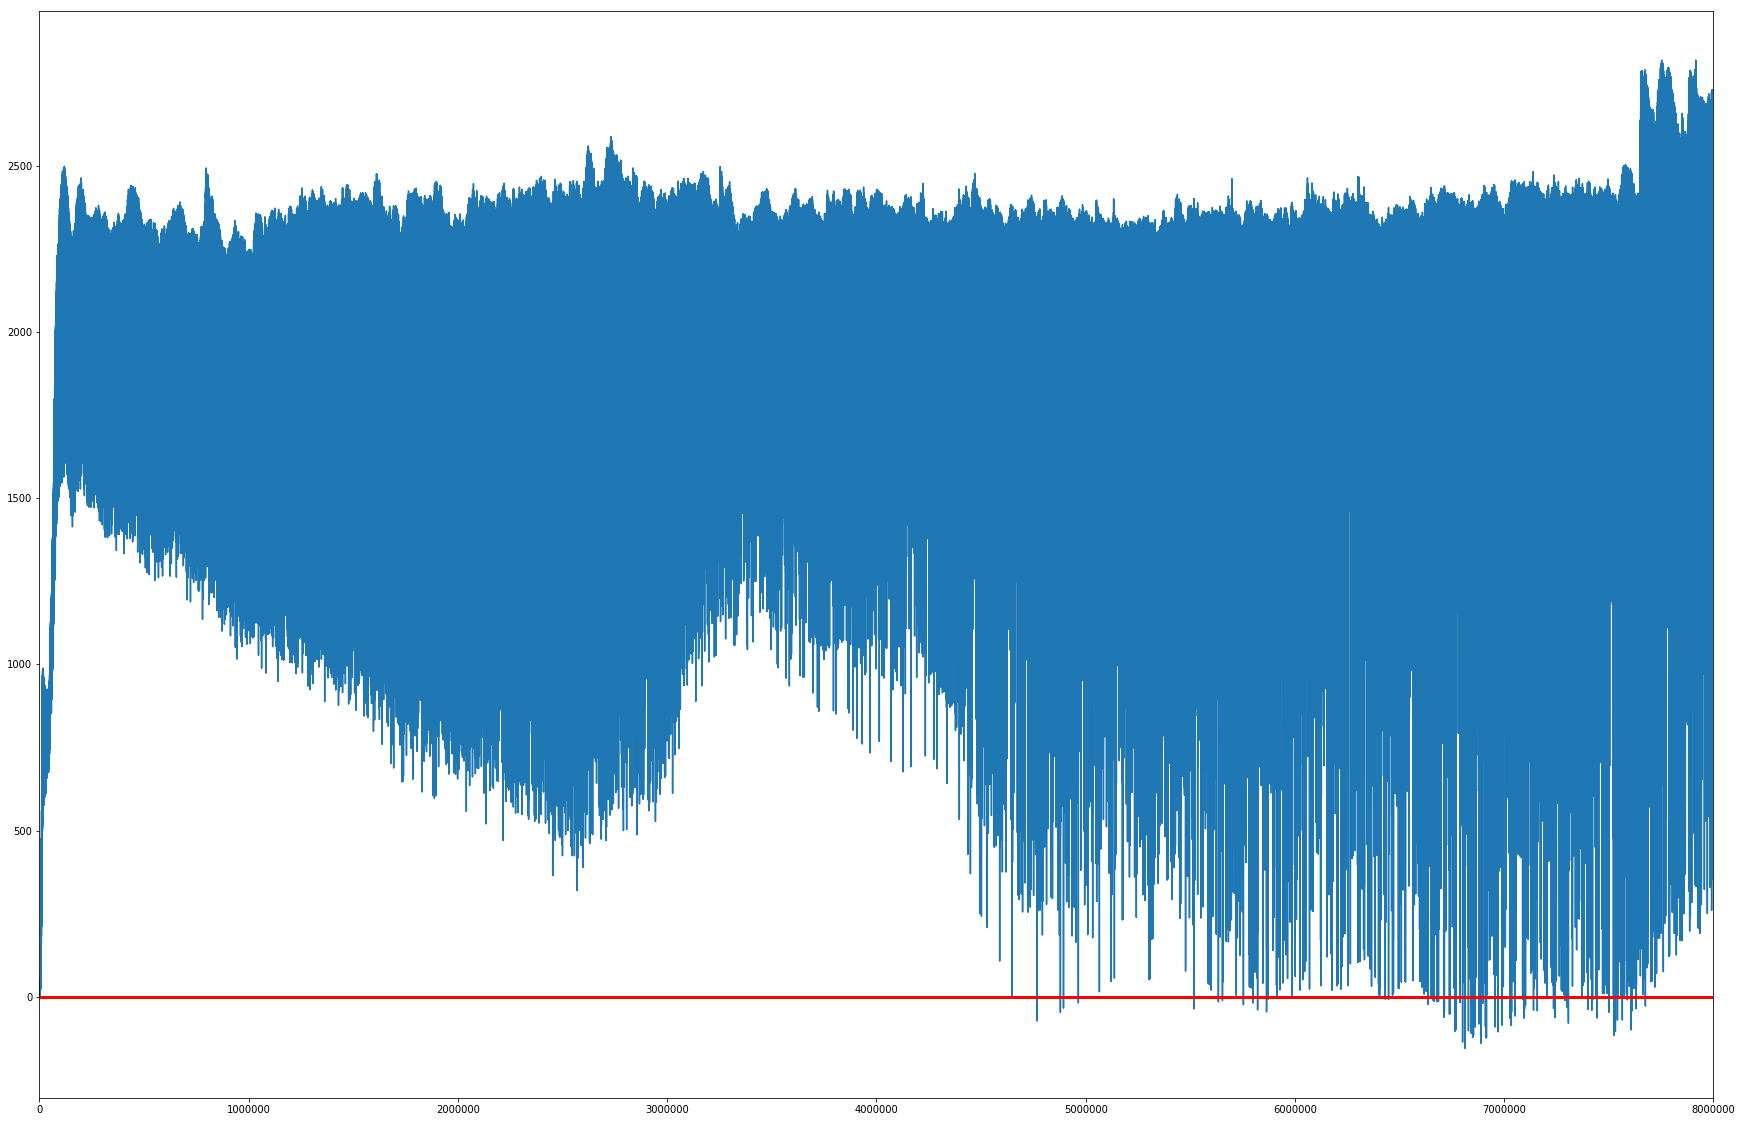

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
_ = plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))

A loss trained for 100000 iterations on 8 cores, for a ddqn agent and default parameters can look like:
![](img/qvalue.png)

### III c) Assess the performance of the trained agent

First we evaluate the performance of a baseline, in this case the "do nothing" agent.

**NB** The use of a Runner (see the first notebook) is particurlaly suited for that purpose. We are showing here how to quickly assess the performances.

In [15]:
from tqdm.notebook import tqdm
NB_EPISODE = 2
nrow = 12*24*7*4*NB_EPISODE
# tun the do nothing for the whole episode
dn_agent = grid2op.Agent.DoNothingAgent(env.action_space)

reward = env.reward_range[0]
env.set_id(0)
i = 0
with tqdm(total=nrow, desc="do nothing") as pbar:
    for _ in range(NB_EPISODE):
        obs = env.reset()
        done= False
        while not done:
            act = dn_agent.act(obs, reward, done)
            obs, reward, done, info = env.step(act)
            i += 1
            pbar.update(1)
            if i >= nrow:
                break
print("Time last by Do Nothing: {}".format(i))


Time last by Do Nothing: 2180


Then we load the saved neural network, and we can now evaluate the fixed policy:

In [24]:
obs = env.reset()
trained_agent = DeepQAgent(env.action_space, mode="DDQN", training_param=TrainingParam())
trained_agent.init_deep_q(trained_agent.convert_obs(obs))
trained_agent.load_network("saved_notebook6_{}.h5".format(agent_name))

reward = env.reward_range[0]
env.set_id(0)
i = 0
with tqdm(total=nrow, desc="trained agent") as pbar:
    for _ in range(NB_EPISODE):
        obs = env.reset()
        done= False
        while not done:
            act = trained_agent.act(obs, reward, done)
            obs, reward, done, info = env.step(act)
            i += 1
            pbar.update(1)
            if i >= nrow:
                break
print("Time last by the trained agent: {}".format(i))

Successfully constructed networks.
Succesfully loaded network.



Time last by the trained agent: 5637


A default agent trained on 8 cores on 1000000 steps (so 8e6 steps in total), 24h of training on a laptop achieved to perform 5637 steps, largely outperforming the "do nothing" agent (which did only 2180 steps on the same 2 environment).